In [1]:
# type: ignore

In [2]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

In [3]:
import shap
import functools
import supervenn
import numpy as np
import pandas as pd
import xarray as xr
import plotnine as pn
import analysis as nb
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyspark.sql import functions as F
from plotnine.ggplot import ggplot as Plotnine
from analysis import apply, assert_condition
from scipy.stats.contingency import relative_risk
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

xr.set_options(display_style="text");

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


### Initialize

In [4]:
data_dir = "/home/eczech/repos/facets/local/data/open_targets_ml"
open_targets_version = "23.12"  # Supported versions: 23.12, 23.09, 23.06
max_training_transition_year = nb.DEFAULT_MAX_TRAINING_TRANSITION_YEAR
clinical_advancement_window = nb.DEFAULT_CLINICAL_ADVANCEMENT_WINDOW
figure_width = nb.FIGURE_WIDTH
validate_modeling_features = False
enable_result_export = True
enable_opportunity_analysis = True
enable_sensitivity_analysis = True

In [5]:
config = nb.get_analysis_config(
    data_dir=data_dir,
    open_targets_version=open_targets_version,
    max_training_transition_year=max_training_transition_year,
    clinical_advancement_window=clinical_advancement_window,
    validate_modeling_features=validate_modeling_features,
)
config.__dict__

{'data_dir': '/home/eczech/repos/facets/local/data/open_targets_ml',
 'open_targets_version': '23.12',
 'clinical_transition_phase': 2,
 'clinical_advancement_window': 2,
 'validate_modeling_features': False,
 'min_training_transition_year': 1990,
 'max_training_transition_year': 2015,
 'max_training_advancement_year': 2017,
 'min_evaluation_transition_year': 2016,
 'max_evaluation_advancement_year': 2024,
 'max_evaluation_transition_year': 2022}

In [6]:
input_dir = Path(config.data_dir) / "features" / config.open_targets_version
output_dir = Path(config.data_dir) / "results"

In [7]:
spark = nb.get_spark()

24/04/12 17:12:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [8]:
@register_cell_magic
def run_if(line, cell):
    if eval(line):
        get_ipython().ex(cell)

### Load

In [9]:
identifiers = spark.read.parquet(str(input_dir / "identifiers.parquet"))
identifiers.printSchema()
identifiers.show(5)
identifiers.count()

root
 |-- disease_id: string (nullable = true)
 |-- target_id: string (nullable = true)
 |-- in_evidence: boolean (nullable = true)
 |-- target_symbol: string (nullable = true)
 |-- in_targets: boolean (nullable = true)
 |-- disease_name: string (nullable = true)
 |-- in_diseases: boolean (nullable = true)

+----------+---------------+-----------+-------------+----------+------------+-----------+
|disease_id|      target_id|in_evidence|target_symbol|in_targets|disease_name|in_diseases|
+----------+---------------+-----------+-------------+----------+------------+-----------+
|      null|ENSG00000020219|       null|      CCT8L1P|      true|        null|       null|
|      null|ENSG00000159186|       null|     ATP5POP1|      true|        null|       null|
|      null|ENSG00000172974|       null|      VDAC2P5|      true|        null|       null|
|      null|ENSG00000174418|       null|      RPL35P9|      true|        null|       null|
|      null|ENSG00000174678|       null|      FAM47DP|

2574506

In [10]:
target_tractability = spark.read.parquet(str(input_dir / "tractability.parquet"))
target_tractability.printSchema()
target_tractability.show(5)
target_tractability.count()

root
 |-- target_id: string (nullable = true)
 |-- tractability_id: string (nullable = true)
 |-- tractability_value: boolean (nullable = true)
 |-- tractability_modality: string (nullable = true)

+---------------+--------------------+------------------+---------------------+
|      target_id|     tractability_id|tractability_value|tractability_modality|
+---------------+--------------------+------------------+---------------------+
|ENSG00000000419|       Approved Drug|             false|                   SM|
|ENSG00000000419|   Advanced Clinical|             false|                   SM|
|ENSG00000000419|    Phase 1 Clinical|             false|                   SM|
|ENSG00000000419|Structure with Li...|             false|                   SM|
|ENSG00000000419| High-Quality Ligand|             false|                   SM|
+---------------+--------------------+------------------+---------------------+
only showing top 5 rows



545748

In [11]:
disease_id_to_name = nb.get_disease_id_to_name(identifiers)
target_id_to_symbol = nb.get_target_id_to_symbol(identifiers)

In [12]:
disease_therapeutic_areas = spark.read.parquet(
    str(input_dir / "therapeutic_areas.parquet")
)
disease_therapeutic_areas.printSchema()
disease_therapeutic_areas.show(5)
disease_therapeutic_areas.count()

root
 |-- disease_id: string (nullable = true)
 |-- therapeutic_area_id: string (nullable = true)
 |-- therapeutic_area_name: string (nullable = true)

+-------------+-------------------+---------------------+
|   disease_id|therapeutic_area_id|therapeutic_area_name|
+-------------+-------------------+---------------------+
|  EFO_0009373|              ALL_0|                  all|
|MONDO_0015775|              ALL_0|                  all|
|  EFO_0006502|              ALL_0|                  all|
|  EFO_0004305|              ALL_0|                  all|
|  EFO_0801967|              ALL_0|                  all|
+-------------+-------------------+---------------------+
only showing top 5 rows



67166

In [13]:
features = spark.read.parquet(str(input_dir / "temporal_features.parquet"))
features.printSchema()
features.count()

root
 |-- target_id: string (nullable = true)
 |-- disease_id: string (nullable = true)
 |-- year: long (nullable = true)
 |-- target_disease__clinical__phase_max__reached: integer (nullable = true)
 |-- target_disease__clinical__phase1__reached: integer (nullable = true)
 |-- target_disease__clinical__phase2__reached: integer (nullable = true)
 |-- target_disease__clinical__phase3__reached: integer (nullable = true)
 |-- target_disease__clinical__phase4__reached: integer (nullable = true)
 |-- target_disease__affected_pathway__cancer_biomarkers: double (nullable = true)
 |-- target_disease__affected_pathway__crispr: double (nullable = true)
 |-- target_disease__affected_pathway__crispr_screen: double (nullable = true)
 |-- target_disease__affected_pathway__progeny: double (nullable = true)
 |-- target_disease__affected_pathway__reactome: double (nullable = true)
 |-- target_disease__affected_pathway__slapenrich: double (nullable = true)
 |-- target_disease__affected_pathway__sysbio: d

97594663

### Inflation

In [14]:
advancement_statistics = nb.get_feature_advancement_statistics(
    features,
    initial_phases=[1, 2],
    min_transition_year=nb.MIN_EVIDENCE_YEAR,
    max_transition_year=nb.MAX_EVIDENCE_YEAR - config.clinical_advancement_window,
).toPandas()
assert advancement_statistics.notnull().all().all()
advancement_statistics.head()

24/04/12 17:12:47 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


feature_name emerged  progress  n_pairs
0                     animal_model__impc  before   stalled      197
1   somatic_mutation__cancer_gene_census   after   stalled      820
2  genetic_association__genomics_england   after   stalled        9
3       rna_expression__expression_atlas   after  advanced      191
4              genetic_association__omim    none  advanced    15173

In [83]:
inflation_statistics = nb.get_feature_inflation_statistics(advancement_statistics)
inflation_statistics.sort_values(("after", "advanced"), ascending=False)

emerged                                    after                     before  \
progress                                advanced  fraction stalled advanced   
feature_name                                                                  
literature__europepmc                       2960  0.344026    5644     2644   
somatic_mutation__cancer_gene_census         287  0.259259     820       53   
genetic_association__ot_genetics_portal      241  0.556582     192       22   
rna_expression__expression_atlas             191  0.370874     324       54   
animal_model__impc                            83  0.506098      81       98   
affected_pathway__cancer_biomarkers           37  0.456790      44        4   
genetic_association__curated                  30  0.681818      14       34   
genetic_association__genomics_england         28  0.756757       9       12   
affected_pathway__crispr_screen               24  0.888889       3        0   
genetic_association__gene_burden              21  0.477273      23        0   
affected_pathway__reactome                    20  0.625000      12       11   
genetic_association__eva                      11  0.785714       3       21   
genetic_association__omim                     11  0.785714       3       21   
genetic_association__uniprot_literature       10  0.714286       4       16   
genetic_association__uniprot_variants          5  0.555556       4       13   
genetic_association__orphanet                  4  0.571429       3        3   
somatic_mutation__eva_somatic                  4  0.800000       1        5   
genetic_association__gene2phenotype            1  1.000000       0        5   
known_drug__chembl                             0       NaN       0        0   
affected_pathway__crispr                       0       NaN       0        0   
genetic_association__clingen                   0       NaN       0        0   
affected_pathway__sysbio                       0       NaN       0        0   
affected_pathway__slapenrich                   0       NaN       0        0   
affected_pathway__progeny                      0       NaN       0        0   
somatic_mutation__intogen                      0       NaN       0        0   

emerged                                                       none            \
progress                                 fraction stalled advanced  fraction   
feature_name                                                                   
literature__europepmc                    0.299264    6191     9601  0.250208   
somatic_mutation__cancer_gene_census     0.120181     388    14865  0.273944   
genetic_association__ot_genetics_portal  0.301370      51    14942  0.270174   
rna_expression__expression_atlas         0.150838     304    14960  0.272307   
animal_model__impc                       0.332203     197    15024  0.271427   
affected_pathway__cancer_biomarkers      0.129032      27    15164  0.272249   
genetic_association__curated             0.478873      37    15141  0.271851   
genetic_association__genomics_england    0.545455      10    15165  0.272008   
affected_pathway__crispr_screen               NaN       0    15181  0.272139   
genetic_association__gene_burden              NaN       0    15184  0.272276   
affected_pathway__reactome               0.200000      44    15174  0.272306   
genetic_association__eva                 0.512195      20    15173  0.272132   
genetic_association__omim                0.512195      20    15173  0.272132   
genetic_association__uniprot_literature  0.516129      15    15179  0.272191   
genetic_association__uniprot_variants    0.565217      10    15187  0.272271   
genetic_association__orphanet            0.300000       7    15198  0.272395   
somatic_mutation__eva_somatic            0.227273      17    15196  0.272408   
genetic_association__gene2phenotype      0.500000       5    15199  0.272384   
known_drug__chembl                            NaN       0    15205  0.272437   
affected_pathway__crispr   

INFO:analysis:Saving figure to '/home/eczech/repos/clinical_advancement_paper/paper/assets/evidence_inflation.pdf'


/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 4.5 in image.
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/eczech/repos/clinical_advancement_paper/paper/assets/evidence_inflation.pdf
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


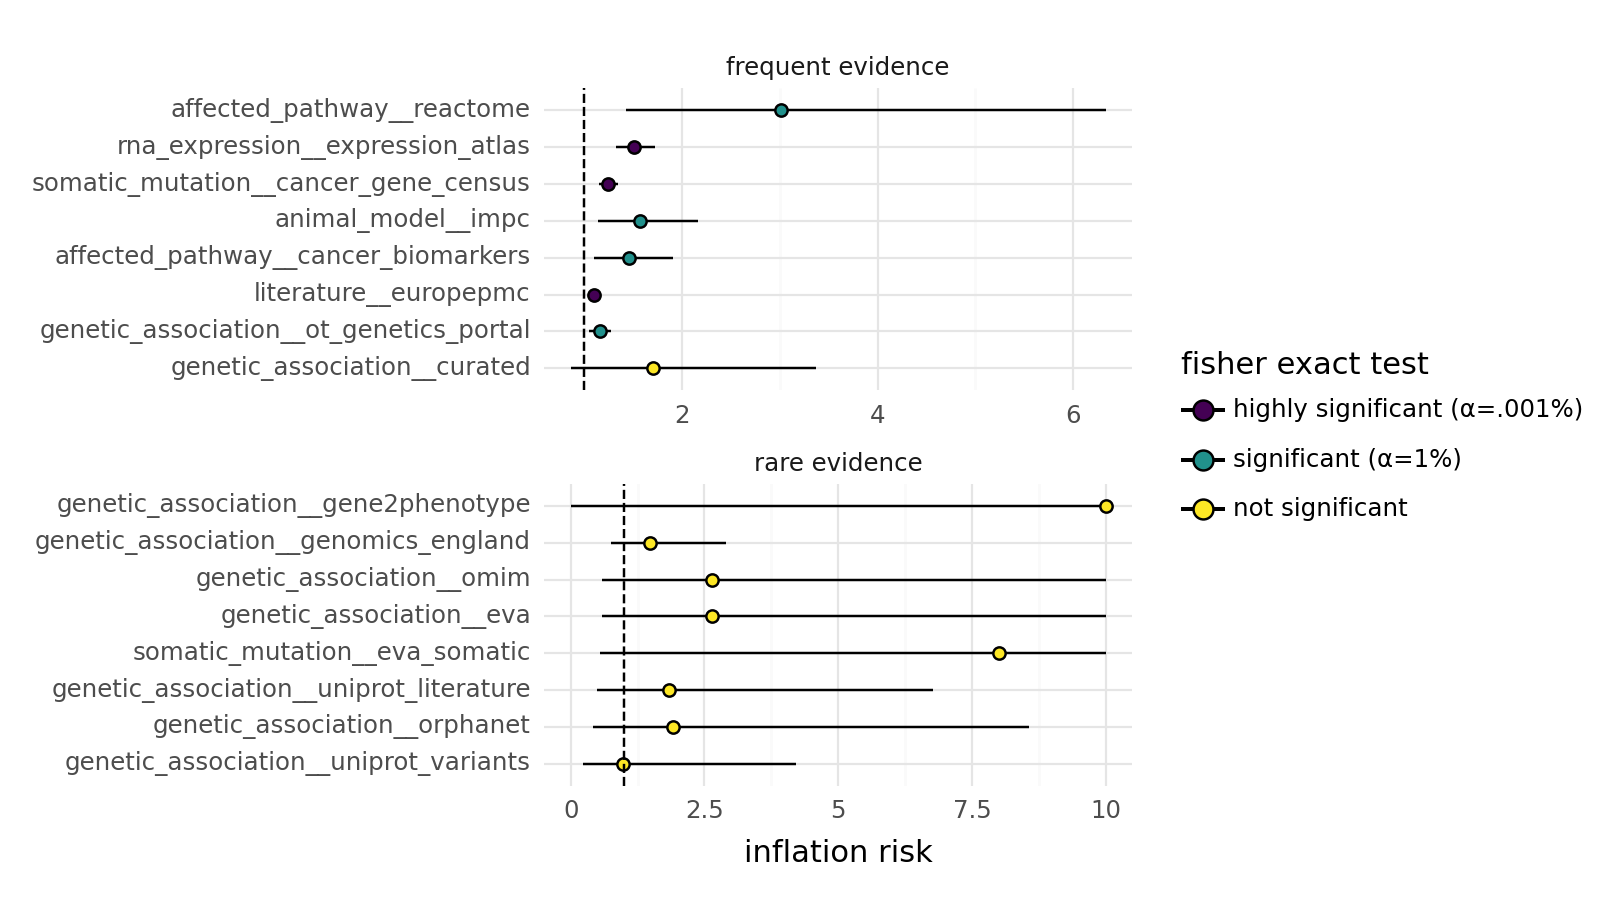

<Figure Size: (800 x 450)>

In [88]:
(
    # fmt: off
    inflation_statistics
    .pipe(
        lambda df: df.set_axis(
            ["_".join([e for e in c if e]) for c in df.columns.values], axis="columns"
        )
    )
    .pipe(
        lambda df: nb.save_figure("evidence_inflation.pdf", enable_result_export)(
            pn.ggplot(
                df.dropna(subset=["after_fraction", "before_fraction"]).reset_index()
                .assign(
                    p_value_bin=lambda df: pd.cut(
                        df["p_value"],
                        bins=[0, 1e-5, 1e-2, 1],
                        labels=[
                            "highly significant (α=.001%)",
                            "significant (α=1%)",
                            "not significant",
                        ],
                        include_lowest=False,
                    )
                )
                .assign(
                    feature_name=lambda df: pd.Categorical(
                        df["feature_name"],
                        ordered=True,
                        categories=df.sort_values("relative_risk_low")["feature_name"].values,
                    )
                )
                .assign(
                    feature_group=lambda df: 
                    (
                        df["feature_name"].str.contains("^somatic_mutation__eva_somatic$") | 
                        (
                            df["feature_name"].str.contains("^genetic_association__")
                            & ~df["feature_name"].str.contains("__curated$|__ot_genetics_portal$")
                        )
                    )
                    .map({True: "rare evidence", False: "frequent evidence"})
                )
                .assign(
                    relative_risk_high=lambda df: df["relative_risk_high"].where(
                        df["feature_group"] == "frequent evidence",
                        df["relative_risk_high"].clip(0, 10).fillna(0)
                    ),
                    relative_risk_low=lambda df: df["relative_risk_low"].where(
                        df["feature_group"] == "frequent evidence",
                        df["relative_risk_low"].clip(0, 10).fillna(0)
                    ),
                    relative_risk=lambda df: df["relative_risk"].where(
                        df["feature_group"] == "frequent evidence",
                        df["relative_risk"].clip(0, 10).fillna(0)
                    )
                )
                ,
                pn.aes(
                    x="feature_name", y="relative_risk",
                    ymin="relative_risk_low", ymax="relative_risk_high",
                    fill="p_value_bin",
                ),
            )
            + pn.geom_pointrange()
            + pn.labs(
                y="inflation risk",
                x="",
                fill="fisher exact test",
            )
            + pn.facet_wrap("~ feature_group", scales="free", ncol=1)
            + pn.geom_hline(yintercept=1, linetype="dashed")
            + pn.coord_flip()
            + pn.theme_minimal()
            + pn.theme(figure_size=(figure_width, 4.5))
        )
    )
    # fmt: on
)

### Features

In [16]:
training_features = (
    nb.get_modeling_features(
        features,
        phase=config.clinical_transition_phase,
        min_transition_year=config.min_training_transition_year,
        max_transition_year=config.max_training_transition_year,
        max_advancement_year=config.max_training_advancement_year,
    )
    .transform(
        lambda df: nb.validate_modeling_features(df)
        if config.validate_modeling_features
        else df
    )
    .toPandas()
)
training_features.info()
training_features.head()

INFO:analysis:Using static features:
target_disease__genetic_association__clingen
target_disease__genetic_association__curated
target_disease__genetic_association__eva
target_disease__genetic_association__gene2phenotype
target_disease__genetic_association__gene_burden
target_disease__genetic_association__genomics_england
target_disease__genetic_association__omim
target_disease__genetic_association__orphanet
target_disease__genetic_association__ot_genetics_portal
target_disease__genetic_association__uniprot_literature
target_disease__genetic_association__uniprot_variants
target__tissue_specificity
target__tissue_distribution
target__genetic_constraint
target__mouse_ko_score


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25398 entries, 0 to 25397
Data columns (total 42 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   target_id                                                25398 non-null  object 
 1   disease_id                                               25398 non-null  object 
 2   transition_year                                          25398 non-null  int64  
 3   target_disease__genetic_association__clingen             11 non-null     float64
 4   target_disease__genetic_association__curated             171 non-null    float64
 5   target_disease__genetic_association__eva                 134 non-null    float64
 6   target_disease__genetic_association__gene2phenotype      7 non-null      float64
 7   target_disease__genetic_association__gene_burden         18 non-null     float64
 8   target_disease__genetic_as

target_id   disease_id  transition_year  \
0  ENSG00000007314  EFO_0000555             2003   
1  ENSG00000007314  EFO_0801084             2011   
2  ENSG00000023228  EFO_1000657             2015   
3  ENSG00000025708  EFO_0000702             2013   
4  ENSG00000037280  EFO_0003897             2006   

   target_disease__genetic_association__clingen  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

   target_disease__genetic_association__curated  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

   target_disease__genetic_association__eva  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

   target_disease__genetic_association__gene2phenotype  \
0                                                NaN     
1                                                NaN     
2                                                NaN     
3                                                NaN     
4                                                NaN     

   target_disease__genetic_association__gene_burden  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   

   target_disease__genetic_association__genomics_england  \
0                                                NaN       
1                                                NaN       
2                                                NaN       
3                                                NaN       
4                                                NaN       

   target_disease__genetic_association__omim  ...  \
0                                        NaN  ...   
1                                        NaN  ...   
2                                        NaN  ...   
3                                        NaN  ...   
4                                        NaN  ...   

   target_disease__known_drug__chembl  target_disease__literature__europepmc  \
0                                 NaN                                    NaN   
1                                 NaN                                    NaN   
2                                 NaN                                    NaN   
3                                 NaN                                    NaN   
4                                 NaN                                   0.03   

   target_disease__rna_expression__expression_atlas  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   

   target_disease__somatic_mutation__cancer_gene_census  \
0                                                NaN      
1                                                NaN      
2                                                NaN      
3                                                NaN      
4                                                NaN      

   target_disease__somatic_mutation__eva_somatic  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4           

In [17]:
(training_features.select_dtypes(include=[np.number]).describe().T.sort_values("count"))

count         mean  \
target_disease__clinical__phase2__reached               0.0          NaN   
target_disease__affected_pathway__crispr_screen         0.0          NaN   
target_disease__affected_pathway__crispr                0.0          NaN   
target_disease__clinical__phase4__reached               0.0          NaN   
target_disease__clinical__phase3__reached               0.0          NaN   
target_disease__affected_pathway__slapenrich            0.0          NaN   
target_disease__somatic_mutation__intogen               0.0          NaN   
target_disease__affected_pathway__progeny               0.0          NaN   
target_disease__affected_pathway__sysbio                0.0          NaN   
target_disease__known_drug__chembl                      0.0          NaN   
target_disease__genetic_association__gene2pheno...      7.0     1.000000   
target_disease__somatic_mutation__eva_somatic           9.0     0.901111   
target_disease__genetic_association__clingen           11.0     0.820000   
target_disease__genetic_association__orphanet          11.0     1.000000   
target_disease__affected_pathway__cancer_biomar...     17.0     1.000000   
target_disease__genetic_association__gene_burden       18.0     0.598825   
target_disease__affected_pathway__reactome             25.0     1.000000   
target_disease__genetic_association__uniprot_va...     29.0     1.000000   
target_disease__genetic_association__omim              34.0     0.852059   
target_disease__genetic_association__genomics_e...     42.0     0.988095   
target_disease__genetic_association__uniprot_li...     48.0     0.906250   
target_disease__animal_model__impc                     93.0     0.563526   
target_disease__rna_expression__expression_atlas       97.0     0.130415   
target_disease__genetic_association__eva              134.0     0.624328   
target_disease__somatic_mutation__cancer_gene_c...    148.0     0.793919   
target_disease__genetic_association__curated          171.0     0.721287   
target_disease__genetic_association__ot_genetic...    226.0     0.520123   
target_disease__clinical__phase1__reached            2747.0     1.000000   
target_disease__clinical__phase_max__reached         2747.0     1.000000   
target_disease__literature__europepmc                3416.0     0.166838   
target__mouse_ko_score                              20877.0    -0.608793   
disease__clinical__phase_max__reached               21864.0     3.189032   
target__genetic_constraint                          24529.0    -0.327363   
target__clinical__phase_max__reached                24621.0     3.532066   
target__tissue_distribution                         25200.0    -0.373671   
target__tissue_specificity                          25200.0    -0.007520   
feature_year                                        25356.0  2006.947547   
transition_year                                     25398.0  2007.932908   
target_disease__time__transition                    25398.0     9.067092   

                                                         std          min  \
target_disease__clinical__phase2__reached                NaN          NaN   
target_disease__affected_pathway__crispr_screen          NaN          NaN   
target_disease__affected_pathway__crispr                 NaN          NaN   
target_disease__clinical__phase4__reached                NaN          NaN   
target_disease__clinical__phase3__reached                NaN          NaN   
target_disease__affected_pathway__slapenrich             NaN          NaN   
target_disease__somatic_mutation__intogen                NaN          NaN   
target_disease__affected_pathway__progeny                NaN          NaN   
target_disease__affected_pathway__sysbio                 NaN          NaN   
target_disease__known_drug__chembl                       NaN          NaN   
target_disease__genetic_association__gene2pheno...  0.000000     1.000000   
target_disease__somatic_mutation__eva_somatic       0.071317     0.720000   
target_disea

In [18]:
evaluation_features = (
    nb.get_modeling_features(
        features,
        phase=config.clinical_transition_phase,
        min_transition_year=config.min_evaluation_transition_year,
        max_transition_year=config.max_evaluation_transition_year,
        max_advancement_year=config.max_evaluation_advancement_year,
    )
    .transform(
        lambda df: nb.validate_modeling_features(df)
        if config.validate_modeling_features
        else df
    )
    .toPandas()
)
evaluation_features.info()
evaluation_features.head()

INFO:analysis:Using static features:
target_disease__genetic_association__clingen
target_disease__genetic_association__curated
target_disease__genetic_association__eva
target_disease__genetic_association__gene2phenotype
target_disease__genetic_association__gene_burden
target_disease__genetic_association__genomics_england
target_disease__genetic_association__omim
target_disease__genetic_association__orphanet
target_disease__genetic_association__ot_genetics_portal
target_disease__genetic_association__uniprot_literature
target_disease__genetic_association__uniprot_variants
target__tissue_specificity
target__tissue_distribution
target__genetic_constraint
target__mouse_ko_score


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9010 entries, 0 to 9009
Data columns (total 42 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   target_id                                                9010 non-null   object 
 1   disease_id                                               9010 non-null   object 
 2   transition_year                                          9010 non-null   int64  
 3   target_disease__genetic_association__clingen             13 non-null     float64
 4   target_disease__genetic_association__curated             51 non-null     float64
 5   target_disease__genetic_association__eva                 44 non-null     float64
 6   target_disease__genetic_association__gene2phenotype      8 non-null      float64
 7   target_disease__genetic_association__gene_burden         9 non-null      float64
 8   target_disease__genetic_asso

target_id   disease_id  transition_year  \
0  ENSG00000070886  EFO_1000489             2018   
1  ENSG00000071082  EFO_0005952             2019   
2  ENSG00000080293  EFO_0001073             2016   
3  ENSG00000082175  EFO_1000796             2022   
4  ENSG00000082556  EFO_1000906             2018   

   target_disease__genetic_association__clingen  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

   target_disease__genetic_association__curated  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

   target_disease__genetic_association__eva  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

   target_disease__genetic_association__gene2phenotype  \
0                                                NaN     
1                                                NaN     
2                                                NaN     
3                                                NaN     
4                                                NaN     

   target_disease__genetic_association__gene_burden  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   

   target_disease__genetic_association__genomics_england  \
0                                                NaN       
1                                                NaN       
2                                                NaN       
3                                                NaN       
4                                                NaN       

   target_disease__genetic_association__omim  ...  \
0                                        NaN  ...   
1                                        NaN  ...   
2                                        NaN  ...   
3                                        NaN  ...   
4                                        NaN  ...   

   target_disease__known_drug__chembl  target_disease__literature__europepmc  \
0                                 NaN                                    NaN   
1                                 NaN                                    NaN   
2                                 NaN                                    0.1   
3                                 NaN                                    0.3   
4                                 NaN                                    NaN   

   target_disease__rna_expression__expression_atlas  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   

   target_disease__somatic_mutation__cancer_gene_census  \
0                                                NaN      
1                                                NaN      
2                                                NaN      
3                                                NaN      
4                                                NaN      

   target_disease__somatic_mutation__eva_somatic  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4           

In [19]:
(
    evaluation_features.select_dtypes(include=[np.number])
    .describe()
    .T.sort_values("count")
)

count         mean  \
target_disease__clinical__phase2__reached              0.0          NaN   
target_disease__known_drug__chembl                     0.0          NaN   
target_disease__affected_pathway__sysbio               0.0          NaN   
target_disease__affected_pathway__slapenrich           0.0          NaN   
target_disease__affected_pathway__progeny              0.0          NaN   
target_disease__affected_pathway__crispr_screen        0.0          NaN   
target_disease__affected_pathway__crispr               0.0          NaN   
target_disease__clinical__phase4__reached              0.0          NaN   
target_disease__clinical__phase3__reached              0.0          NaN   
target_disease__somatic_mutation__intogen              0.0          NaN   
target_disease__somatic_mutation__eva_somatic          5.0     0.910000   
target_disease__genetic_association__orphanet          7.0     1.000000   
target_disease__affected_pathway__reactome             8.0     1.000000   
target_disease__genetic_association__gene2pheno...     8.0     1.000000   
target_disease__genetic_association__uniprot_va...     9.0     1.000000   
target_disease__genetic_association__gene_burden       9.0     0.620783   
target_disease__genetic_association__uniprot_li...    13.0     1.000000   
target_disease__genetic_association__clingen          13.0     0.695385   
target_disease__genetic_association__genomics_e...    14.0     0.964286   
target_disease__genetic_association__omim             14.0     0.888571   
target_disease__affected_pathway__cancer_biomar...    14.0     1.000000   
target_disease__genetic_association__eva              44.0     0.651818   
target_disease__genetic_association__curated          51.0     0.713922   
target_disease__genetic_association__ot_genetic...    54.0     0.499231   
target_disease__animal_model__impc                    78.0     0.568292   
target_disease__rna_expression__expression_atlas     131.0     0.119697   
target_disease__somatic_mutation__cancer_gene_c...   167.0     0.735030   
target_disease__clinical__phase1__reached           1189.0     1.000000   
target_disease__clinical__phase_max__reached        1189.0     1.000000   
target_disease__literature__europepmc               1892.0     0.228203   
target__mouse_ko_score                              7183.0    -0.615018   
disease__clinical__phase_max__reached               8082.0     3.422049   
target__genetic_constraint                          8633.0    -0.239620   
target__tissue_distribution                         8938.0    -0.373294   
target__tissue_specificity                          8938.0     0.019607   
target__clinical__phase_max__reached                8972.0     3.758025   
transition_year                                     9010.0  2018.902220   
feature_year                                        9010.0  2017.897780   
target_disease__time__transition                    9010.0     5.097780   

                                                         std          min  \
target_disease__clinical__phase2__reached                NaN          NaN   
target_disease__known_drug__chembl                       NaN          NaN   
target_disease__affected_pathway__sysbio                 NaN          NaN   
target_disease__affected_pathway__slapenrich             NaN          NaN   
target_disease__affected_pathway__progeny                NaN          NaN   
target_disease__affected_pathway__crispr_screen          NaN          NaN   
target_disease__affected_pathway__crispr                 NaN          NaN   
target_disease__clinical__phase4__reached                NaN          NaN   
target_disease__clinical__phase3__reached                NaN          NaN   
target_disease__somatic_mutation__intogen                NaN          NaN   
target_disease__somatic_mutation__eva_somatic       0.022361     0.900000   
target_disease__genetic_association__orphanet       0.000000     1.000000   
target_disease__affected_pathway__reactome         

In [20]:
feature_statistics = nb.get_feature_statistics(
    features=(
        pd.concat(
            [
                training_features.assign(split="training"),
                evaluation_features.assign(split="evaluation"),
            ],
            axis=0,
            ignore_index=True,
        )
    ),
    therapeutic_areas=disease_therapeutic_areas.toPandas(),
)
feature_statistics.info()
feature_statistics.head()

INFO:analysis:Target-disease features partitioned into:
evidence features=['target_disease__genetic_association__clingen', 'target_disease__genetic_association__curated', 'target_disease__genetic_association__eva', 'target_disease__genetic_association__gene2phenotype', 'target_disease__genetic_association__gene_burden', 'target_disease__genetic_association__genomics_england', 'target_disease__genetic_association__omim', 'target_disease__genetic_association__orphanet', 'target_disease__genetic_association__ot_genetics_portal', 'target_disease__genetic_association__uniprot_literature', 'target_disease__genetic_association__uniprot_variants', 'target_disease__affected_pathway__cancer_biomarkers', 'target_disease__affected_pathway__crispr', 'target_disease__affected_pathway__crispr_screen', 'target_disease__affected_pathway__progeny', 'target_disease__affected_pathway__reactome', 'target_disease__affected_pathway__slapenrich', 'target_disease__affected_pathway__sysbio', 'target_disease__an

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 49 entries, ('all', 'evaluation') to ('urinary system disease', 'training')
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   n_targets                     49 non-null     int64  
 1   n_diseases                    49 non-null     int64  
 2   n_pairs                       49 non-null     int64  
 3   min_year                      49 non-null     int64  
 4   max_year                      49 non-null     int64  
 5   balance                       49 non-null     float64
 6   n_pairs_with_evidence         49 non-null     int64  
 7   fraction_pairs_with_evidence  49 non-null     float64
dtypes: float64(2), int64(6)
memory usage: 3.5+ KB


statistic                          n_targets  n_diseases  n_pairs  min_year  \
therapeutic_area_name  split                                                  
all                    evaluation       1063        1075     9010      2016   
                       training         1226        1420    25398      1990   
biological_process     evaluation        157          14      215      2016   
                       training          152          12      163      1999   
cancer or benign tumor evaluation        656         400     4013      2016   

statistic                          max_year   balance  n_pairs_with_evidence  \
therapeutic_area_name  split                                                   
all                    evaluation      2022  0.090122                   2062   
                       training        2015  0.197575                   3737   
biological_process     evaluation      2022  0.288372                     18   
                       training        2015  0.061350                     21   
cancer or benign tumor evaluation      2022  0.038874                   1148   

statistic                          fraction_pairs_with_evidence  
therapeutic_area_name  split                                     
all                    evaluation                      0.228857  
                       training                        0.147138  
biological_process     evaluation                      0.083721  
                       training                        0.128834  
cancer or benign tumor evaluation                      0.286070

In [21]:
(
    feature_statistics.pipe(
        apply,
        lambda df: display(
            df.filter(regex="pairs")
            .unstack("split")
            .reorder_levels(["split", "statistic"], axis="columns")
            .sort_index(axis="columns")
            .sort_values(("evaluation", "n_pairs"), ascending=False)
        ),
    ).pipe(
        apply,
        lambda df: display(
            df.drop(columns="fraction_pairs_with_evidence")
            .rename(columns={"n_pairs_with_evidence": "n_pairs_wev"})
            .unstack("split")
            .reorder_levels(["split", "statistic"], axis="columns")
            .sort_index(axis="columns")
            .apply(lambda s: s if s.name[1] in ["balance"] else s.fillna(0).astype(int))
            .pipe(lambda df: df[df[("evaluation", "n_pairs")] > 10])
            .sort_values(("evaluation", "n_pairs"), ascending=False)
            .pipe(
                lambda df: df.style.format(
                    "{:.2%}", subset=[c for c in df if c[1] == "balance"]
                )
                .pipe(nb.set_default_table_styles, height_px=60)
                .apply_index(
                    lambda v: ["white-space: nowrap;"] * len(v),
                    level="therapeutic_area_name",
                    axis="index",
                )
                .background_gradient(
                    cmap="Reds", axis=0, subset=[c for c in df if c[1].startswith("n_")]
                )
                .background_gradient(
                    cmap="Greens",
                    axis=None,
                    subset=[c for c in df if c[1].endswith("_year")],
                )
                .background_gradient(
                    cmap="Blues", axis=None, subset=[c for c in df if c[1] == "balance"]
                )
            )
        ),
    )
);

split                                                          evaluation  \
statistic                                    fraction_pairs_with_evidence   
therapeutic_area_name                                                       
all                                                              0.228857   
cancer or benign tumor                                           0.286070   
genetic, familial or congenital disease                          0.185749   
nervous system disease                                           0.176662   
gastrointestinal disease                                         0.285714   
immune system disease                                            0.283265   
hematologic disease                                              0.256109   
endocrine system disease                                         0.304531   
reproductive system or breast disease                            0.207806   
musculoskeletal or connective tissue disease                     0.257596   
respiratory or thoracic disease                                  0.270186   
cardiovascular disease                                           0.196110   
phenotype                                                        0.125620   
integumentary system disease                                     0.294849   
urinary system disease                                           0.238859   
infectious disease                                               0.217391   
psychiatric disorder                                             0.183556   
disorder of visual system                                        0.123037   
nutritional or metabolic disease                                 0.203226   
biological_process                                               0.083721   
pancreas disease                                                 0.415888   
injury, poisoning or other complication                          0.260163   
pregnancy or perinatal disease                                   0.125000   
disorder of ear                                                  0.000000   
measurement                                                      0.000000   

split                                                                       \
statistic                                    n_pairs n_pairs_with_evidence   
therapeutic_area_name                                                        
all                                           9010.0                2062.0   
cancer or benign tumor                        4013.0                1148.0   
genetic, familial or congenital disease       2035.0                 378.0   
nervous system disease                        1534.0                 271.0   
gastrointestinal disease                      1260.0                 360.0   
immune system disease                         1225.0                 347.0   
hematologic disease                           1023.0                 262.0   
endocrine system disease                       949.0                 289.0   
reproductive system or breast disease          948.0                 197.0   
musculoskeletal or connective tissue disease   757.0                 195.0   
respiratory or thoracic disease                644.0                 174.0   
cardiovascular disease                         617.0                 121.0   
phenotype                                      605.0                  76.0   
integumentary system disease                   563.0                 166.0   
urinary system disease                         561.0                 134.0   
infectious disease                             529.0                 115.0   
psychiatric disorder                           523.0                  96.0   
disorder of visual system                      382.0                  47.0   
nutritional or metabolic disease               310.0                  63.0   
biological_process                             215.0                  18.0   
pancreas disease                               21

In [22]:
with pd.option_context("display.max_colwidth", None):
    display(
        training_features.pipe(lambda df: nb.get_feature_info(df.columns.to_list()))
        .pipe(
            lambda df: df[~df["feature"].str.startswith("target_disease__clinical__")]
        )
        .sort_values(["entity", "feature", "kind"])
        .pipe(lambda df: df.set_axis(range(1, len(df) + 1), axis="index"))
        .pipe(
            nb.save_table,
            filename="feature_table.tex",
            enable=enable_result_export,
            convert_css=True,
            hrules=True,
            position_float="centering",
            label="tab:features",
            caption="Features used in modeling and analysis",
        )
    )

INFO:analysis:Saving table to '/home/eczech/repos/clinical_advancement_paper/paper/assets/feature_table.tex'


feature          entity  \
1                     disease__clinical__phase_max__reached         disease   
2                      target__clinical__phase_max__reached          target   
3                                target__genetic_constraint          target   
4                                    target__mouse_ko_score          target   
5                               target__tissue_distribution          target   
6                                target__tissue_specificity          target   
7       target_disease__affected_pathway__cancer_biomarkers  target_disease   
8                  target_disease__affected_pathway__crispr  target_disease   
9           target_disease__affected_pathway__crispr_screen  target_disease   
10                target_disease__affected_pathway__progeny  target_disease   
11               target_disease__affected_pathway__reactome  target_disease   
12             target_disease__affected_pathway__slapenrich  target_disease   
13                 target_disease__affected_pathway__sysbio  target_disease   
14                       target_disease__animal_model__impc  target_disease   
15             target_disease__genetic_association__clingen  target_disease   
16             target_disease__genetic_association__curated  target_disease   
17                 target_disease__genetic_association__eva  target_disease   
18      target_disease__genetic_association__gene2phenotype  target_disease   
19         target_disease__genetic_association__gene_burden  target_disease   
20    target_disease__genetic_association__genomics_england  target_disease   
21                target_disease__genetic_association__omim  target_disease   
22            target_disease__genetic_association__orphanet  target_disease   
23  target_disease__genetic_association__ot_genetics_portal  target_disease   
24  target_disease__genetic_association__uniprot_literature  target_disease   
25    target_disease__genetic_association__uniprot_variants  target_disease   
26                       target_disease__known_drug__chembl  target_disease   
27                    target_disease__literature__europepmc  target_disease   
28                        target_disease__outcome__advanced  target_disease   
29         target_disease__rna_expression__expression_atlas  target_disease   
30     target_disease__somatic_mutation__cancer_gene_census  target_disease   
31            target_disease__somatic_mutation__eva_somatic  target_disease   
32                target_disease__somatic_mutation__intogen  target_disease   
33                         target_disease__time__transition  target_disease   

        kind  
1   temporal  
2   temporal  
3     static  
4     static  
5     static  
6     static  
7   temporal  
8   temporal  
9   temporal  
10  temporal  
11  temporal  
12  temporal  
13  temporal  
14  temporal  
15    static  
16    static  
17    static  
18    static  
19    static  
20    static  
21    static  
22    static  
23    static  
24    static  
25    static  
26  temporal  
27  temporal  
28  temporal  
29  temporal  
30  temporal  
31  temporal  
32  temporal  
33  temporal

In [23]:
evaluation_feature_presence = nb.get_feature_presence(evaluation_features)
evaluation_feature_presence

INFO:analysis:The following features will be used to calculate presence: ['target_disease__genetic_association__clingen', 'target_disease__genetic_association__curated', 'target_disease__genetic_association__eva', 'target_disease__genetic_association__gene2phenotype', 'target_disease__genetic_association__gene_burden', 'target_disease__genetic_association__genomics_england', 'target_disease__genetic_association__omim', 'target_disease__genetic_association__orphanet', 'target_disease__genetic_association__ot_genetics_portal', 'target_disease__genetic_association__uniprot_literature', 'target_disease__genetic_association__uniprot_variants', 'target_disease__affected_pathway__cancer_biomarkers', 'target_disease__affected_pathway__crispr', 'target_disease__affected_pathway__crispr_screen', 'target_disease__affected_pathway__progeny', 'target_disease__affected_pathway__reactome', 'target_disease__affected_pathway__slapenrich', 'target_disease__affected_pathway__sysbio', 'target_disease__ani

feature_group                    feature_group_label  \
2     target_disease__affected_pathway     pair has affected pathway evidence   
3         target_disease__animal_model         pair has animal model evidence   
4  target_disease__genetic_association  pair has genetic association evidence   
8       target_disease__rna_expression       pair has rna expression evidence   
9     target_disease__somatic_mutation     pair has somatic mutation evidence   
7              target_disease__outcome       pair has advanced beyond phase 2   
5           target_disease__literature           pair has literature evidence   
0                     disease__phase_2      disease has prior phase 2+ trials   
6              target_disease__no_data                   pair has no evidence   
1                      target__phase_2       target has prior phase 2+ trials   

   n_pairs                                              pairs  
2       22  [(ENSG00000188641, MONDO_0004992), (ENSG000001...  
3       78  [(ENSG00000159640, MONDO_0010520), (ENSG000001...  
4      105  [(ENSG00000186868, MONDO_0019037), (ENSG000001...  
8      131  [(ENSG00000160194, EFO_0002517), (ENSG00000088...  
9      171  [(ENSG00000147403, EFO_0000403), (ENSG00000146...  
7      812  [(ENSG00000163288, MONDO_0001734), (ENSG000001...  
5     1892  [(ENSG00000080293, EFO_0001073), (ENSG00000082...  
0     6855  [(ENSG00000071082, EFO_0005952), (ENSG00000080...  
6     6948  [(ENSG00000070886, EFO_1000489), (ENSG00000071...  
1     8425  [(ENSG00000070886, EFO_1000489), (ENSG00000071...

In [24]:
(
    # fmt: off
    evaluation_feature_presence.pipe(lambda df: pd.Series(
        dict(
            n_pairs_no_data=len((pairs_no_data := set(
                (dfi := df.set_index("feature_group")).loc["target_disease__no_data"]["pairs"]
            ))),
            n_pairs_clinical=len((pairs_clinical := (
                set(dfi.loc["target__phase_2"]["pairs"])
                | set(dfi.loc["disease__phase_2"]["pairs"])
            ))),
            n_pairs_advanced=len((pairs_advanced := set(dfi.loc["target_disease__outcome"]["pairs"]))),
            pct_pairs_advanced_no_data=len(pairs_no_data & pairs_advanced) / len(pairs_advanced),
            pct_pairs_advanced_clinical=len(pairs_clinical & pairs_advanced) / len(pairs_advanced),
            pct_pairs_advanced_clinical_no_data=len(pairs_clinical & pairs_no_data & pairs_advanced) / len(pairs_advanced),
        )
    ))
    # fmt: on
)

n_pairs_no_data                        6948.000000
n_pairs_clinical                       8959.000000
n_pairs_advanced                        812.000000
pct_pairs_advanced_no_data                0.778325
pct_pairs_advanced_clinical               0.996305
pct_pairs_advanced_clinical_no_data       0.775862
dtype: float64

In [25]:
def plot_feature_presence(df, **kwargs):
    return supervenn.supervenn(
        sets=df["pairs"].apply(set).to_list(),
        set_annotations=df["feature_group_label"].to_list(),
        color_cycle=list(mcolors.TABLEAU_COLORS.values())[::-1],
        side_plots=True,
        fontsize=14,
        chunks_ordering="size",
        col_annotations_area_height=2,
        rotate_col_annotations=True,
        **kwargs
    )

Evaluation dataset feature presence for TD pairs in year prior to first phase 2 trial (drawn to scale)


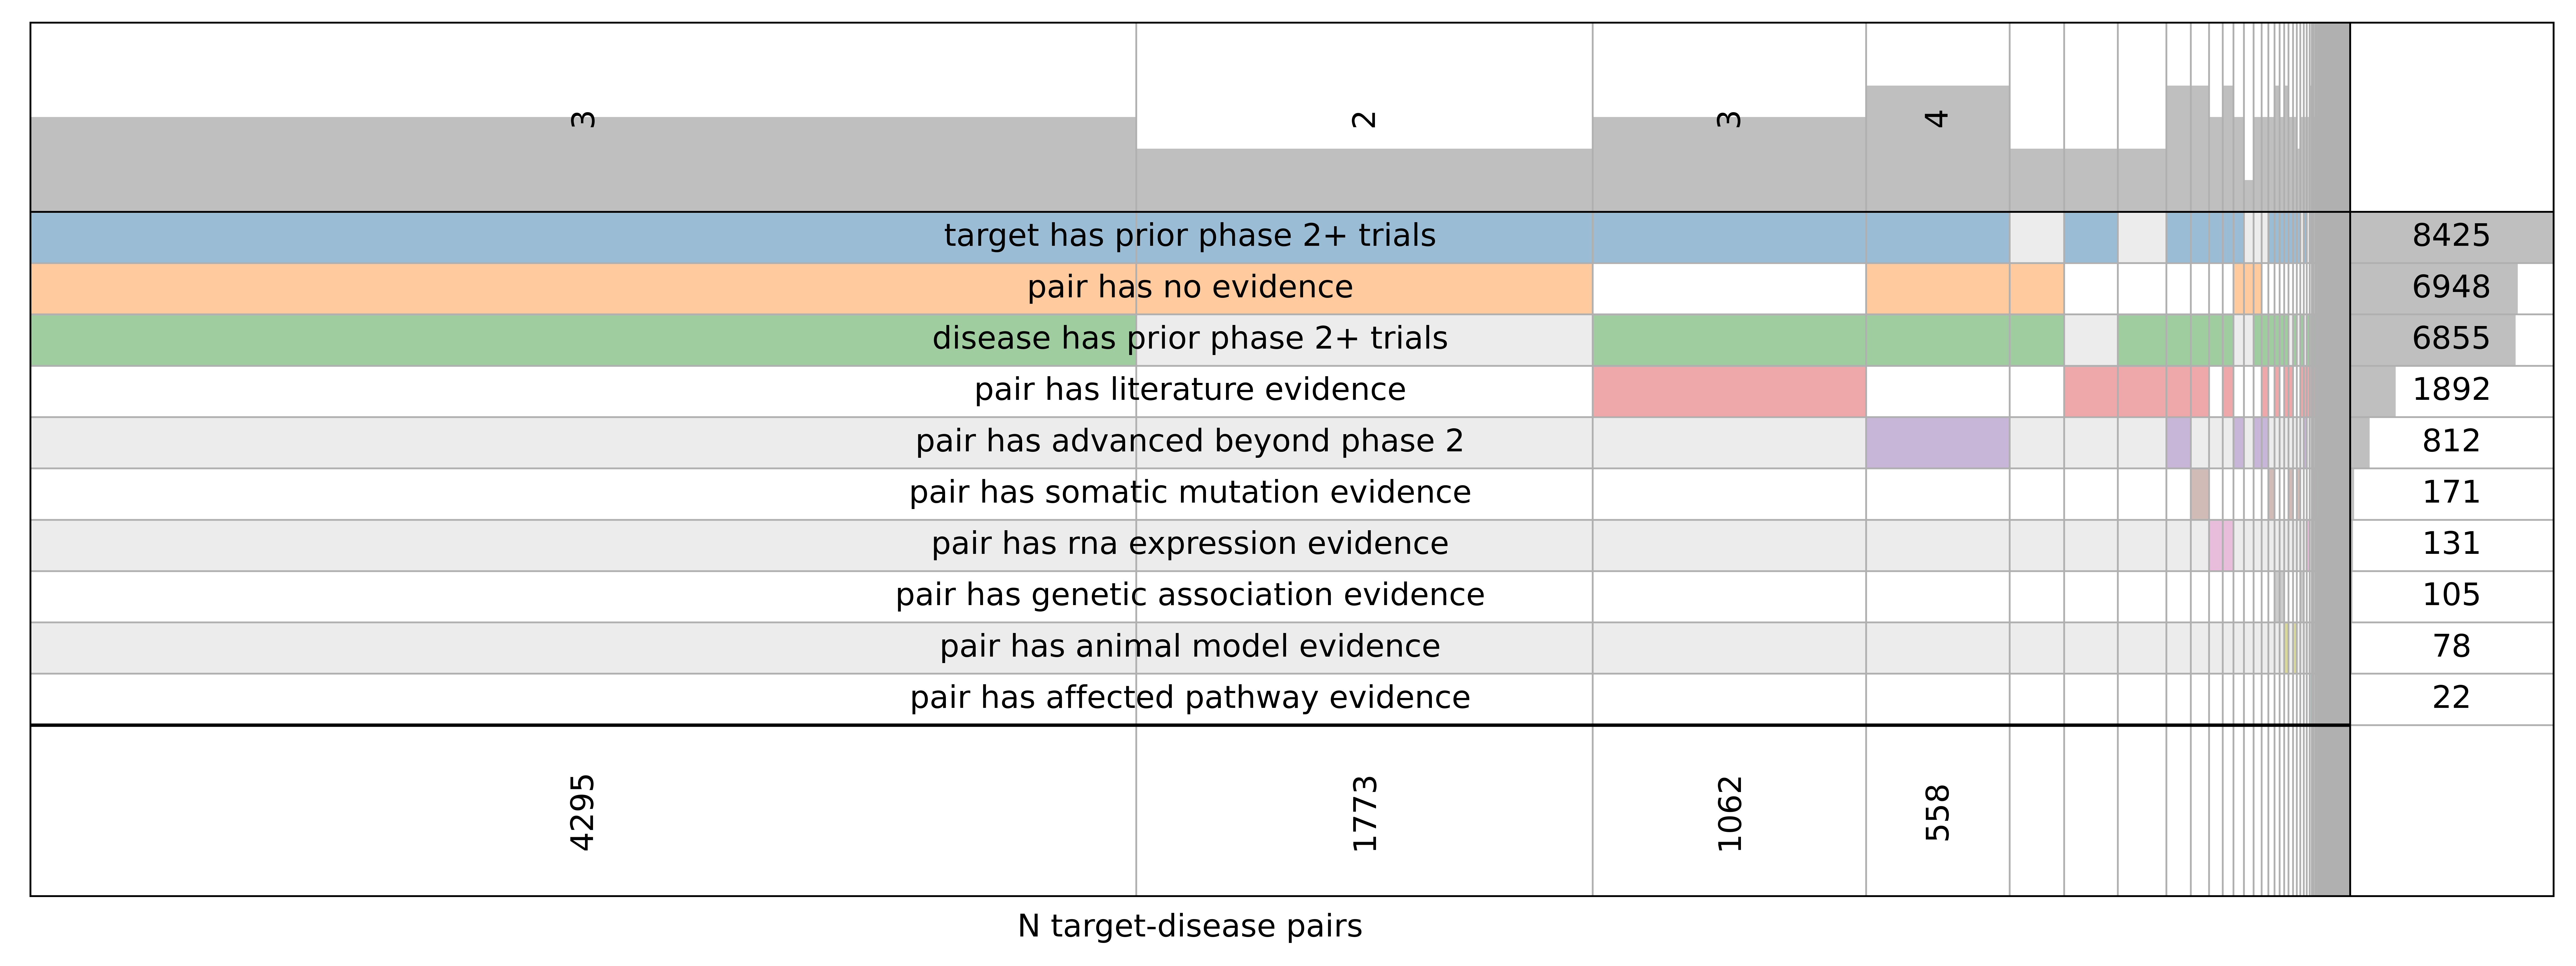

In [26]:
plt.figure(figsize=(16, 6), dpi=300)
print(
    "Evaluation dataset feature presence for TD pairs in year prior to first phase 2 trial (drawn to scale)"
)
plot = plot_feature_presence(
    evaluation_feature_presence,
    min_width_for_annotation=500,
    widths_minmax_ratio=None,
    bar_alpha=0.4,
)
plt.xlabel("N target-disease pairs")
plt.ylabel("")
plot.figure.tight_layout(pad=1.01)
if enable_result_export:
    plot.figure.savefig(str(nb.get_asset_path("feature_presence_unscaled.pdf")))
plot.figure

Evaluation dataset feature presence for TD pairs in year prior to first phase 2 trial (scaled to fit labels)


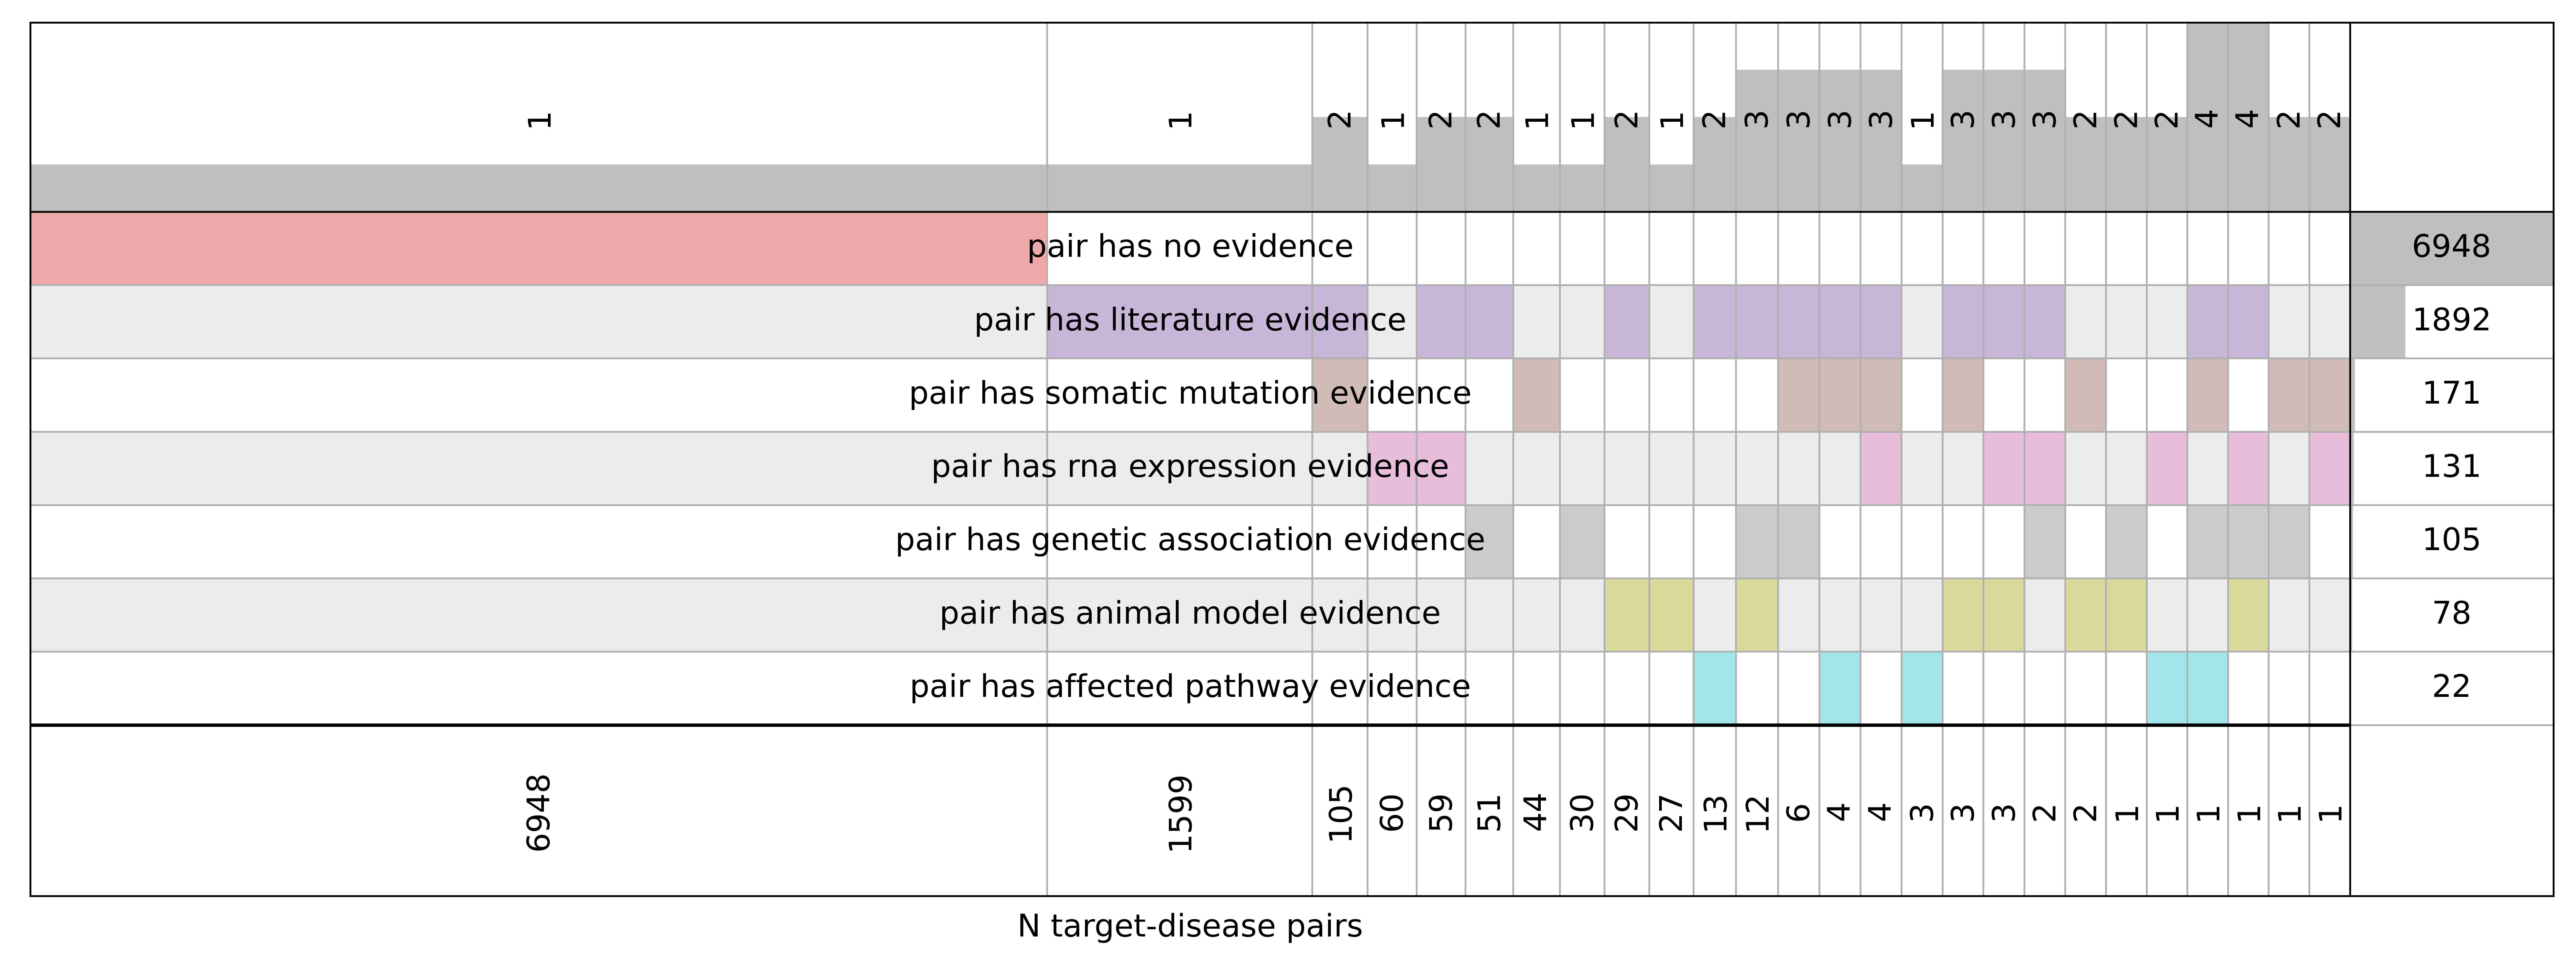

In [27]:
print(
    "Evaluation dataset feature presence for TD pairs in year prior to first phase 2 trial (scaled to fit labels)"
)
plt.figure(figsize=(16, 6), dpi=300)
plot = plot_feature_presence(
    evaluation_feature_presence.pipe(
        lambda df: df[
            ~df["feature_group"].isin(
                [
                    "target_disease__outcome",
                    "disease__phase_2",
                    "target__phase_2",
                ]
            )
        ]
    ),
    min_width_for_annotation=0,
    widths_minmax_ratio=0.04,
    bar_alpha=0.4,
)
plt.xlabel("N target-disease pairs")
plt.ylabel("")
plot.figure.tight_layout(pad=1.01)
if enable_result_export:
    plot.figure.savefig(str(nb.get_asset_path("feature_presence_scaled.pdf")))
plot.figure

In [28]:
%%capture
# Flush figures to avoid appearance in later cells
plt.show()

In [29]:
(
    pd.concat(
        [
            features.filter(regex="__clinical__")
            .rename_axis("feature", axis="columns")
            .stack()
            .rename("value")
            .reset_index(level="feature")
            .assign(split=split)
            for (split, features) in [
                ("training", training_features),
                ("evaluation", evaluation_features),
            ]
        ],
        axis=0,
        ignore_index=True,
    )
    .assign(value=lambda df: df["value"].astype(int))
    .groupby(["split", "feature", "value"])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
    .style.background_gradient(axis=None)
    .set_caption("Target-disease pair count by clinical feature value")
)

### Modeling

#### Training

In [30]:
training_dataset = nb.get_training_dataset(
    training_features.sample(frac=1, random_state=nb.SEED)
    .reset_index(drop=True)
    .pipe(assert_condition, lambda df: len(df) == len(training_features))
)
training_dataset

INFO:xrml:Fitting estimator 'gbm__all__positive'


INFO:xrml:Fitting estimator 'rdg__all__positive'
INFO:xrml:Fitting estimator 'gbm__no_time__positive'
INFO:xrml:Fitting estimator 'rdg__no_time__positive'
INFO:xrml:Fitting estimator 'gbm__no_tgc__positive'
INFO:xrml:Fitting estimator 'rdg__no_tgc__positive'
INFO:xrml:Fitting estimator 'gbm__only_genetics__positive'
INFO:xrml:Fitting estimator 'rdg__only_genetics__positive'
INFO:xrml:Fitting estimator 'gbm__all__unconstrained'
INFO:xrml:Fitting estimator 'rdg__all__unconstrained'
INFO:xrml:Fitting estimator 'lrg__all__unconstrained'
INFO:xrml:Fitting estimator 'gbm__no_time__unconstrained'
INFO:xrml:Fitting estimator 'rdg__no_time__unconstrained'
INFO:xrml:Fitting estimator 'lrg__no_time__unconstrained'
INFO:xrml:Fitting estimator 'gbm__no_tgc__unconstrained'
INFO:xrml:Fitting estimator 'rdg__no_tgc__unconstrained'
INFO:xrml:Fitting estimator 'lrg__no_tgc__unconstrained'
INFO:xrml:Fitting estimator 'gbm__only_genetics__unconstrained'
INFO:xrml:Fitting estimator 'rdg__only_genetics__unc

<xarray.Dataset>
Dimensions:      (index: 25398, features: 37, outcomes: 1, descriptors: 2,
                  folds: 1, estimators: 25, models: 25)
Coordinates:
  * index        (index) MultiIndex
  - target_id    (index) object 'ENSG00000139842' ... 'ENSG00000088832'
  - disease_id   (index) object 'EFO_0006859' 'EFO_0004718' ... 'EFO_0000272'
  * features     (features) <U55 'target_disease__genetic_association__clinge...
  * outcomes     (outcomes) <U33 'target_disease__outcome__advanced'
  * descriptors  (descriptors) <U15 'transition_year' 'feature_year'
  * folds        (folds) int64 0
  * estimators   (estimators) <U33 'gbm__all__positive' ... 'baseline__random...
  * models       (models) <U33 'gbm__all__positive' ... 'baseline__random_see...
Data variables:
    feature      (index, features) float64 nan nan nan nan ... nan 4.0 nan 8.0
    outcome      (index, outcomes) bool False False False ... False False False
    descriptor   (index, descriptors) float64 1.999e+03 1.998e+03 ... 2.008e+03
    fold         (index, folds) object 'train' 'train' ... 'train' 'train'
    estimator    (folds, estimators) object Model(slug='gbm__all__positive', ...
    model        (models) object Model(slug='gbm__all__positive', name='gbm__...
Attributes:
    outcome_type:   classification:binary
    index_columns:  ['target_id', 'disease_id']

In [31]:
evaluation_dataset = nb.get_evaluation_dataset(
    evaluation_features[training_features.columns]
    .sample(frac=1, random_state=nb.SEED)
    .reset_index(drop=True)
    .pipe(assert_condition, lambda df: len(df) == len(evaluation_features)),
    training_dataset,
)
evaluation_dataset

<xarray.Dataset>
Dimensions:      (index: 9010, features: 37, outcomes: 1, descriptors: 2,
                  models: 25, classes: 2)
Coordinates:
  * index        (index) MultiIndex
  - target_id    (index) object 'ENSG00000142173' ... 'ENSG00000101162'
  - disease_id   (index) object 'HP_0012227' 'MONDO_0044704' ... 'EFO_1000595'
  * features     (features) <U55 'target_disease__genetic_association__clinge...
  * outcomes     (outcomes) <U33 'target_disease__outcome__advanced'
  * descriptors  (descriptors) <U15 'transition_year' 'feature_year'
  * models       (models) <U33 'gbm__all__positive' ... 'baseline__random_see...
  * classes      (classes) <U8 'negative' 'positive'
Data variables:
    feature      (index, features) float64 nan nan nan nan ... nan 4.0 nan 7.0
    outcome      (index, outcomes) bool False False False ... False False False
    descriptor   (index, descriptors) int64 2020 2019 2019 ... 2021 2017 2016
    model        (models) object Model(slug='gbm__all__positive', name='gbm__...
    prediction   (index, classes, models, outcomes) float64 0.9373 ... 0.0
Attributes:
    outcome_type:   classification:binary
    index_columns:  ['target_id', 'disease_id']

#### Models

In [32]:
primary_models = nb.get_primary_models()
primary_model_colors = primary_models.set_index("model_slug")["display_color"].to_dict()
primary_rdg_model = primary_models.set_index("model_slug").loc["RDG"].iloc[0]
primary_gbm_model = primary_models.set_index("model_slug").loc["GBM-T"].iloc[0]
primary_ots_model = primary_models.set_index("model_slug").loc["OTS"].iloc[0]
primary_models

model model_slug display_color
0   rdg__no_time__positive        RDG       #1f77b4
1       rdg__all__positive      RDG-T       #7f7f7f
2    rdg__no_tgc__positive      RDG-X       #7f7f7f
3  gbm__all__unconstrained      GBM-T       #ffffff
4                 ots__all        OTS       #2ca02c

In [33]:
(
    evaluation_dataset.prediction.sel(classes="positive")
    .squeeze()
    .to_series()
    .reset_index()
    .pipe(lambda df: df[df["models"].str.contains("^gbm__|^rdg__")])
    .groupby("models")["prediction"]
    .describe(percentiles=np.arange(0.1, 1, 0.1))
)

count      mean       std       min  \
models                                                                    
gbm__all__positive                 9010.0  0.101917  0.065834  0.002551   
gbm__all__unconstrained            9010.0  0.101854  0.087965  0.001816   
gbm__no_tgc__positive              9010.0  0.200695  0.044182  0.008074   
gbm__no_tgc__unconstrained         9010.0  0.204270  0.084485  0.006548   
gbm__no_time__positive             9010.0  0.196622  0.052644  0.011084   
gbm__no_time__unconstrained        9010.0  0.185187  0.078824  0.008483   
gbm__only_genetics__positive       9010.0  0.197095  0.024210  0.140706   
gbm__only_genetics__unconstrained  9010.0  0.196919  0.025940  0.048778   
rdg__all__positive                 9010.0  0.222772  0.067945  0.046006   
rdg__all__unconstrained            9010.0  0.104415  0.066379  0.000000   
rdg__no_tgc__positive              9010.0  0.035984  0.028918  0.000000   
rdg__no_tgc__unconstrained         9010.0  0.000860  0.006406  0.000000   
rdg__no_time__positive             9010.0  0.137749  0.042021  0.028531   
rdg__no_time__unconstrained        9010.0  0.025578  0.034612  0.000000   
rdg__only_genetics__positive       9010.0  0.001351  0.015781  0.000000   
rdg__only_genetics__unconstrained  9010.0  0.000675  0.011322  0.000000   

                                        10%       20%       30%       40%  \
models                                                                      
gbm__all__positive                 0.029502  0.047615  0.059636  0.074897   
gbm__all__unconstrained            0.019779  0.032047  0.046945  0.061952   
gbm__no_tgc__positive              0.162320  0.176867  0.188977  0.194530   
gbm__no_tgc__unconstrained         0.106873  0.139913  0.160259  0.169539   
gbm__no_time__positive             0.152462  0.169144  0.178083  0.182255   
gbm__no_time__unconstrained        0.097195  0.120504  0.140550  0.160899   
gbm__only_genetics__positive       0.195063  0.195063  0.195063  0.195063   
gbm__only_genetics__unconstrained  0.195049  0.195049  0.195049  0.195049   
rdg__all__positive                 0.137454  0.161965  0.184064  0.203720   
rdg__all__unconstrained            0.018473  0.043227  0.066069  0.084182   
rdg__no_tgc__positive              0.009320  0.017299  0.021455  0.026284   
rdg__no_tgc__unconstrained         0.000000  0.000000  0.000000  0.000000   
rdg__no_time__positive             0.090194  0.108623  0.122998  0.130546   
rdg__no_time__unconstrained        0.000000  0.000000  0.003216  0.011845   
rdg__only_genetics__positive       0.000000  0.000000  0.000000  0.000000   
rdg__only_genetics__unconstrained  0.000000  0.000000  0.000000  0.000000   

                                        50%       60%       70%       80%  \
models                                                                      
gbm__all__positive                 0.084058  0.101802  0.128387  0.155082   
gbm__all__unconstrained            0.077286  0.099720  0.128491  0.160384   
gbm__no_tgc__positive              0.200932  0.208921  0.210972  0.230107   
gbm__no_tgc__unconstrained         0.184423  0.207810  0.252097  0.279835   
gbm__no_time__positive             0.195596  0.202873  0.213816  0.223331   
gbm__no_time__unconstrained        0.176638  0.189175  0.208615  0.246407   
gbm__only_genetics__positive       0.195063  0.195063  0.195063  0.195063   
gbm__only_genetics__unconstrained  0.195049  0.195049  0.195049  0.195049   
rdg__all__positive                 0.218791  0.236166  0.258566  0.280358   
rdg__all__unconstrained            0.100121  0.117717  0.138911  0.161153   
rdg__no_tgc__positive              0.031071  0.036062  0.040803  0.047455   
rdg__no_tgc__unconstrained         0.000000  0.000000  0.000000  0.000000   
rdg__no_time__positive             0.138424  0.143566  0.150796  0.159411   
rdg__no_time__unconstrained        0.018859  0.025797  0.032463  0.041584   
rdg__only_genetics__positive       0.000000  0.000000  0.000000  0

##### RDG

In [34]:
rdg_model = evaluation_dataset.model.sel(models=primary_rdg_model).item(0).estimator
rdg_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['target_disease__genetic_association__clingen',
                                                   'target_disease__genetic_association__curated',
                                                   'target_disease__genetic_association__eva',
                                                   'target_disease__genetic_association__gene2phenotype',
                                                   'target_disease__genetic_association__gene_burden',
                                                   'target_dise...
                                                     'target_disease__animal_model__impc',
                                                     'target_disease__known_drug__chembl',
                                                     'target_disease__literature__europepmc',
                                                     'target_disease__rna_expression__expression_atlas',
                                                     'target_disease__somatic_mutation__cancer_gene_census',
                                                     'target_disease__somatic_mutation__eva_somatic',
                                                     'target_disease__somatic_mutation__intogen',
                                                     'target__clinical__phase_max__reached', ...],
                                 positive=True))])

In [35]:
(
    pd.concat(
        [
            evaluation_dataset.model.sel(models=model)
            .item(0)
            .estimator[-1]
            .coef_.rename(model)
            .rename_axis("feature", axis="index")
            for model in training_dataset.models.values.tolist()
            if model.startswith("rdg__")
        ],
        axis=1,
    )
    .reset_index()
    .sort_values("rdg__all__positive", ascending=False)
    .pipe(lambda df: df[df.isnull().sum(axis=0).sort_values().index])
    .set_index("feature")
    .style.format(na_rep="", precision=4)
    .background_gradient(cmap="Blues")
    .pipe(nb.set_default_table_styles)
)

In [36]:
def plot_weights(df: pd.DataFrame) -> Plotnine:
    return (
        pn.ggplot(df, pn.aes(x="feature", y="value", fill="evidence_type"))
        + pn.geom_bar(stat="identity", alpha=0.8)
        + pn.facet_wrap("~ stat", scales="free_x", ncol=2)
        + pn.coord_flip()
        + pn.theme_minimal()
        + pn.scale_fill_cmap_d("tab10")
        + pn.labs(y="", fill="evidence type")
        + pn.theme(
            figure_size=(figure_width + 2, 5), panel_grid_major_y=pn.element_blank()
        )
    )

INFO:analysis:Saving figure to '/home/eczech/repos/clinical_advancement_paper/paper/assets/effect_sizes.pdf'
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 5 in image.
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/eczech/repos/clinical_advancement_paper/paper/assets/effect_sizes.pdf
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


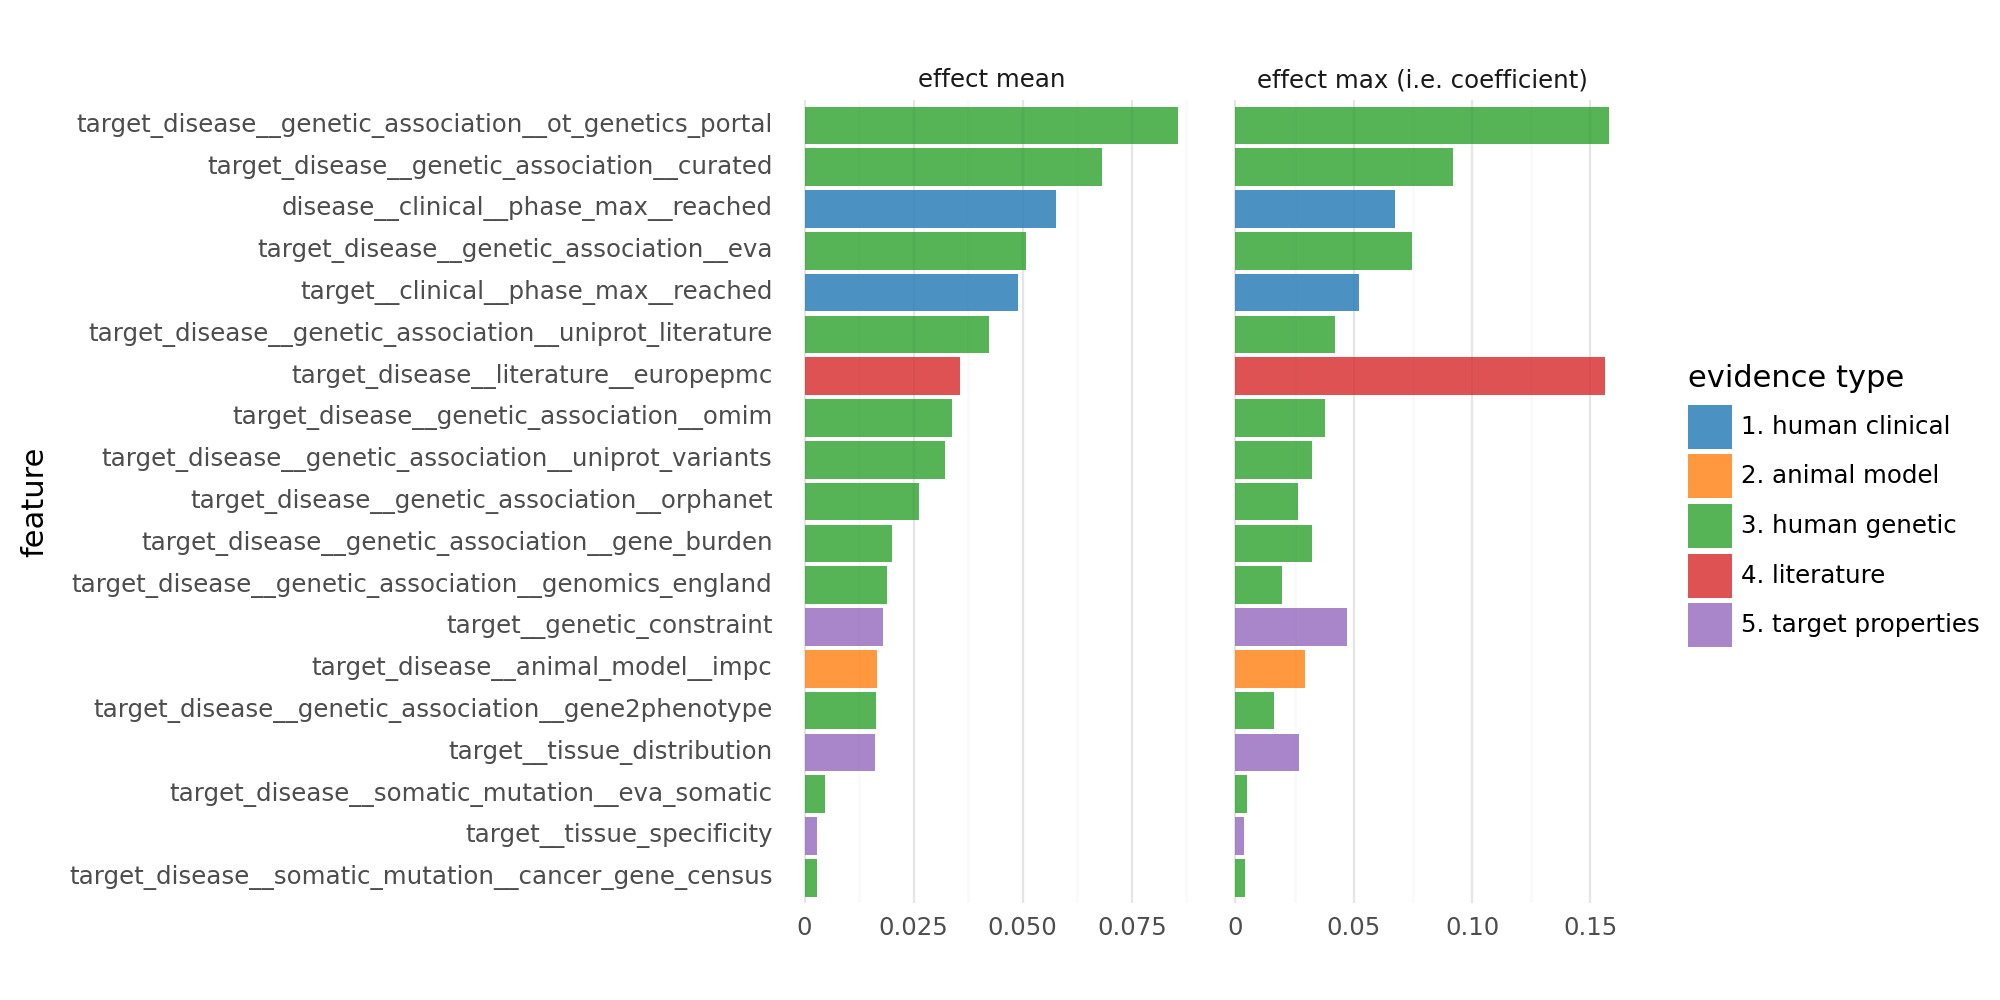

<Figure Size: (1000 x 500)>

In [37]:
(
    nb.get_ridge_regression_weights(evaluation_dataset, model=primary_rdg_model).pipe(
        lambda df: nb.save_figure("effect_sizes.pdf", enable_result_export)(
            plot_weights(df)
        )
    )
)

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


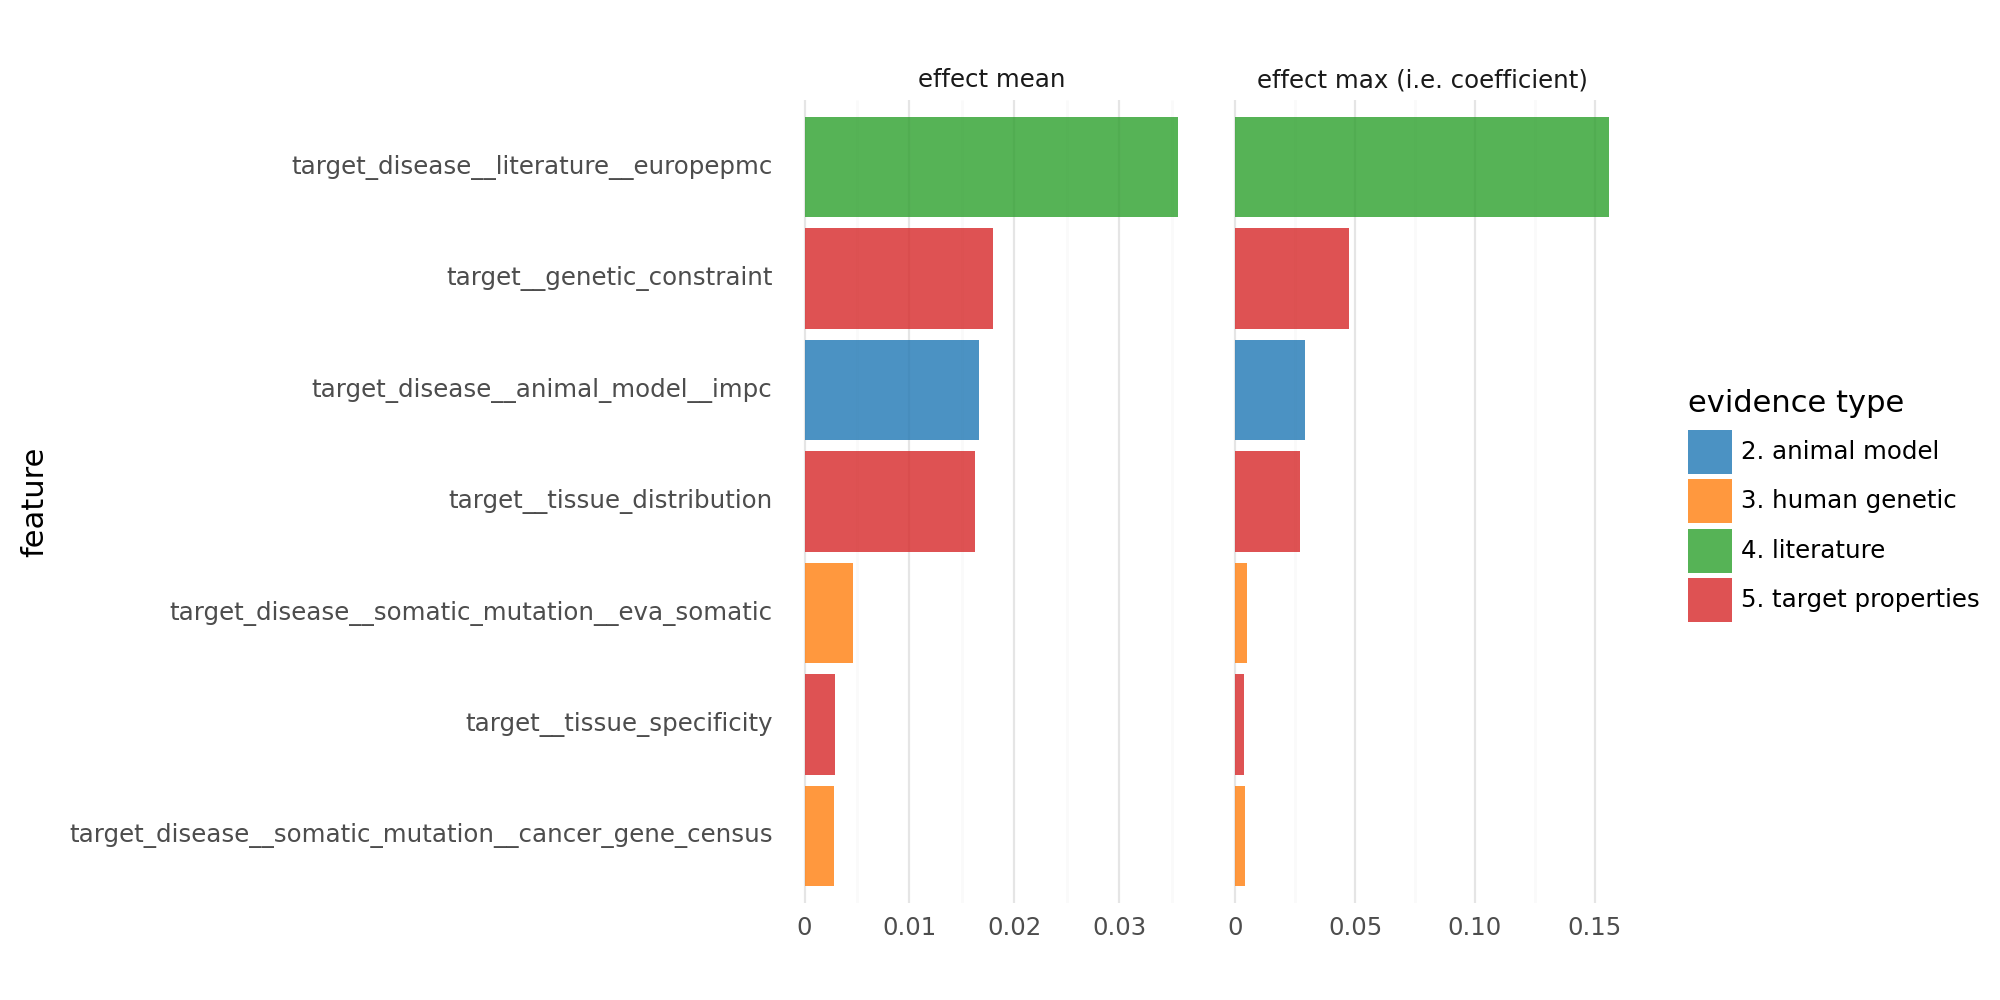

<Figure Size: (1000 x 500)>

In [38]:
(
    nb.get_ridge_regression_weights(
        evaluation_dataset, model="rdg__no_tgc__positive"
    ).pipe(plot_weights)
)

##### OTS

In [39]:
with pd.option_context("display.max_colwidth", None):
    display(
        evaluation_dataset.model.sel(models=primary_ots_model)
        .item(0)
        .estimator[-1]
        .coef_.rename_axis("feature", axis="index")
        .rename("weight")
        .sort_values()
        .reset_index()
    )

feature  weight
0          target_disease__rna_expression__expression_atlas     0.2
1                     target_disease__literature__europepmc     0.2
2                        target_disease__animal_model__impc     0.2
3                  target_disease__affected_pathway__sysbio     0.5
4              target_disease__affected_pathway__slapenrich     0.5
5                 target_disease__affected_pathway__progeny     0.5
6       target_disease__affected_pathway__cancer_biomarkers     0.5
7              target_disease__genetic_association__clingen     1.0
8      target_disease__somatic_mutation__cancer_gene_census     1.0
9                        target_disease__known_drug__chembl     1.0
10               target_disease__affected_pathway__reactome     1.0
11          target_disease__affected_pathway__crispr_screen     1.0
12                 target_disease__affected_pathway__crispr     1.0
13    target_disease__genetic_association__uniprot_variants     1.0
14  target_disease__genetic_association__uniprot_literature     1.0
15  target_disease__genetic_association__ot_genetics_portal     1.0
16            target_disease__genetic_association__orphanet     1.0
17                target_disease__genetic_association__omim     1.0
18    target_disease__genetic_association__genomics_england     1.0
19         target_disease__genetic_association__gene_burden     1.0
20      target_disease__genetic_association__gene2phenotype     1.0
21                 target_disease__genetic_association__eva     1.0
22             target_disease__genetic_association__curated     1.0
23            target_disease__somatic_mutation__eva_somatic     1.0
24                target_disease__somatic_mutation__intogen     1.0

##### GBM

In [40]:
gbm_name = "gbm__all__unconstrained"
gbm_model = evaluation_dataset.model.sel(models=gbm_name).item(0).estimator
gbm_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['target_disease__genetic_association__clingen',
                                                   'target_disease__genetic_association__curated',
                                                   'target_disease__genetic_association__eva',
                                                   'target_disease__genetic_association__gene2phenotype',
                                                   'target_disease__genetic_association__gene_burden',
                                                   'target_dise...
                                                   'target_disease__literature__europepmc',
                                                   'target_disease__rna_expression__expression_atlas',
                                                   'target_disease__somatic_mutation__cancer_gene_census',
                                                   'target_disease__somatic_mutation__eva_somatic',
                                                   'target_disease__somatic_mutation__intogen',
                                                   'target__clinical__phase_max__reached', ...])],
                                   verbose_feature_names_out=False)),
                ('lgbmclassifier', LGBMClassifier(random_state=0))])

/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/shap/explainers/_tree.py:353: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/shap/plots/_beeswarm.py:664: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered


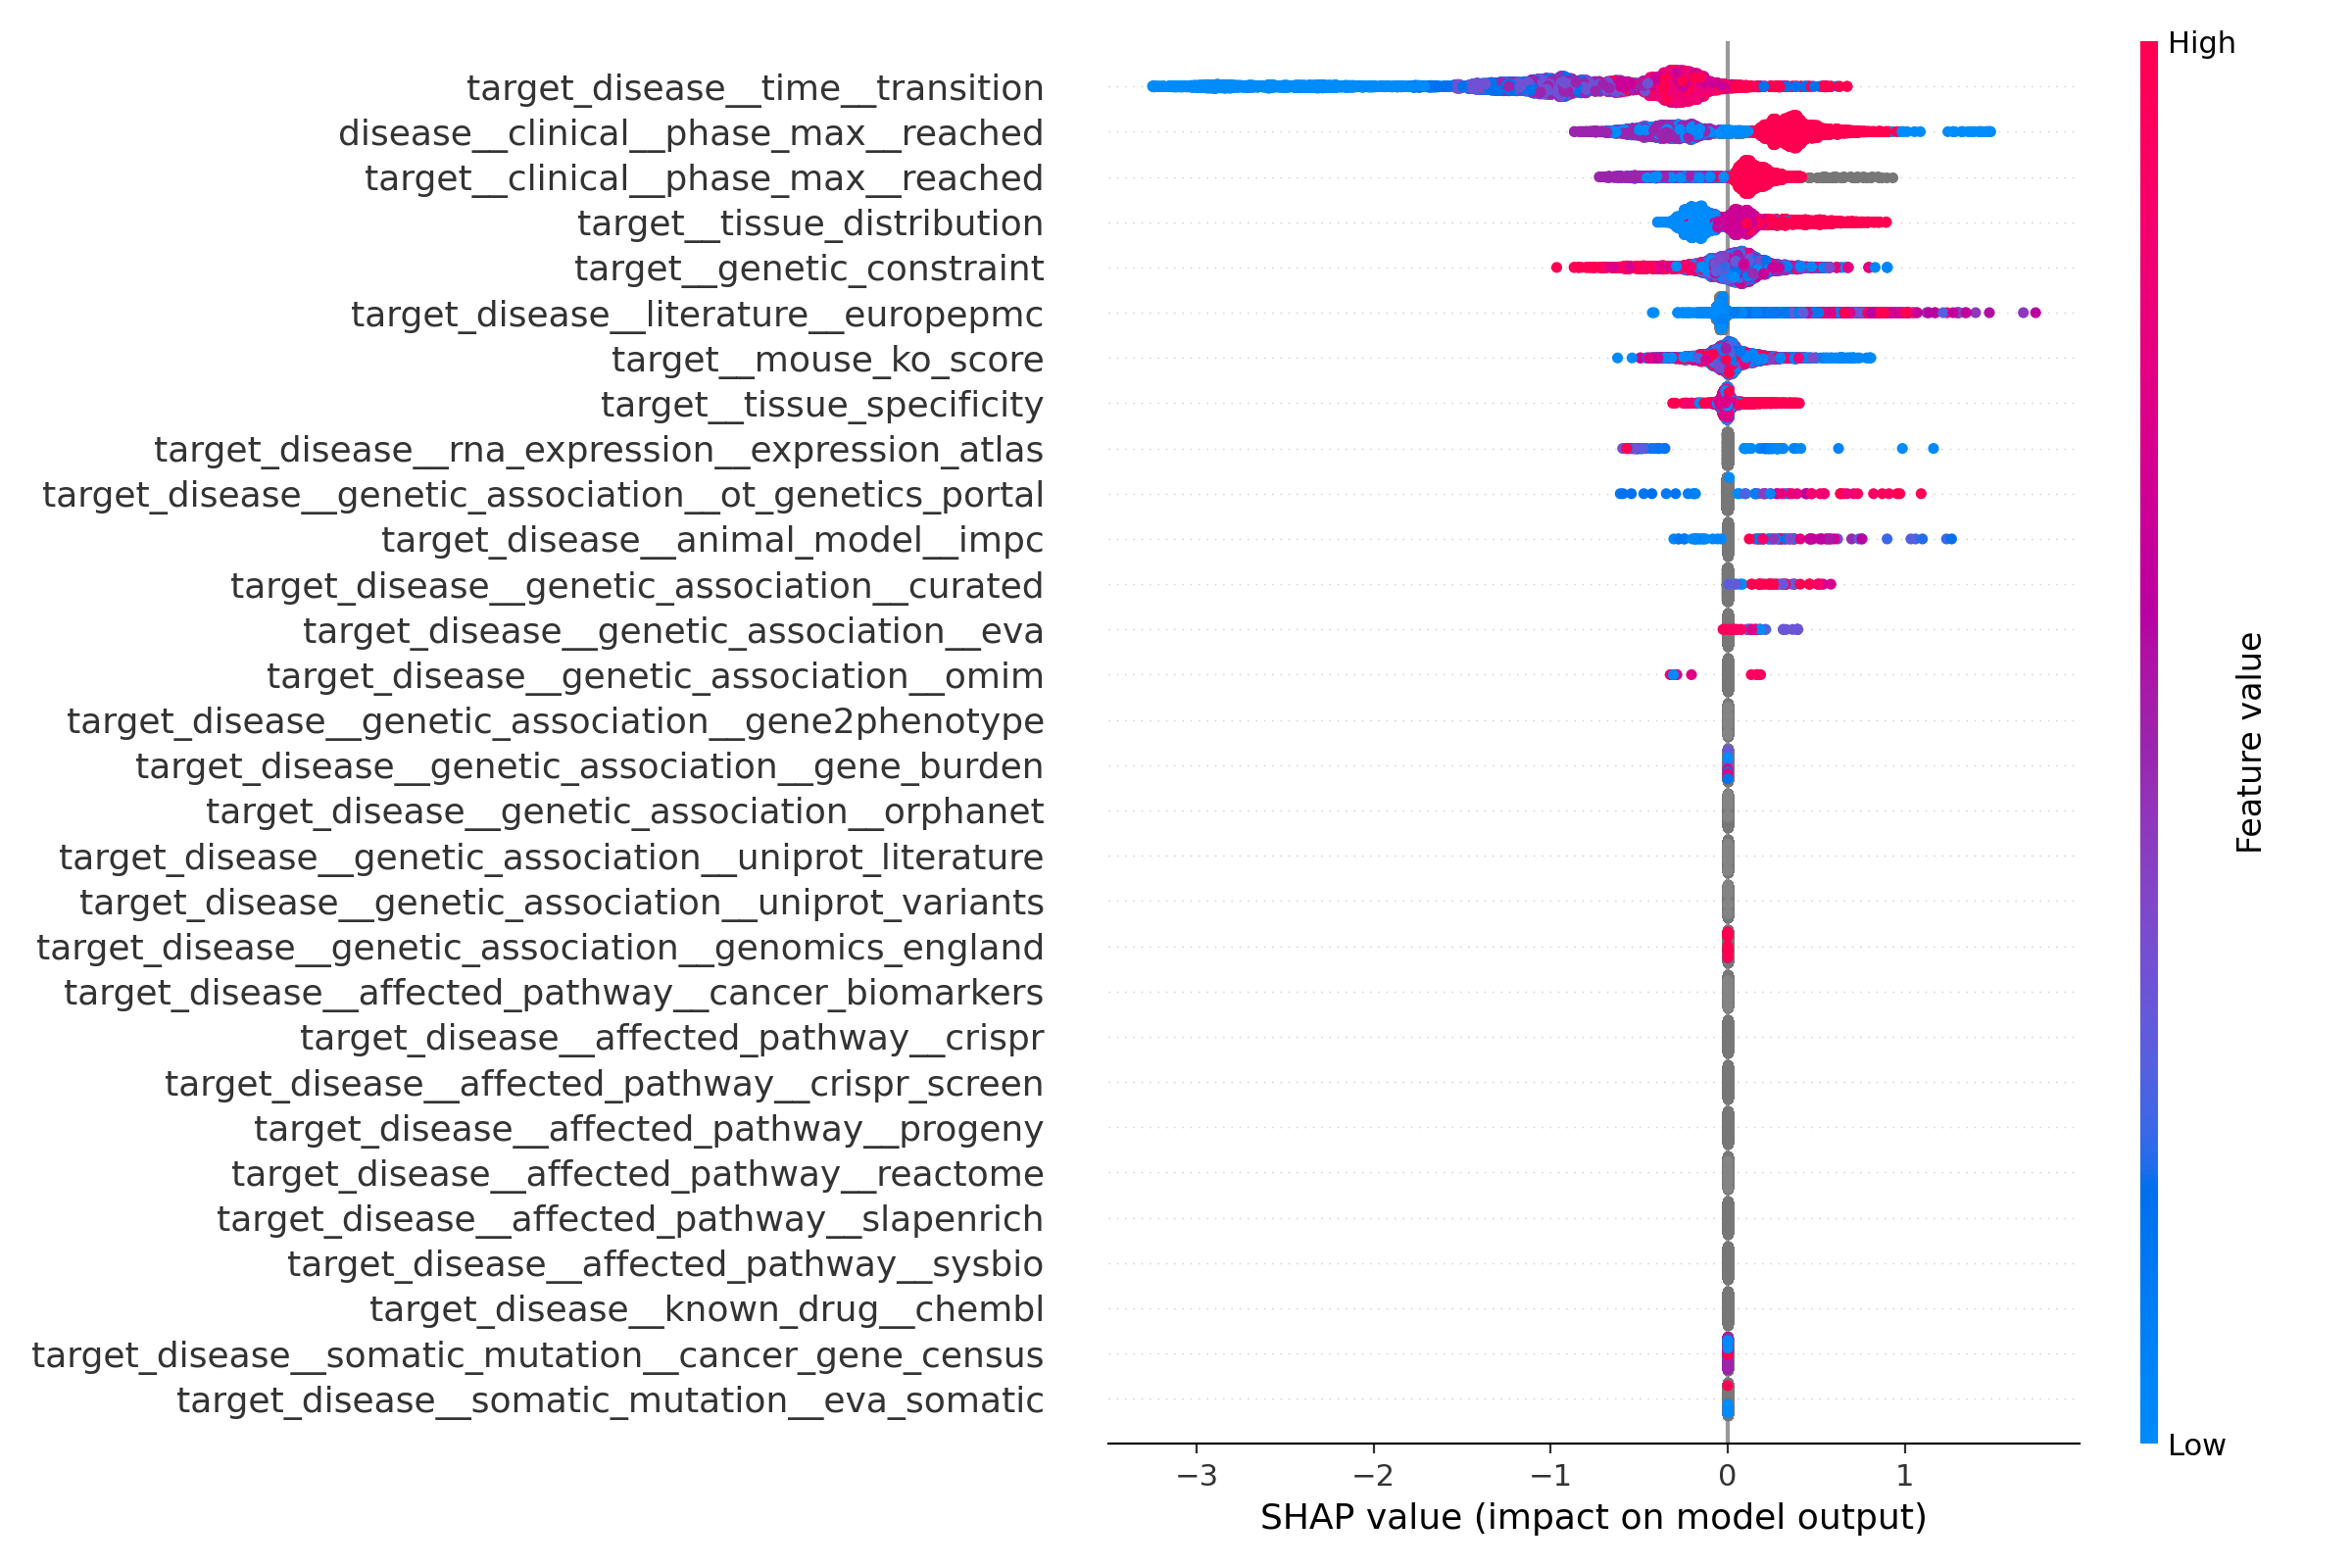

In [41]:
explainer = shap.TreeExplainer(gbm_model[-1])
shap_feature_values = (
    evaluation_dataset[["feature", "prediction"]]
    .sel(models=gbm_name, classes="positive")
    .squeeze()
    .feature.to_series()
    .unstack()[gbm_model[-1].feature_name_]
)
shap_values = explainer.shap_values(shap_feature_values)
shap.summary_plot(
    shap_values[1], shap_feature_values, plot_size=(12, 8), max_display=30
)

#### Performance

##### Classification metrics

In [42]:
classification_metrics = nb.get_classification_metrics_by_therapeutic_area(
    evaluation_dataset, therapeutic_areas=disease_therapeutic_areas.toPandas()
)
classification_metrics.head()

INFO:analysis:Skipping therapeutic area 'measurement' with only one outcome
INFO:analysis:Skipping therapeutic area 'injury, poisoning or other complication' with only one outcome
INFO:analysis:Skipping therapeutic area 'disorder of ear' with only one outcome


scores                                                                                              n_samples  \
outcomes                          models                 therapeutic_area_id therapeutic_area_name              
target_disease__outcome__advanced gbm__all__positive     ALL_0               all                       9010.0   
                                  rdg__all__positive     ALL_0               all                       9010.0   
                                  gbm__no_time__positive ALL_0               all                       9010.0   
                                  rdg__no_time__positive ALL_0               all                       9010.0   
                                  gbm__no_tgc__positive  ALL_0               all                       9010.0   

scores                                                                                              n_positives  \
outcomes                          models                 therapeutic_area_id therapeutic_area_name                
target_disease__outcome__advanced gbm__all__positive     ALL_0               all                          812.0   
                                  rdg__all__positive     ALL_0               all                          812.0   
                                  gbm__no_time__positive ALL_0               all                          812.0   
                                  rdg__no_time__positive ALL_0               all                          812.0   
                                  gbm__no_tgc__positive  ALL_0               all                          812.0   

scores                                                                                               balance  \
outcomes                          models                 therapeutic_area_id therapeutic_area_name             
target_disease__outcome__advanced gbm__all__positive     ALL_0               all                    0.090122   
                                  rdg__all__positive     ALL_0               all                    0.090122   
                                  gbm__no_time__positive ALL_0               all                    0.090122   
                                  rdg__no_time__positive ALL_0               all                    0.090122   
                                  gbm__no_tgc__positive  ALL_0               all                    0.090122   

scores                                                                                              precision  \
outcomes                          models                 therapeutic_area_id therapeutic_area_name              
target_disease__outcome__advanced gbm__all__positive     ALL_0               all                     0.428571   
                                  rdg__all__positive     ALL_0               all                     0.470588   
                                  gbm__no_time__positive ALL_0               all                     0.310345   
                                  rdg__no_time__positive ALL_0               all                     0.400000   
                                  gbm__no_tgc__positive  ALL_0               all                     0.000000   

scores                                                                                                recall  \
outcomes                          models                 therapeutic_area_id therapeutic_area_name             
target_disease__outcome__advanced gbm__all__positive     ALL_0               all                    0.003695   
                                  rdg__all__positive     ALL_0               all                    0.009852   
                                  gbm__no_time__positive ALL_0               all                    0.011084   
                                  rdg__no_time__positive ALL_0               all                    0.002463   
                                  gbm__no_tgc__positive  ALL_0               all                    0.000000   

scores                                  

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


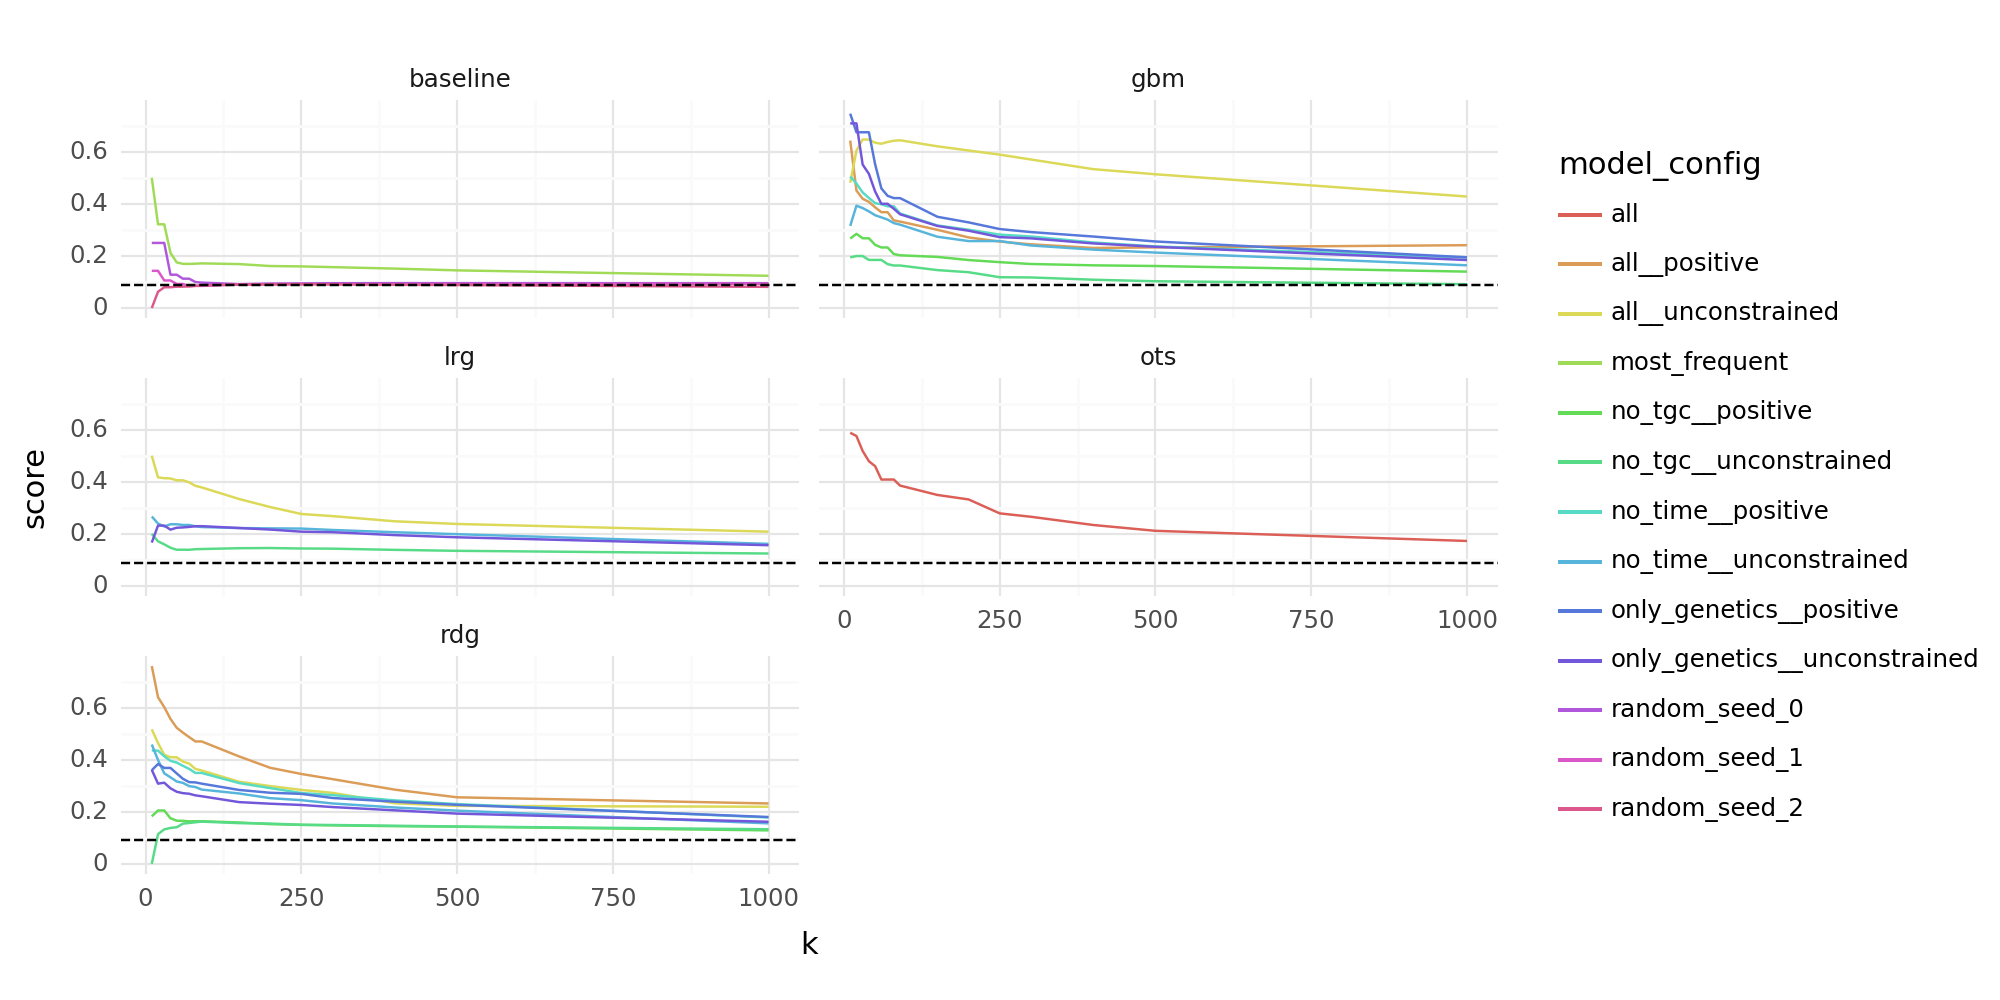

<Figure Size: (1000 x 500)>

In [43]:
(
    classification_metrics.pipe(
        lambda df: df[df.index.get_level_values("therapeutic_area_name") == "all"]
    )
    .droplevel("therapeutic_area_id", axis="index")
    .pipe(
        apply,
        lambda df: display(
            df[[c for c in df if "@" not in c or int(c.split("@")[1]) in [10, 30, 50]]]
            .sort_values("roc_auc", ascending=False)
            .style.format(precision=4)
            .format(precision=0, subset=["n_samples", "n_positives"])
            .background_gradient()
            .set_caption("Classifier metrics")
        ),
    )
    .set_index("balance", append=True)
    .filter(regex="^average_precision@")
    .stack()
    .rename("score")
    .reset_index()
    .assign(k=lambda df: df["scores"].str.split("@").str[1].astype(int))
    .assign(model_algorithm=lambda df: df["models"].str.split("__").str[0])
    .assign(model_config=lambda df: df["models"].str.split("__").str[1:].str.join("__"))
    .pipe(
        lambda df: (
            pn.ggplot(
                df,
                pn.aes(
                    x="k",
                    y="score",
                    fill="model_config",
                    color="model_config",
                    group="models",
                ),
            )
            + pn.geom_line()
            + pn.geom_hline(yintercept=df["balance"].iloc[0], linetype="dashed")
            + pn.facet_wrap("~model_algorithm", ncol=2)
            + pn.theme_minimal()
            + pn.theme(figure_size=(10, 5))
        )
    )
)

##### Feature relative risk

In [44]:
primary_benchmarks = nb.get_primary_benchmarks()
primary_benchmarks

benchmark benchmark_slug benchmark_disp  \
0                omim           OMIM           OMIM   
1                 eva            EVA    EVA/ClinVar   
2  ot_genetics_portal            OTG       OTG/GWAS   

                                             feature  
0          target_disease__genetic_association__omim  
1           target_disease__genetic_association__eva  
2  target_disease__genetic_association__ot_geneti...

In [45]:
relative_risk_by_feature = nb.enrich_feature_relative_risk(
    relative_risk=nb.get_feature_relative_risk(evaluation_dataset),
    primary_models=primary_models,
    primary_benchmarks=primary_benchmarks,
)
relative_risk_by_feature.head()

method  fraction_control  \
0  target_disease__model__gbm__all__unconstrained...          0.087963   
1  target_disease__model__gbm__all__unconstrained...          0.085068   
2  target_disease__model__gbm__all__unconstrained...          0.084400   
3  target_disease__model__gbm__all__unconstrained...          0.087175   
4  target_disease__model__gbm__all__unconstrained...          0.081050   

   fraction_exposed  n_control  n_exposed  n_exposed_true  n_total  \
0          0.758621     8981.0       29.0            22.0   9010.0   
1          0.684211     8934.0       76.0            52.0   9010.0   
2          0.600000     8910.0      100.0            60.0   9010.0   
3          0.607843     8959.0       51.0            31.0   9010.0   
4          0.408000     8760.0      250.0           102.0   9010.0   

   relative_risk  relative_risk_high  relative_risk_low  \
0       8.624269           10.336800           7.195458   
1       8.043075            9.254627           6.990131   
2       7.109043            8.226982           6.143016   
3       6.972685            8.460091           5.746786   
4       5.033915            5.782167           4.382493   

                model_name model_slug  is_model_feature  \
0  gbm__all__unconstrained      GBM-T              True   
1  gbm__all__unconstrained      GBM-T              True   
2  gbm__all__unconstrained      GBM-T              True   
3  gbm__all__unconstrained      GBM-T              True   
4  gbm__all__unconstrained      GBM-T              True   

   is_primary_model_feature benchmark_name benchmark_slug benchmark_disp  \
0                      True            NaN            NaN            NaN   
1                      True            NaN            NaN            NaN   
2                      True            NaN            NaN            NaN   
3                      True            NaN            NaN            NaN   
4                      True            NaN            NaN            NaN   

   is_primary_benchmark_feature  limit  
0                         False     25  
1                         False     75  
2                         False    100  
3                         False     50  
4                         False    250

INFO:analysis:Saving figure to '/home/eczech/repos/clinical_advancement_paper/paper/assets/relative_risk_core_features.pdf'
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/eczech/repos/clinical_advancement_paper/paper/assets/relative_risk_core_features.pdf


INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


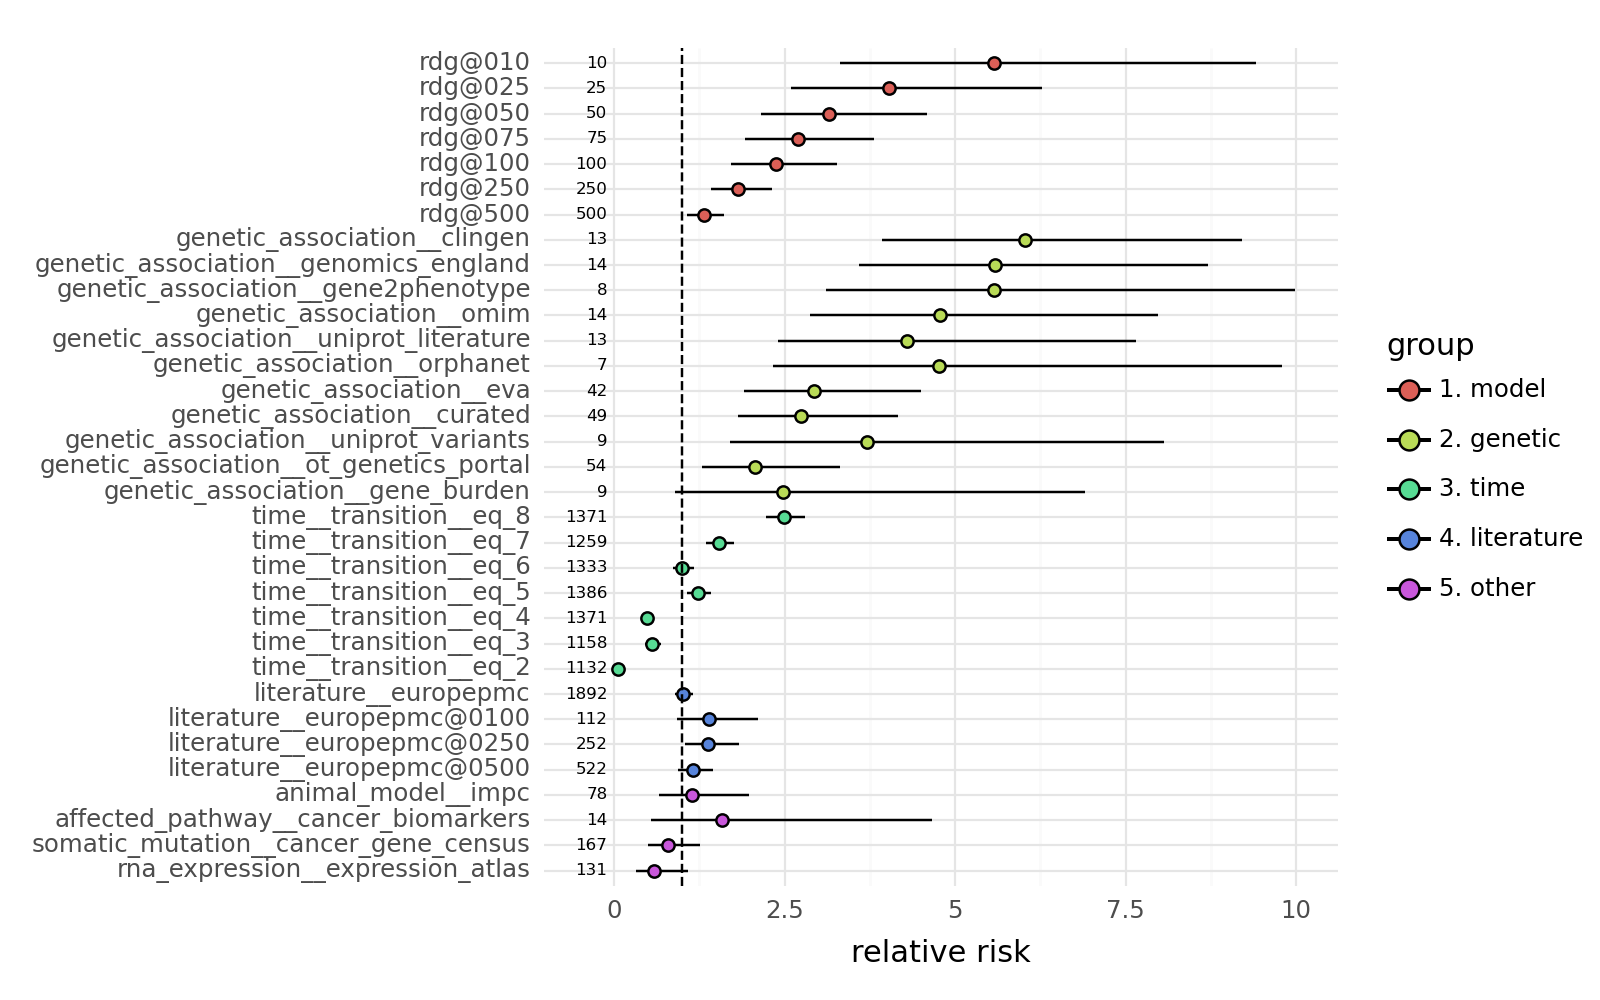

<Figure Size: (800 x 500)>

INFO:analysis:Saving figure to '/home/eczech/repos/clinical_advancement_paper/paper/assets/relative_risk_static_features.pdf'
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 6 in image.
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/eczech/repos/clinical_advancement_paper/paper/assets/relative_risk_static_features.pdf
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


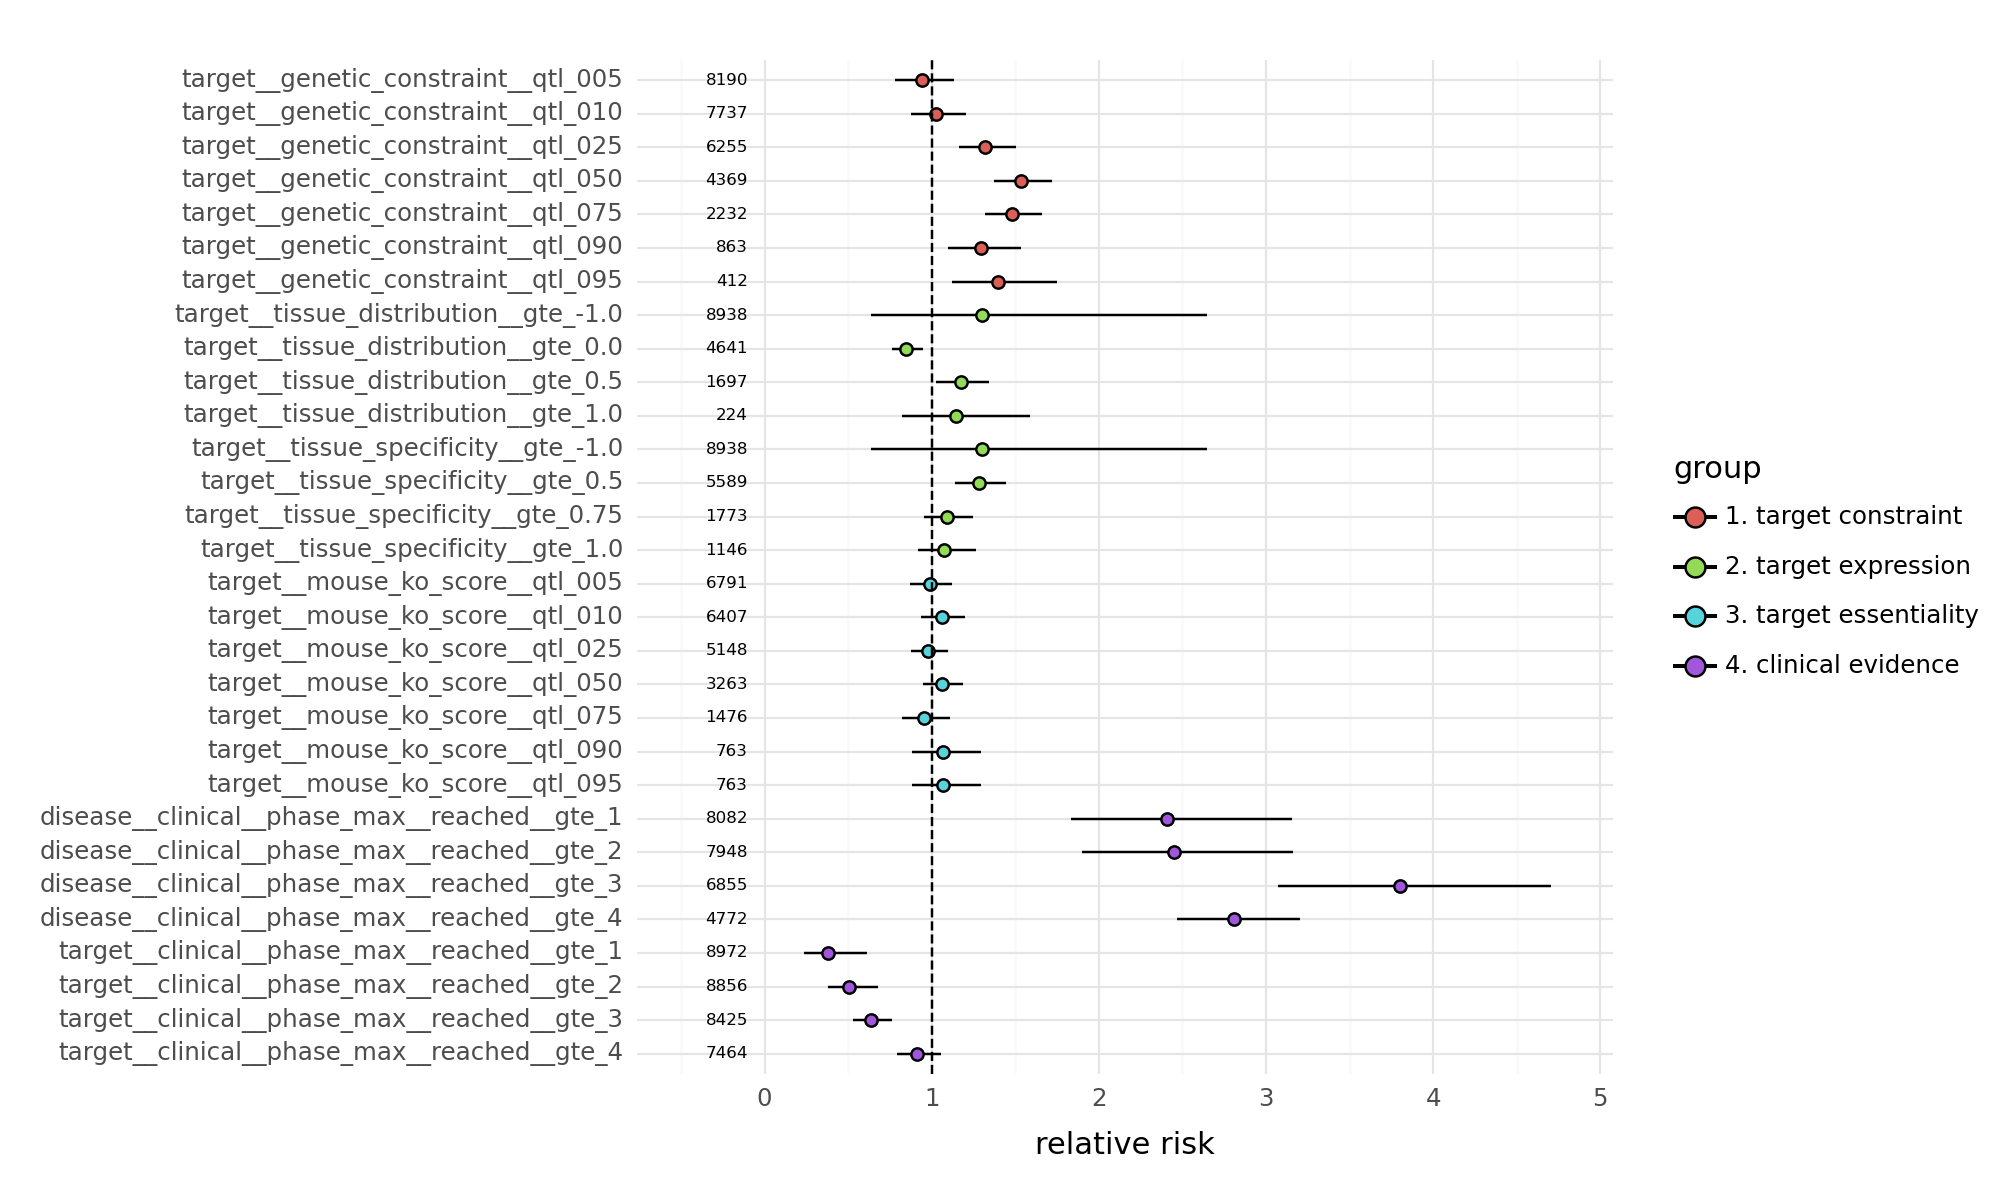

<Figure Size: (1000 x 600)>

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


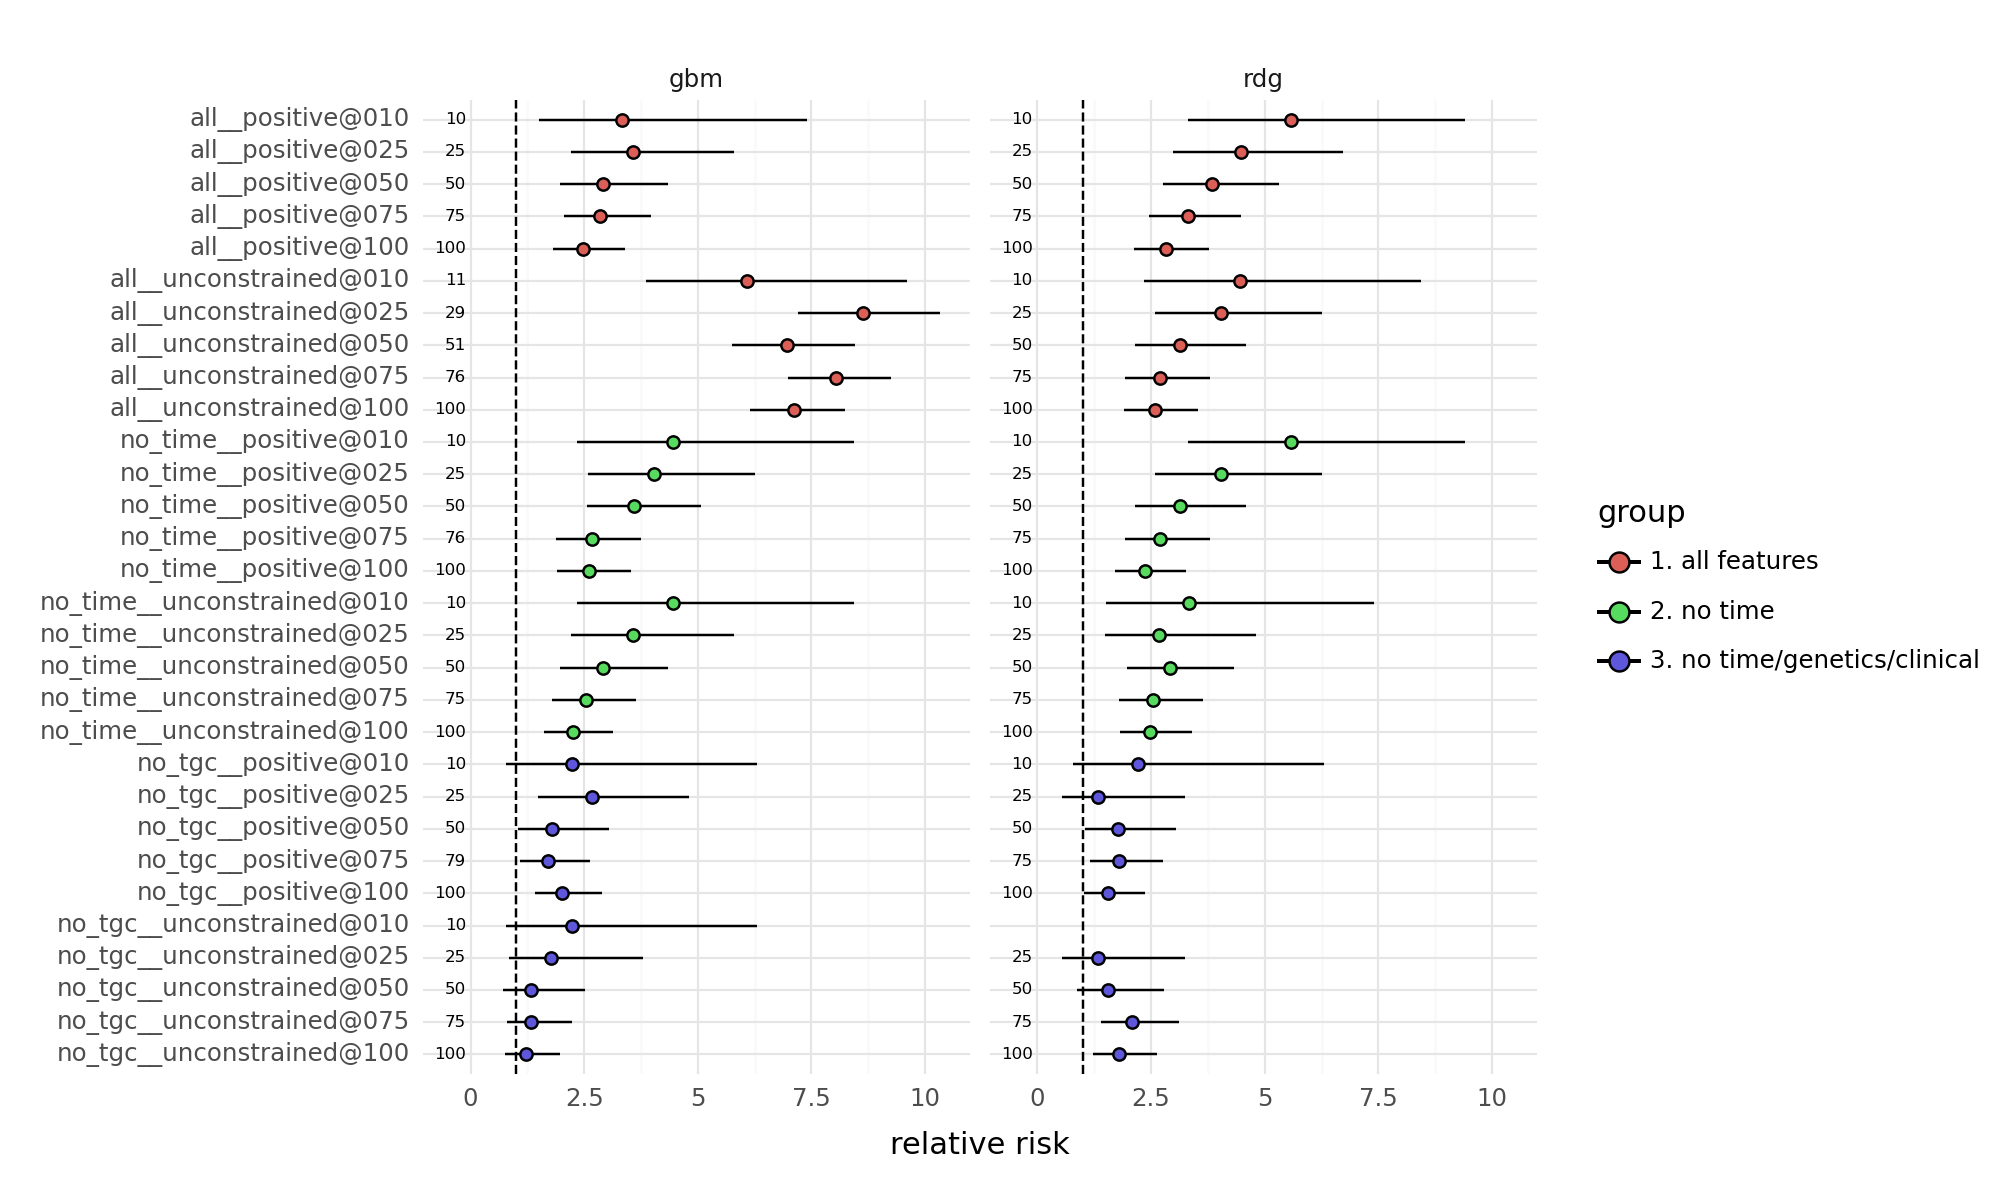

<Figure Size: (1000 x 600)>

In [46]:
def _plot_feature_relative_risk(df):
    return (
        pn.ggplot(
            df.dropna(subset=["relative_risk_low", "relative_risk_high"]).assign(
                label=lambda df: df["n_exposed"].astype(int).astype(str)
            ),
            pn.aes(
                x="method",
                y="relative_risk",
                ymin="relative_risk_low",
                ymax="relative_risk_high",
                fill="method_group",
            ),
        )
        + pn.geom_text(mapping=pn.aes(y=-0.1, label="label"), size=6, ha="right")
        + pn.geom_pointrange()
        + pn.scale_y_continuous(limits=(-0.5, df["relative_risk_high"].max() + 0.1))
        + pn.geom_hline(yintercept=1, linetype="dashed")
        + pn.labs(y="relative risk", x="", fill="group")
        + pn.coord_flip()
    )


def plot_feature_relative_risk():
    groupings = nb.prepare_relative_risk_by_feature(relative_risk_by_feature)

    display(
        nb.save_figure("relative_risk_core_features.pdf", enable_result_export)(
            _plot_feature_relative_risk(groupings["core"])
            + pn.theme_minimal()
            + pn.theme(figure_size=(figure_width, 5))
        )
    )

    display(
        nb.save_figure("relative_risk_static_features.pdf", enable_result_export)(
            _plot_feature_relative_risk(groupings["static"])
            + pn.theme_minimal()
            + pn.theme(figure_size=(figure_width + 2, 6))
        )
    )

    display(
        _plot_feature_relative_risk(groupings["model"])
        + pn.facet_wrap("~ model_group", scales="free_x", nrow=1)
        + pn.theme_minimal()
        + pn.theme(figure_size=(figure_width + 2, 6))
    )


plot_feature_relative_risk()

##### Therapeutic area selection

In [47]:
therapeutic_area_info = (
    feature_statistics.unstack("split")
    .reorder_levels(["split", "statistic"], axis="columns")["evaluation"]
    .filter(items=["n_diseases", "n_pairs", "n_pairs_with_evidence"])
    .reset_index()
    .sort_values("n_diseases", ascending=False)
    .reset_index(drop=True)
    .assign(size_rank=lambda df: df["n_diseases"].rank(ascending=False).astype(int))
    .assign(
        is_secondary=lambda df: ~df["therapeutic_area_name"].str.contains(
            "biological.*process|pregnancy|poisoning|procedure|animal|infectious"
        )
    )
    .assign(
        is_primary=lambda df: (
            df["is_secondary"] & (df["n_pairs_with_evidence"] >= 100)
        )
    )
)
primary_therapeutic_areas = (
    therapeutic_area_info.query("is_primary")["therapeutic_area_name"].unique().tolist()
)
(
    therapeutic_area_info.style.format(
        precision=0, subset=["n_diseases", "n_pairs", "n_pairs_with_evidence"]
    ).set_caption("Therapeutic area statistics")
)

In [48]:
(therapeutic_area_info.pipe(lambda df: df[df["is_primary"]]).describe())

statistic   n_diseases      n_pairs  n_pairs_with_evidence  size_rank
count        14.000000    14.000000              14.000000  14.000000
mean        206.500000  1795.642857             436.000000   8.000000
std         264.302784  2262.949186             533.072805   4.803845
min          62.000000   561.000000             121.000000   1.000000
25%          89.750000   672.250000             179.250000   4.250000
50%         114.500000   986.000000             266.500000   8.000000
75%         184.000000  1465.500000             356.750000  11.750000
max        1075.000000  9010.000000            2062.000000  16.000000

##### Therapeutic area relative risk 

In [49]:
relative_risk_by_ta_raw = nb.get_relative_risk_by_therapuetic_area(
    evaluation_dataset,
    disease_therapeutic_areas.toPandas(),
    model_names=None,
    model_limits=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
).pipe(
    nb.enrich_feature_relative_risk,
    primary_models=primary_models,
    primary_benchmarks=primary_benchmarks,
)
relative_risk_by_ta_raw.info()
relative_risk_by_ta_raw.head()

INFO:analysis:Skipping TA 'measurement'; n_rows=1
INFO:analysis:Skipping TA 'medical procedure'; n_rows=0
INFO:analysis:Skipping TA 'animal disease'; n_rows=0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   method                        4920 non-null   object 
 1   fraction_control              4920 non-null   float64
 2   fraction_exposed              4920 non-null   float64
 3   n_control                     4920 non-null   float64
 4   n_exposed                     4920 non-null   float64
 5   n_exposed_true                4920 non-null   float64
 6   n_total                       4920 non-null   float64
 7   relative_risk                 4732 non-null   float64
 8   relative_risk_high            4425 non-null   float64
 9   relative_risk_low             4357 non-null   float64
 10  therapeutic_area_id           4920 non-null   object 
 11  therapeutic_area_name         4920 non-null   object 
 12  model_name                    3732 non-null   object 
 13  mod

method  fraction_control  \
0  target_disease__model__gbm__all__unconstrained...          0.088553   
1  target_disease__model__gbm__all__unconstrained...          0.085264   
2  target_disease__model__gbm__all__unconstrained...          0.084882   
3  target_disease__model__gbm__all__unconstrained...          0.087973   
4  target_disease__model__gbm__all__unconstrained...          0.084529   

   fraction_exposed  n_control  n_exposed  n_exposed_true  n_total  \
0          0.761905     8989.0       21.0            16.0   9010.0   
1          0.684932     8937.0       73.0            50.0   9010.0   
2          0.675000     8930.0       80.0            54.0   9010.0   
3          0.733333     8980.0       30.0            22.0   9010.0   
4          0.644444     8920.0       90.0            58.0   9010.0   

   relative_risk  relative_risk_high  relative_risk_low  ...  \
0       8.603972           10.595742           6.986612  ...   
1       8.033114            9.263092           6.966455  ...   
2       7.952177            9.145537           6.914533  ...   
3       8.335865           10.075306           6.896728  ...   
4       7.623932            8.778061           6.621546  ...   

  therapeutic_area_name               model_name model_slug is_model_feature  \
0                   all  gbm__all__unconstrained      GBM-T             True   
1                   all  gbm__all__unconstrained      GBM-T             True   
2                   all  gbm__all__unconstrained      GBM-T             True   
3                   all  gbm__all__unconstrained      GBM-T             True   
4                   all  gbm__all__unconstrained      GBM-T             True   

   is_primary_model_feature  benchmark_name benchmark_slug benchmark_disp  \
0                      True             NaN            NaN            NaN   
1                      True             NaN            NaN            NaN   
2                      True             NaN            NaN            NaN   
3                      True             NaN            NaN            NaN   
4                      True             NaN            NaN            NaN   

  is_primary_benchmark_feature  limit  
0                        False     20  
1                        False     70  
2                        False     80  
3                        False     30  
4                        False     90  

[5 rows x 21 columns]

In [50]:
relative_risk_by_ta = nb.prepare_relative_risk_by_therapeutic_area(
    relative_risk_by_ta_raw, primary_therapeutic_areas=primary_therapeutic_areas
)

INFO:analysis:Computing RR means and p-values for TAs:
cardiovascular disease
immune system disease
nervous system disease
endocrine system disease
hematologic disease
urinary system disease
gastrointestinal disease
integumentary system disease
cancer or benign tumor
musculoskeletal or connective tissue disease
respiratory or thoracic disease
reproductive system or breast disease
genetic, familial or congenital disease
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/scipy/stats/_morestats.py:3351: UserWarning: Sample size too small for normal approximation.


In [51]:
(
    relative_risk_by_ta.pipe(
        lambda df: df[
            df["is_primary_model_feature"] | df["is_primary_benchmark_feature"]
        ]
    ).pipe(nb.display_relative_risk_by_therapeutic_area, limits=[10, 20, 30, 50, 100])
)

INFO:analysis:Saving figure to '/home/eczech/repos/clinical_advancement_paper/paper/assets/relative_risk_mean_across_ta.pdf'
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 3 in image.
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/eczech/repos/clinical_advancement_paper/paper/assets/relative_risk_mean_across_ta.pdf


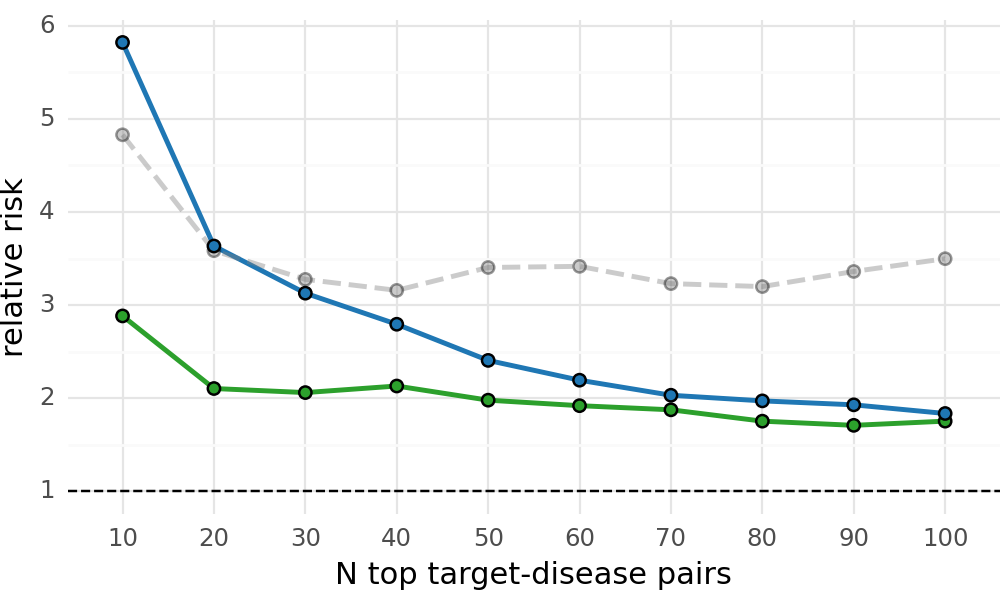

<Figure Size: (500 x 300)>

In [52]:
# fmt: off
(
    relative_risk_by_ta
    .pipe(lambda df: nb.save_figure("relative_risk_mean_across_ta.pdf", enable_result_export)(
        (
            df
            .pipe(lambda df: df[df["therapeutic_area_name"] == "average"])
            .pipe(lambda df: df[df["is_primary_model_feature"]])
            .assign(limit=lambda df: pd.Categorical(
                df["limit"].astype(int), ordered=True,
                categories=df["limit"].drop_duplicates().sort_values()
            ))
            .pipe(apply, lambda df: display(
                df
                .set_index(["model_slug", "limit"])['relative_risk']
                .unstack("model_slug")
                .style
                .format(precision=2, na_rep="")
                .background_gradient(cmap='Blues', axis=None)
                .set_caption(nb.PRIMARY_TABLES["relative_risk_averages_by_ta"]["caption"])
            ))
            .assign(model_slug=lambda df: pd.Categorical(df["model_slug"], ordered=True, categories=["OTS", "RDG", "RDG-T"]))
            .dropna(subset=["model_slug"])
            .pipe(lambda df: (
                pn.ggplot(
                    df
                    .assign(model_group=lambda df: (df["model_slug"] == "RDG-T").map({True: "secondary", False: "primary"}))
                    , 
                    pn.aes(x="limit", y="relative_risk", fill="model_slug", alpha="model_group")
                ) + 
                pn.geom_line(mapping=pn.aes(color="model_slug", group="model_slug", linetype="model_group"), size=1) + 
                pn.geom_point(size=2) +
                pn.geom_hline(yintercept=1, linetype="dashed") +
                pn.scale_fill_manual(values=primary_model_colors) +
                pn.scale_color_manual(values=primary_model_colors) +
                pn.scale_alpha_manual(values={"primary": 1, "secondary": .4}) +
                pn.guides(alpha=None, linetype=None, fill=None, color=None) + 
                pn.labs(x='N top target-disease pairs', y='relative risk', fill='model', color='model') +
                pn.theme_minimal() +
                pn.theme(
                    plot_margin=0, 
                    figure_size=(figure_width - 3, 3),
                )
            ))
        )
    ))
)
# fmt: on

INFO:analysis:Saving figure to '/home/eczech/repos/clinical_advancement_paper/paper/assets/relative_risk_dist_across_ta.pdf'
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 5 in image.
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/eczech/repos/clinical_advancement_paper/paper/assets/relative_risk_dist_across_ta.pdf


INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


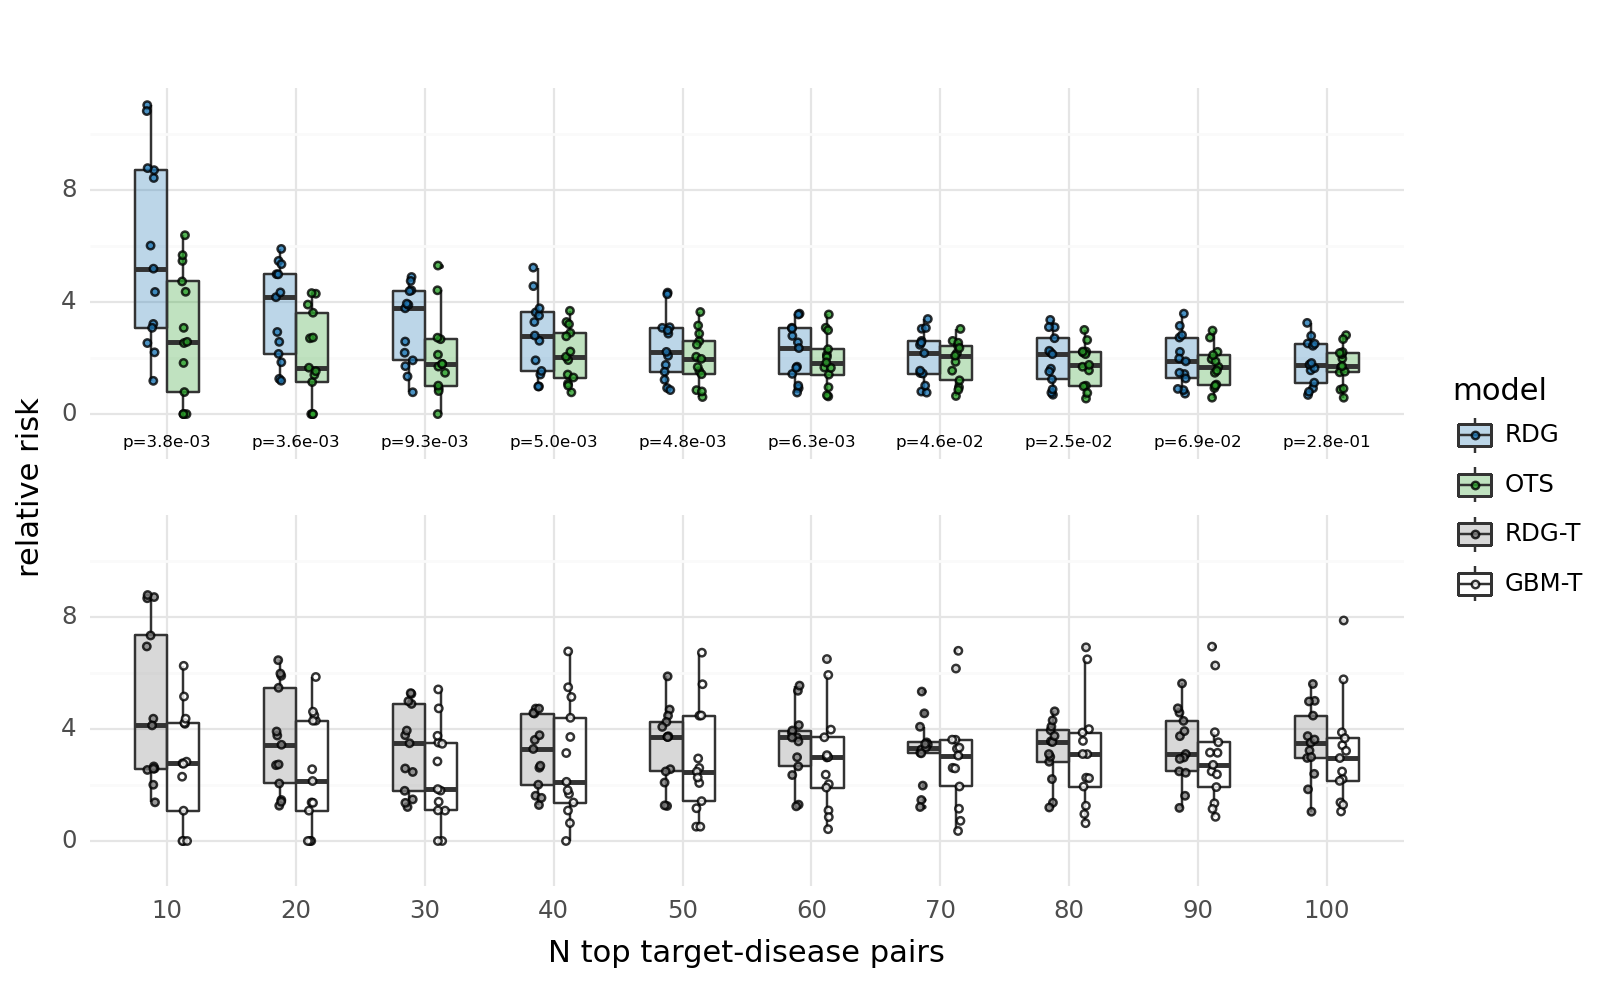

<Figure Size: (800 x 500)>

In [53]:
# fmt: off
(
    relative_risk_by_ta
    .pipe(lambda df: df[~df["therapeutic_area_name"].isin(["average", "all"])])
    .pipe(lambda df: df[df["is_primary_model_feature"]])
    .assign(limit=lambda df: pd.Categorical(df["limit"], ordered=True, categories=sorted(df["limit"].unique())))
    .pipe(assert_condition, lambda df: df["limit"].notnull().all())
    .assign(model_slug=lambda df: pd.Categorical(df["model_slug"], ordered=True, categories=["RDG", "OTS", "RDG-T", "GBM-T"]))
    .dropna(subset=["model_slug"])
    .pipe(assert_condition, lambda df: df["model_slug"].notnull().all())
    .pipe(apply, lambda df: display(
        df
        .pipe(assert_condition, lambda df: (df.groupby(["model_slug", "limit"])["p_value"].nunique() <= 1).all())
        .groupby(["model_slug", "limit"])["p_value"].max()
        .unstack(["model_slug"])
        .sort_index(axis="columns")
        .drop(columns="OTS")
        .style
        .format(precision=6)
        .background_gradient(cmap='Blues_r', axis=None, vmin=0, vmax=.1)
        .set_caption(nb.PRIMARY_TABLES["relative_risk_p_values"]["caption"])
    ))
    .pipe(apply, lambda df: display(
        df
        .pipe(lambda df: df[df["model_slug"].isin(["RDG", "OTS"])])
        .set_index(["therapeutic_area_name", "model_slug", "limit"])["relative_risk"]
        .unstack(["model_slug", "limit"])
        .sort_index(axis="columns")
        .style
        .format(precision=2)
        .background_gradient(cmap='Blues', axis=None)
        .set_caption("Average relative risk by therapeutic area, model, and limit")
    ))
    .assign(model_group=lambda df: df["model_slug"].str.contains("-").map({True: "secondary", False: "primary"}))
    .pipe(lambda df: nb.save_figure("relative_risk_dist_across_ta.pdf", enable_result_export)(
        pn.ggplot(
            df, 
            pn.aes(x='limit', y='relative_risk')
        ) + 
        pn.geom_boxplot(
            mapping=pn.aes(fill='model_slug'), 
            position=pn.position_dodge(width=.5), 
            width=.5, alpha=.3, outlier_size=0
        ) +
        pn.geom_point(
            mapping=pn.aes(fill='model_slug'),
            position=pn.position_jitterdodge(jitter_width=.2, jitter_height=0, dodge_width=.5, random_state=0), 
            size=1, alpha=0.8
        ) +
        pn.geom_text(
            data=(
                df
                .pipe(lambda df: df[df["model_slug"].isin(["RDG"])])
                [["model_slug", "model_group", "limit", "p_value"]].drop_duplicates()
                .assign(label=lambda df: df["p_value"].apply(lambda v: f"p={v:.1e}"))
            ),
            mapping=pn.aes(y=-1, label="label"), size=6
        ) +
        pn.facet_wrap("~ model_group", ncol=1, labeller=lambda v: "") +
        pn.labs(x='N top target-disease pairs', y='relative risk', fill='model', color='model') +
        pn.theme_minimal() +
        pn.scale_fill_manual(values=primary_model_colors) +
        pn.theme(figure_size=(figure_width, 5))
    ))
)
# fmt: on

##### Therapeutic area classification metrics

INFO:analysis:Saving figure to '/home/eczech/repos/clinical_advancement_paper/paper/assets/classifier_metrics_dist_across_ta.pdf'
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3 x 3 in image.
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/eczech/repos/clinical_advancement_paper/paper/assets/classifier_metrics_dist_across_ta.pdf


INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


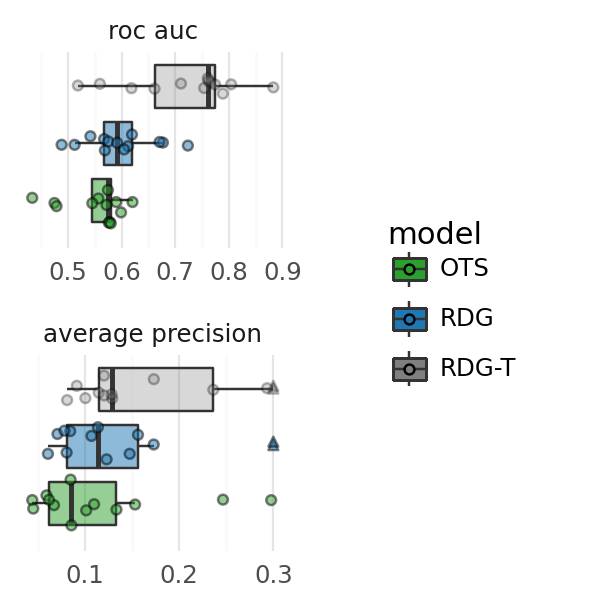

<Figure Size: (300 x 300)>

In [54]:
(
    nb.prepare_classification_metrics_by_therapeutic_area(
        classification_metrics,
        primary_models=primary_models,
        primary_therapeutic_areas=primary_therapeutic_areas,
        ap_max_value=0.3,
    ).pipe(
        lambda df: nb.save_figure(
            "classifier_metrics_dist_across_ta.pdf", enable_result_export
        )(
            pn.ggplot(
                df,
                pn.aes(
                    x="model_slug",
                    y="value",
                    fill="model_slug",
                    alpha="model_group",
                ),
            )
            + pn.geom_boxplot(outlier_size=0, outlier_shape="None")
            + pn.geom_sina(mapping=pn.aes(shape="clipped", group="model_slug"))
            + pn.facet_wrap("~ metric", scales="free_x", ncol=1)
            + pn.labs(x="", y="", fill="model")
            + pn.scale_alpha_manual(values={"primary": 0.5, "secondary": 0.3})
            + pn.scale_fill_manual(values=primary_model_colors)
            + pn.guides(alpha=None, shape=None)
            + pn.coord_flip()
            + pn.theme_minimal()
            + pn.theme(
                plot_margin=0,
                figure_size=(figure_width - 5, 3),
                axis_text_y=pn.element_blank(),
                panel_spacing_y=0.05,
                legend_box_margin=30,
                panel_grid_major_y=pn.element_blank(),
                panel_grid_minor_y=pn.element_blank(),
            )
        )
    )
)

INFO:analysis:Saving figure to '/home/eczech/repos/clinical_advancement_paper/paper/assets/performance_metric_mean_across_ta.pdf'
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7 x 3 in image.
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/eczech/repos/clinical_advancement_paper/paper/assets/performance_metric_mean_across_ta.pdf


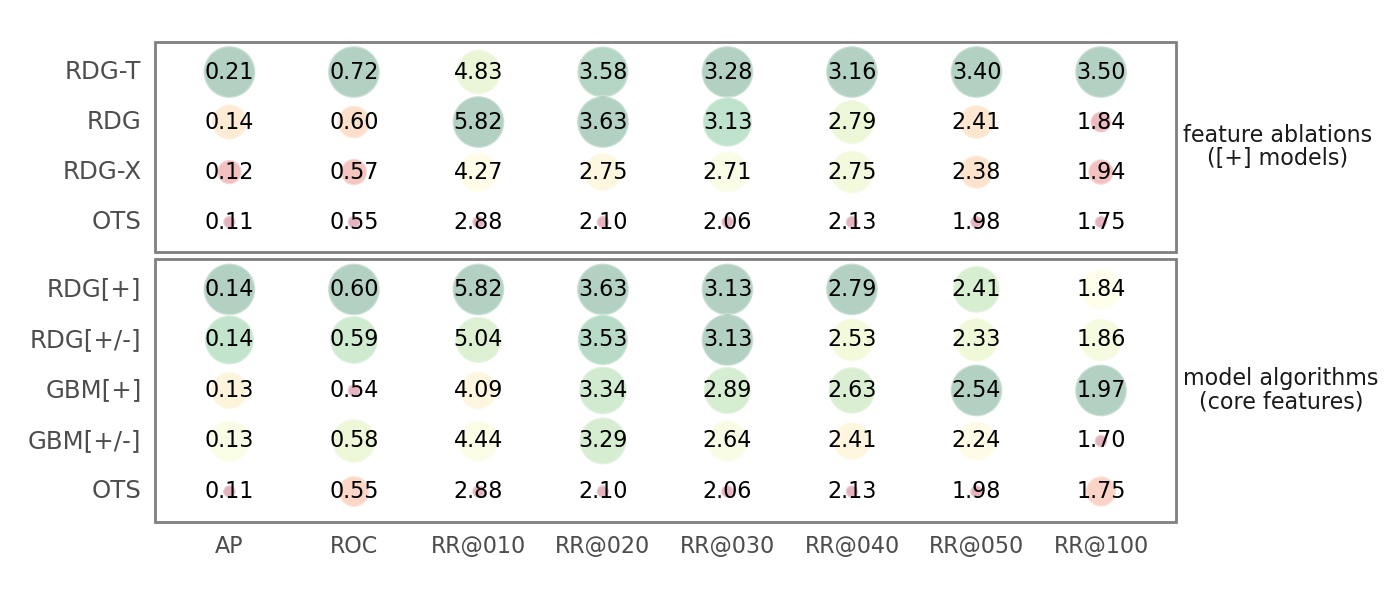

<Figure Size: (700 x 300)>

model_name  metric  limit  n_therapeutic_areas     value  \
0                      ots__all      AP    NaN                   13  0.114441   
1                      ots__all     ROC    NaN                   13  0.551932   
2            rdg__all__positive      AP    NaN                   13  0.205498   
3            rdg__all__positive     ROC    NaN                   13  0.720047   
4         rdg__no_tgc__positive      AP    NaN                   13  0.122994   
..                          ...     ...    ...                  ...       ...   
67  rdg__no_time__unconstrained  RR@020   20.0                   13  3.529715   
68  rdg__no_time__unconstrained  RR@030   30.0                   13  3.127115   
69  rdg__no_time__unconstrained  RR@040   40.0                   13  2.528838   
70  rdg__no_time__unconstrained  RR@050   50.0                   13  2.326918   
71  rdg__no_time__unconstrained  RR@100  100.0                   13  1.857617   

    has_all_primary_therapeutic_areas model_algorithm model_features  \
0                                True             ots            all   
1                                True             ots            all   
2                                True             rdg            all   
3                                True             rdg            all   
4                                True             rdg         no_tgc   
..                                ...             ...            ...   
67                               True             rdg        no_time   
68                               True             rdg        no_time   
69                               True             rdg        no_time   
70                               True             rdg        no_time   
71                               True             rdg        no_time   

   model_constraint     model                              group  norm_value  \
0                         OTS    feature ablations\n([+] models)    0.000000   
1                         OTS    feature ablations\n([+] models)    0.000000   
2          positive     RDG-T    feature ablations\n([+] models)    1.000000   
3          positive     RDG-T    feature ablations\n([+] models)    1.000000   
4          positive     RDG-X    feature ablations\n([+] models)    0.093931   
..              ...       ...                                ...         ...   
67    unconstrained  RDG[+/-]  model algorithms\n(core features)    0.931486   
68    unconstrained  RDG[+/-]  model algorithms\n(core features)    0.999021   
69    unconstrained  RDG[+/-]  model algorithms\n(core features)    0.599344   
70    unconstrained  RDG[+/-]  model algorithms\n(core features)    0.621543   
71    unconstrained  RDG[+/-]  model algorithms\n(core features)    0.581807   

    text  
0   0.11  
1   0.55  
2   0.21  
3   0.72  
4   0.12  
..   ...  
67  3.53  
68  3.13  
69  2.53  
70  2.33  
71  1.86  

[72 rows x 13 columns]

In [55]:
(
    nb.combine_average_therapeutic_metrics(
        relative_risk_by_ta,
        classification_metrics,
        primary_therapeutic_areas=primary_therapeutic_areas,
    )
    .pipe(
        apply,
        lambda df: display(
            df.pipe(lambda df: df[df["has_all_primary_therapeutic_areas"]])
            .pipe(lambda df: df[(df["limit"] <= 50) | df["limit"].isnull()])
            .set_index(["model_name", "n_therapeutic_areas", "metric"])["value"]
            .unstack("metric")
            .sort_values("average_precision", ascending=False)
            .style.format(precision=4, na_rep="")
            .background_gradient(cmap="Blues", axis=0)
            .highlight_null(color="white")
            .set_caption(
                "Performance metric averages across primary therapeutic areas by model"
            )
        ),
    )
    .pipe(nb.prepare_average_therapeutic_area_metrics)
    .pipe(
        apply,
        lambda df: display(
            df.pipe(
                lambda df: nb.save_figure(
                    "performance_metric_mean_across_ta.pdf", enable_result_export
                )(
                    pn.ggplot(df, pn.aes(x="metric", y="model", label="text"))
                    + pn.geom_point(
                        mapping=pn.aes(fill="norm_value", size="norm_value"),
                        color="white",
                        shape="o",
                        alpha=0.3,
                    )
                    + pn.facet_grid(
                        "group ~", scales="free", space={"x": [1], "y": [1, 1.25]}
                    )
                    + pn.geom_text(size=8)
                    + pn.guides(fill=None, color=None, size=None)
                    + pn.labs(x="", y="")
                    + pn.scale_fill_cmap("RdYlGn")
                    + pn.scale_color_cmap("RdYlGn")
                    + pn.scale_size_continuous(range=(2, 10))
                    + pn.theme_minimal()
                    + pn.theme(
                        panel_border=pn.element_rect(color="grey", fill=None, size=1),
                        figure_size=(figure_width - 1, 3),
                        axis_text_x=pn.element_text(size=8),
                        panel_grid_major=pn.element_blank(),
                        strip_text_y=pn.element_text(size=8, rotation=0),
                        panel_spacing_y=0.005,
                    )
                )
            )
        ),
    )
)

##### Top prediction relative risk

In [56]:
primary_method_relative_risk = (
    nb.get_feature_relative_risk(
        evaluation_dataset,
        model_names=primary_models["model"].values.tolist(),
        model_limits=np.arange(10, 501, 5).tolist(),
        confidence=0.9,
    )
    .pipe(
        nb.enrich_feature_relative_risk,
        primary_models=primary_models,
        primary_benchmarks=primary_benchmarks,
    )
    .pipe(
        lambda df: df[
            df["is_primary_model_feature"] | df["is_primary_benchmark_feature"]
        ]
    )
)

In [57]:
display(
    primary_method_relative_risk.pipe(lambda df: df[df["is_primary_benchmark_feature"]])
)

display(
    primary_method_relative_risk.pipe(
        lambda df: df[df["is_primary_model_feature"]]
    ).head(3)
)

method  fraction_control  \
111          target_disease__genetic_association__omim          0.089595   
166           target_disease__genetic_association__eva          0.089318   
300  target_disease__genetic_association__ot_geneti...          0.089549   

     fraction_exposed  n_control  n_exposed  n_exposed_true  n_total  \
111          0.428571     8996.0       14.0             6.0   9010.0   
166          0.261905     8968.0       42.0            11.0   9010.0   
300          0.185185     8956.0       54.0            10.0   9010.0   

     relative_risk  relative_risk_high  relative_risk_low model_name  \
111       4.783410            7.970664           2.870653       None   
166       2.932287            4.506196           1.908108       None   
300       2.067978            3.317972           1.288900       None   

    model_slug  is_model_feature  is_primary_model_feature  \
111        NaN             False                     False   
166        NaN             False                     False   
300        NaN             False                     False   

         benchmark_name benchmark_slug benchmark_disp  \
111                omim           OMIM           OMIM   
166                 eva            EVA    EVA/ClinVar   
300  ot_genetics_portal            OTG       OTG/GWAS   

     is_primary_benchmark_feature  limit  
111                          True   <NA>  
166                          True   <NA>  
300                          True   <NA>

method  fraction_control  \
0  target_disease__model__gbm__all__unconstrained...          0.087963   
1  target_disease__model__gbm__all__unconstrained...          0.085068   
2  target_disease__model__gbm__all__unconstrained...          0.088553   

   fraction_exposed  n_control  n_exposed  n_exposed_true  n_total  \
0          0.758621     8981.0       29.0            22.0   9010.0   
1          0.684211     8934.0       76.0            52.0   9010.0   
2          0.761905     8989.0       21.0            16.0   9010.0   

   relative_risk  relative_risk_high  relative_risk_low  \
0       8.624269           10.336800           7.195458   
1       8.043075            9.254627           6.990131   
2       8.603972           10.595742           6.986612   

                model_name model_slug  is_model_feature  \
0  gbm__all__unconstrained      GBM-T              True   
1  gbm__all__unconstrained      GBM-T              True   
2  gbm__all__unconstrained      GBM-T              True   

   is_primary_model_feature benchmark_name benchmark_slug benchmark_disp  \
0                      True            NaN            NaN            NaN   
1                      True            NaN            NaN            NaN   
2                      True            NaN            NaN            NaN   

   is_primary_benchmark_feature  limit  
0                         False     25  
1                         False     75  
2                         False     20

In [58]:
relative_risk_thresholds = nb.get_relative_risk_thresholds(
    primary_method_relative_risk, evaluation_dataset
)
relative_risk_thresholds

model      benchmark_name benchmark_slug  \
0   gbm__all__unconstrained                 eva            EVA   
1   gbm__all__unconstrained                omim           OMIM   
2   gbm__all__unconstrained  ot_genetics_portal            OTG   
3                  ots__all                 eva            EVA   
4                  ots__all                omim           OMIM   
5                  ots__all  ot_genetics_portal            OTG   
6        rdg__all__positive                 eva            EVA   
7        rdg__all__positive                omim           OMIM   
8        rdg__all__positive  ot_genetics_portal            OTG   
9     rdg__no_tgc__positive  ot_genetics_portal            OTG   
10   rdg__no_time__positive                 eva            EVA   
11   rdg__no_time__positive                omim           OMIM   
12   rdg__no_time__positive  ot_genetics_portal            OTG   
13    rdg__no_tgc__positive                 eva            EVA   
14    rdg__no_tgc__positive                omim           OMIM   

    benchmark_relative_risk  benchmark_n_pairs  limit_lower_bound  \
0                  2.932287               42.0              500.0   
1                  4.783410               14.0              290.0   
2                  2.067978               54.0              500.0   
3                  2.932287               42.0               60.0   
4                  4.783410               14.0               15.0   
5                  2.067978               54.0              100.0   
6                  2.932287               42.0               85.0   
7                  4.783410               14.0               20.0   
8                  2.067978               54.0              500.0   
9                  2.067978               54.0               15.0   
10                 2.932287               42.0               80.0   
11                 4.783410               14.0               10.0   
12                 2.067978               54.0              165.0   
13                 2.932287               42.0                NaN   
14                 4.783410               14.0                NaN   

    limit_upper_bound  limit  model_prediction_threshold  
0                 NaN    NaN                         NaN  
1               280.0  285.0                    0.290257  
2                 NaN    NaN                         NaN  
3                45.0   52.5                    0.044880  
4                20.0   17.5                    0.143517  
5               105.0  102.5                    0.034779  
6                90.0   87.5                    0.406869  
7                25.0   22.5                    0.487539  
8               245.0  372.5                    0.332489  
9                20.0   17.5                    0.202184  
10               70.0   75.0                    0.300105  
11               15.0   12.5                    0.425909  
12              170.0  167.5                    0.267991  
13               10.0    NaN                         NaN  
14               10.0    NaN                         NaN

INFO:analysis:Saving figure to '/home/eczech/repos/clinical_advancement_paper/paper/assets/relative_risk_by_limit.pdf'
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 4 in image.
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/eczech/repos/clinical_advancement_paper/paper/assets/relative_risk_by_limit.pdf


INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


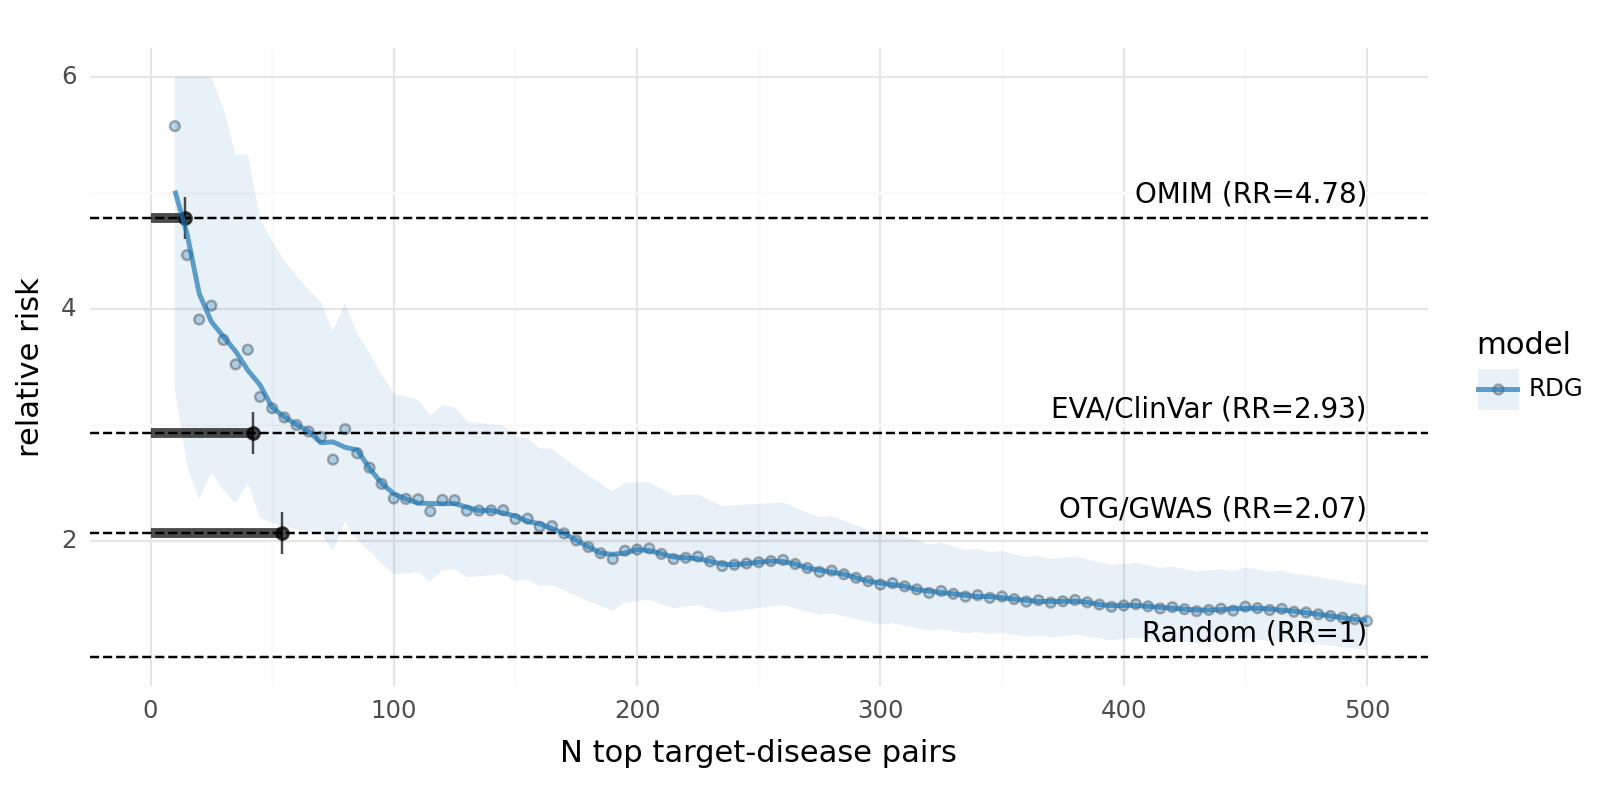

<Figure Size: (800 x 400)>

method  fraction_control  \
104  target_disease__model__rdg__no_time__positive_...          0.089667   
118  target_disease__model__rdg__no_time__positive_...          0.089605   
129  target_disease__model__rdg__no_time__positive_...          0.089544   
120  target_disease__model__rdg__no_time__positive_...          0.089371   
125  target_disease__model__rdg__no_time__positive_...          0.089310   
..                                                 ...               ...   
418  target_disease__model__rdg__no_time__positive_...          0.088394   
431  target_disease__model__rdg__no_time__positive_...          0.088446   
437  target_disease__model__rdg__no_time__positive_...          0.088498   
447  target_disease__model__rdg__no_time__positive_...          0.088550   
459  target_disease__model__rdg__no_time__positive_...          0.088602   

     fraction_exposed  n_control  n_exposed  n_exposed_true  n_total  \
104          0.500000     9000.0       10.0             5.0   9010.0   
118          0.400000     8995.0       15.0             6.0   9010.0   
129          0.350000     8990.0       20.0             7.0   9010.0   
120          0.360000     8985.0       25.0             9.0   9010.0   
125          0.333333     8980.0       30.0            10.0   9010.0   
..                ...        ...        ...             ...      ...   
418          0.120833     8530.0      480.0            58.0   9010.0   
431          0.119588     8525.0      485.0            58.0   9010.0   
437          0.118367     8520.0      490.0            58.0   9010.0   
447          0.117172     8515.0      495.0            58.0   9010.0   
459          0.116000     8510.0      500.0            58.0   9010.0   

     relative_risk  relative_risk_high  relative_risk_low  \
104       5.576208            9.408212           3.304995   
118       4.464020            7.531750           2.645796   
129       3.908696            6.471931           2.360640   
120       4.028144            6.267748           2.588800   
125       3.732336            5.727822           2.432047   
..             ...                 ...                ...   
418       1.366987            1.687152           1.107579   
431       1.352102            1.669009           1.095368   
437       1.337520            1.651232           1.083409   
447       1.323232            1.633809           1.071694   
459       1.309231            1.616730           1.060217   

                 model_name model_slug  is_model_feature  \
104  rdg__no_time__positive        RDG              True   
118  rdg__no_time__positive        RDG              True   
129  rdg__no_time__positive        RDG              True   
120  rdg__no_time__positive        RDG              True   
125  rdg__no_time__positive        RDG              True   
..                      ...        ...               ...   
418  rdg__no_time__positive        RDG              True   
431  rdg__no_time__positive        RDG              True   
437  rdg__no_time__positive        RDG              True   
447  rdg__no_time__positive        RDG              True   
459  rdg__no_time__positive        RDG              True   

     is_primary_model_feature benchmark_name benchmark_slug benchmark_disp  \
104                      True            NaN            NaN            NaN   
118                      True            NaN            NaN            NaN   
129                      True            NaN            NaN            NaN   
120                      True            NaN            NaN            NaN   
125                      True            NaN            NaN            NaN   
..                        ...            ...            ...            ...   
418                      True            NaN            NaN            NaN   
431                      True            NaN            NaN            NaN   
437                      True            NaN            NaN            NaN   
447                      True       

In [59]:
def plot_relative_risk_by_limit(
    df,
    nudge_y: float = 0.2,
    annot_text_size: int = 10,
    max_rr: float = float("inf"),
    max_limit: int | None = None,
):
    stats = primary_method_relative_risk.pipe(
        lambda df: df[df["is_primary_benchmark_feature"]]
    ).set_index("benchmark_name")
    df = df.assign(
        relative_risk_smooth=lambda df: df["relative_risk_smooth"].clip(0, max_rr),
        relative_risk=lambda df: df["relative_risk"].clip(0, max_rr),
        relative_risk_low=lambda df: df["relative_risk_low"].clip(0, max_rr),
        relative_risk_high=lambda df: df["relative_risk_high"].clip(0, max_rr),
    ).pipe(lambda df: df[df["limit"] <= max_limit] if max_limit else df)
    # fmt: off
    p = (
        pn.ggplot(df, pn.aes(x="limit", y="relative_risk", group="model_slug", fill="model_slug"))
        + pn.geom_ribbon(pn.aes(ymin="relative_risk_low", ymax="relative_risk_high"), outline_type='full', alpha=0.1)
        + pn.geom_hline(yintercept=1, linetype="dashed")
        + pn.annotate("text", x=df["limit"].max(), y=1 + nudge_y, label="Random (RR=1)", size=annot_text_size, ha="right")
    )
    p = functools.reduce(
        lambda a, b: a + b,
        [
            layer
            for benchmark in stats.index
            for layer in [
                pn.geom_hline(yintercept=stats.loc[benchmark]["relative_risk"], linetype="dashed"),
                pn.annotate("text", x=df["limit"].max(), y=stats.loc[benchmark]["relative_risk"] + nudge_y, label=f"{stats.loc[benchmark]['benchmark_disp']} (RR={stats.loc[benchmark]['relative_risk']:.2f})", size=annot_text_size, ha="right"),
                pn.annotate("point", alpha=.7, shape="|", size=8, x=stats.loc[benchmark]["n_exposed"], y=stats.loc[benchmark]["relative_risk"]),
                pn.annotate("point", alpha=.7, shape="o", size=2, x=stats.loc[benchmark]["n_exposed"], y=stats.loc[benchmark]["relative_risk"]),
                pn.annotate("segment", alpha=.7, size=2, lineend="round", x=0, y=stats.loc[benchmark]["relative_risk"], xend=stats.loc[benchmark]["n_exposed"], yend=stats.loc[benchmark]["relative_risk"]),
            ]
        ],
        p
    )
    p = (
        p
        + pn.geom_point(alpha=0.3)
        + pn.geom_line(mapping=pn.aes(y="relative_risk_smooth", color="model_slug"), size=1, alpha=.7)
    )
    # fmt: on
    return p


(
    primary_method_relative_risk.pipe(
        lambda df: df[df["model_name"] == primary_rdg_model]
    )
    .assign(limit=lambda df: df["limit"].astype(int))
    .pipe(assert_condition, lambda df: df["model_slug"].notnull().all())
    .sort_values(["model_slug", "limit"])
    .assign(
        relative_risk_smooth=lambda df: (
            df.groupby("model_slug")["relative_risk"].transform(
                lambda s: s.rolling(window=3, center=True, min_periods=1).mean()
            )
        )
    )
    .pipe(
        apply,
        lambda df: display(
            nb.save_figure("relative_risk_by_limit.pdf", enable_result_export)(
                plot_relative_risk_by_limit(df, max_limit=500, max_rr=6)
                + pn.theme_minimal()
                + pn.theme(figure_size=(figure_width, 4))
                + pn.scale_fill_manual(values=primary_model_colors)
                + pn.scale_color_manual(values=primary_model_colors)
                + pn.labs(
                    x="N top target-disease pairs",
                    y="relative risk",
                    fill="model",
                    color="model",
                )
            )
        ),
    )
)

#### Predictions

In [60]:
(
    nb.get_ridge_regression_explanations(evaluation_dataset, model=primary_rdg_model)
    .rename(columns={"outcome": "advanced"})
    .sort_values("prediction", ascending=False)
    .head(30)
    .rename_axis("", axis="columns")
    .assign(
        target_symbol=lambda df: df.reset_index()["target_id"]
        .map(target_id_to_symbol)
        .values
    )
    .assign(
        disease_name=lambda df: df.reset_index()["disease_id"]
        .map(disease_id_to_name)
        .apply(
            nb.shorten_text,
            width=40,
        )
        .values
    )
    .set_index(["target_symbol", "disease_name", "prediction", "advanced"], append=True)
    .pipe(lambda df: df.where(df.abs() > 0, np.nan))
    .dropna(how="all", axis="columns")
    .pipe(lambda df: df[df.abs().mean(axis=0).sort_values(ascending=False).index])
    .reset_index("prediction")
    .droplevel(["target_id", "disease_id"], axis="index")
    .pipe(
        lambda df: df.style.format(precision=3, na_rep="")
        .background_gradient(
            cmap="Blues", axis=None, subset=[c for c in df if c != "prediction"]
        )
        .background_gradient(cmap="Greens", axis=None, subset="prediction")
        .pipe(nb.set_default_table_styles, height_px=400)
        .apply_index(
            lambda v: ["white-space: nowrap;"] * len(v),
            level="disease_name",
            axis="index",
        )
    )
)

### Opportunities

In [61]:
enabled = enable_opportunity_analysis

In [62]:
%%run_if $enabled
display(
    nb.get_tractability_buckets(target_tractability)
    .pipe(lambda df: df.set_axis(range(1, len(df) + 1), axis="index"))
    .pipe(
        nb.save_table,
        filename="tractability_bucket_table.tex",
        enable=enable_result_export,
        convert_css=True,
        hrules=True,
        position="H",
        position_float="centering",
        label="tab:tractability_buckets",
        caption="Tractability bucket assignments",
    )
)

INFO:analysis:Saving table to '/home/eczech/repos/clinical_advancement_paper/paper/assets/tractability_bucket_table.tex'


evidence modality confidence
1          Phase 1 Clinical       OC        LOW
2         Advanced Clinical       OC        MED
3             Approved Drug       OC       HIGH
4            GO CC med conf       AB        LOW
5   Human Protein Atlas loc       AB        LOW
6     UniProt SigP or TMHMM       AB        LOW
7      UniProt loc med conf       AB        LOW
8           GO CC high conf       AB        MED
9     UniProt loc high conf       AB        MED
10        Advanced Clinical       AB       HIGH
11            Approved Drug       AB       HIGH
12         Phase 1 Clinical       AB       HIGH
13  Database Ubiquitination       PR        LOW
14           Half-life Data       PR        LOW
15    Small Molecule Binder       PR        LOW
16               Literature       PR        MED
17   UniProt Ubiquitination       PR        MED
18        Advanced Clinical       PR       HIGH
19         Phase 1 Clinical       PR       HIGH
20         Druggable Family       SM        LOW
21      High-Quality Pocket       SM        LOW
22       Med-Quality Pocket       SM        LOW
23      High-Quality Ligand       SM        MED
24    Structure with Ligand       SM        MED
25        Advanced Clinical       SM       HIGH
26            Approved Drug       SM       HIGH
27         Phase 1 Clinical       SM       HIGH

In [63]:
%%run_if $enabled
opportunity_model = primary_rdg_model
assert opportunity_model in primary_models["model"].values
opportunity_benchmark = "eva"
assert opportunity_benchmark in primary_benchmarks["benchmark"].values
display(opportunity_model, opportunity_benchmark)

'rdg__no_time__positive'

'eva'

In [64]:
%%run_if $enabled
opportunity_data = nb.get_opportunity_dataframe(
    spark=spark,
    training_dataset=training_dataset,
    model=opportunity_model,
    input_dir=input_dir,
    output_dir=output_dir if enable_result_export else None,
)
opportunity_data.printSchema()
opportunity_data.show(5)
display(opportunity_data.count())

INFO:analysis:Writing opportunity dataframe to '/home/eczech/repos/facets/local/data/open_targets_ml/results/opportunities.parquet'


root
 |-- target_id: string (nullable = true)
 |-- disease_id: string (nullable = true)
 |-- target__clinical__phase_max__reached: double (nullable = true)
 |-- disease__clinical__phase_max__reached: double (nullable = true)
 |-- target_disease__clinical__phase_max__reached: double (nullable = true)
 |-- target_disease__known_drug__chembl: double (nullable = true)
 |-- target_disease__genetic_association__clingen: double (nullable = true)
 |-- target_disease__genetic_association__curated: double (nullable = true)
 |-- target_disease__genetic_association__eva: double (nullable = true)
 |-- target_disease__genetic_association__gene2phenotype: double (nullable = true)
 |-- target_disease__genetic_association__gene_burden: double (nullable = true)
 |-- target_disease__genetic_association__genomics_england: double (nullable = true)
 |-- target_disease__genetic_association__omim: double (nullable = true)
 |-- target_disease__genetic_association__orphanet: double (nullable = true)
 |-- target

2532087

In [65]:
%%run_if $enabled
opportunity_groupings = nb.get_opportunity_groupings(
    opportunity_data,
    tractability=target_tractability,
    therapeutic_areas=(
        disease_therapeutic_areas
        .filter(F.col("therapeutic_area_name").isin(
            therapeutic_area_info.query("is_secondary")["therapeutic_area_name"]
            .unique().tolist()
        ))
    ),
)
opportunity_groupings.printSchema()

root
 |-- target_id: string (nullable = true)
 |-- disease_id: string (nullable = true)
 |-- target__clinical__phase_max__reached: double (nullable = true)
 |-- disease__clinical__phase_max__reached: double (nullable = true)
 |-- target_disease__clinical__phase_max__reached: double (nullable = true)
 |-- target_disease__known_drug__chembl: double (nullable = true)
 |-- target_disease__genetic_association__clingen: double (nullable = true)
 |-- target_disease__genetic_association__curated: double (nullable = true)
 |-- target_disease__genetic_association__eva: double (nullable = true)
 |-- target_disease__genetic_association__gene2phenotype: double (nullable = true)
 |-- target_disease__genetic_association__gene_burden: double (nullable = true)
 |-- target_disease__genetic_association__genomics_england: double (nullable = true)
 |-- target_disease__genetic_association__omim: double (nullable = true)
 |-- target_disease__genetic_association__orphanet: double (nullable = true)
 |-- target

In [66]:
%%run_if $enabled
opportunity_stats = nb.get_opportunity_statistics(
    opportunity_groupings,
    relative_risk_thresholds.pipe(lambda df: df[df["model"] == opportunity_model]),
).toPandas()
opportunity_stats.info()
display(opportunity_stats.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8928 entries, 0 to 8927
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   target_disease__stage           8928 non-null   object
 1   target__tractability__modality  8928 non-null   object
 2   target__tractability__evidence  8928 non-null   object
 3   disease__therapeutic_area       8928 non-null   object
 4   n_pairs                         8928 non-null   int64 
 5   benchmark_name                  8928 non-null   object
 6   benchmark_slug                  8928 non-null   object
 7   model__n_pairs__over_threshold  8928 non-null   int64 
 8   feature__n_pairs__exists        8928 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 627.9+ KB


target_disease__stage target__tractability__modality  \
0               Phase 1                             PR   
1               Phase 1                             PR   
2               Phase 1                             PR   
3               Phase 1                             PR   
4               Phase 2                             AB   
5               Phase 2                             AB   
6               Phase 2                             AB   
7               Phase 2                             AB   
8                  NONE                             OC   
9                  NONE                             OC   

  target__tractability__evidence disease__therapeutic_area  n_pairs  \
0                     Literature                       ALL     2634   
1                     Literature                       ALL     2634   
2                     Literature                       ALL     2634   
3                     Literature                       ALL     2634   
4                            ALL    cardiovascular disease     1277   
5                            ALL    cardiovascular disease     1277   
6                            ALL    cardiovascular disease     1277   
7                            ALL    cardiovascular disease     1277   
8                            LOW       hematologic disease      239   
9                            LOW       hematologic disease      239   

       benchmark_name benchmark_slug  model__n_pairs__over_threshold  \
0                 eva            EVA                              21   
1                omim           OMIM                               2   
2  ot_genetics_portal            OTG                             115   
3                NONE           NONE                            2634   
4                 eva            EVA                              20   
5                omim           OMIM                               5   
6  ot_genetics_portal            OTG                              33   
7                NONE           NONE                            1277   
8                 eva            EVA                               4   
9                omim           OMIM                               0   

   feature__n_pairs__exists  
0                         7  
1                         1  
2                         9  
3                      2634  
4                        11  
5                         4  
6                        16  
7                      1277  
8                         0  
9                         0

In [67]:
%%run_if $enabled
display(
    opportunity_stats.pipe(lambda df: df[df["disease__therapeutic_area"] == "ALL"])
    .pipe(lambda df: df[df["target_disease__stage"] == "NONE"])
    .rename(columns={"benchmark_slug": "benchmark"})
    .set_index(
        [
            "target_disease__stage",
            "target__tractability__modality",
            "target__tractability__evidence",
            "benchmark",
        ]
    )[["model__n_pairs__over_threshold", "feature__n_pairs__exists"]]
    .unstack("benchmark")
    .fillna(0)
    .astype(int)
    .sort_index()
    .style.background_gradient(axis=None)
)

In [68]:
%%run_if $enabled
display(nb.display_opportunities_by_modality(opportunity_stats, benchmark_name=opportunity_benchmark))

INFO:analysis:Saving figure to '/home/eczech/repos/clinical_advancement_paper/paper/assets/opportunity_funnel.pdf'


/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 6 in image.
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/eczech/repos/clinical_advancement_paper/paper/assets/opportunity_funnel.pdf


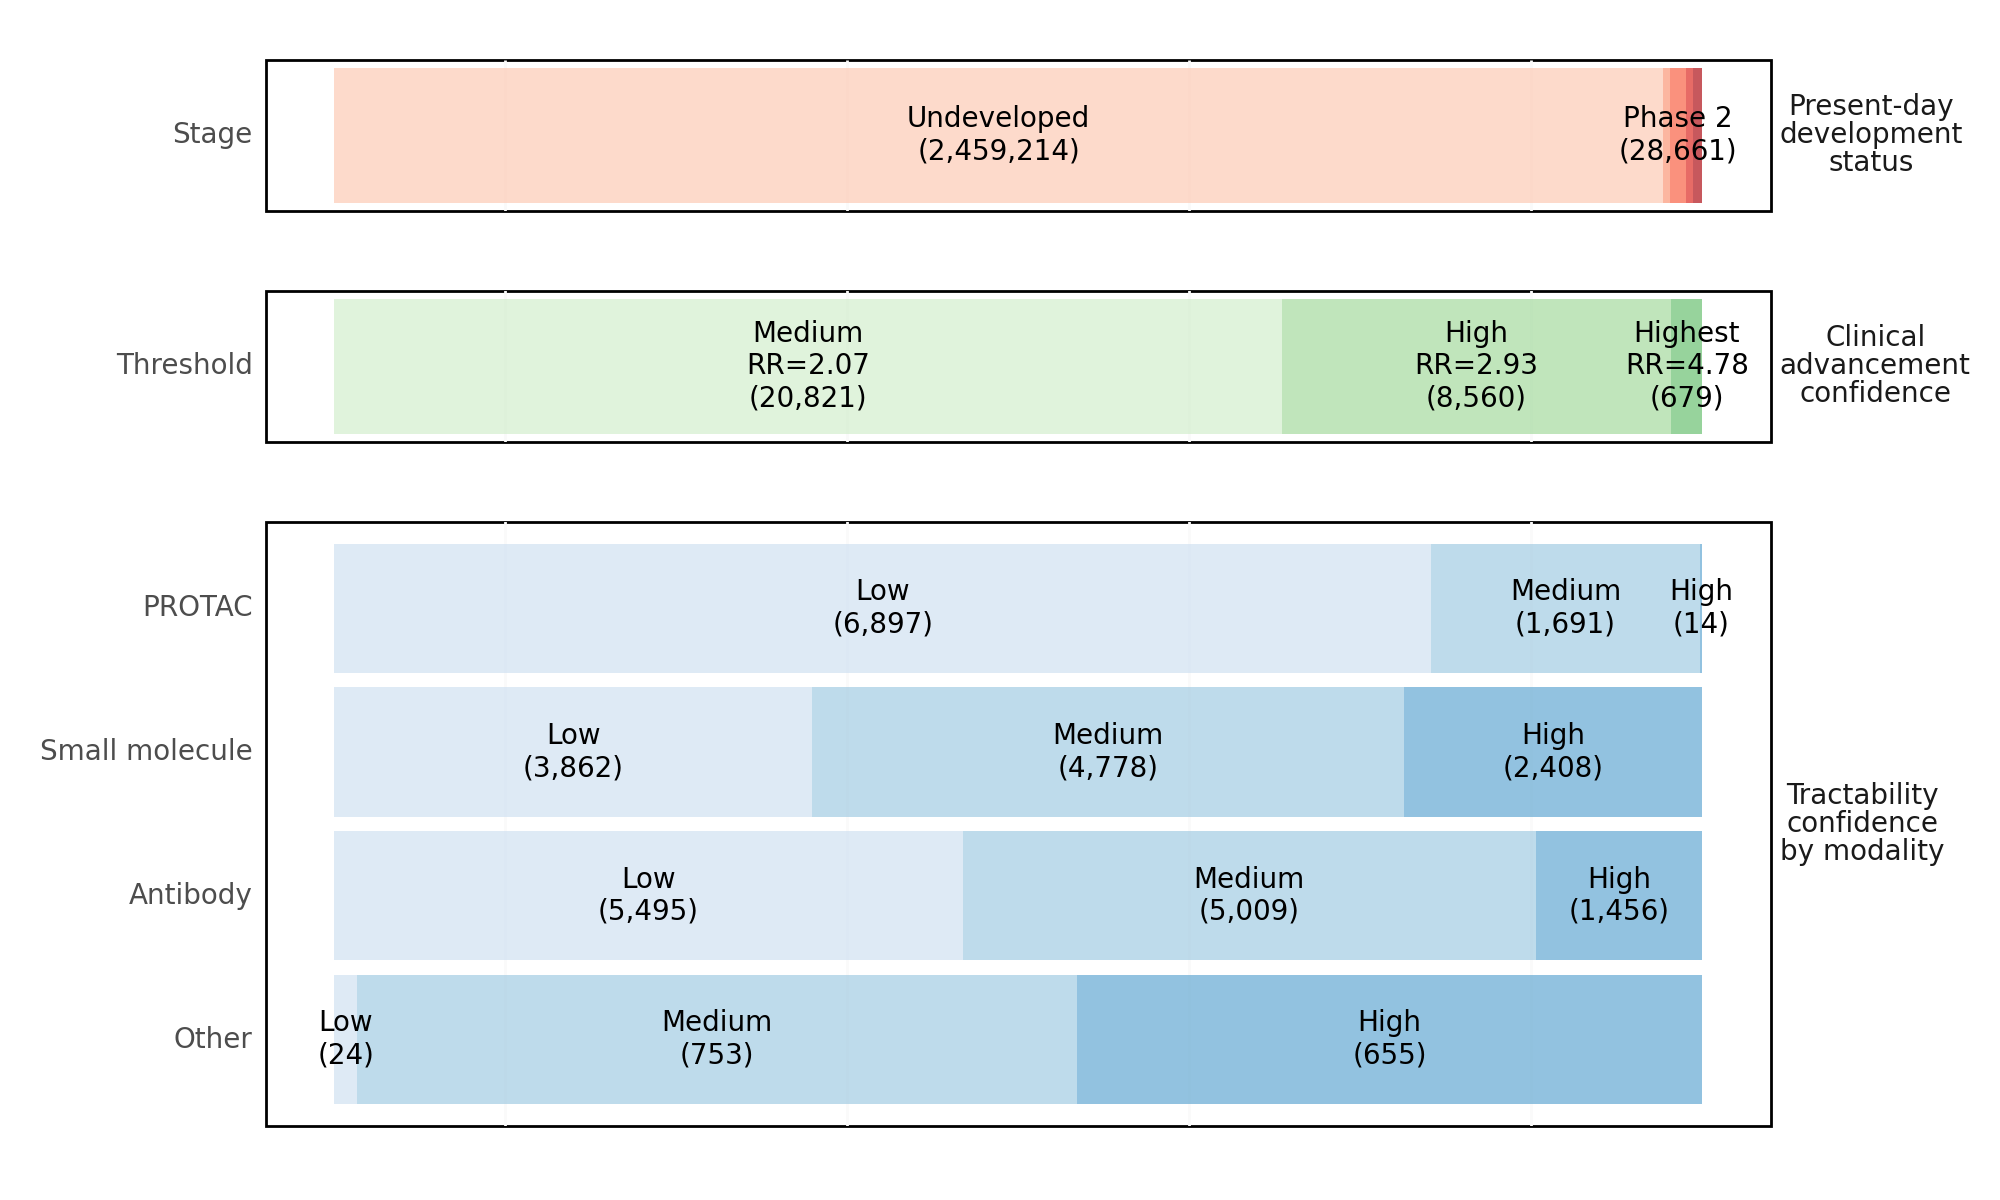

<Figure Size: (1000 x 600)>

In [92]:
%%run_if $enabled
(
    # fmt: off
    nb.prepare_opportunity_funnel(
        opportunity_stats,
        relative_risk_thresholds.pipe(lambda df: df[df["model"] == opportunity_model]),
        color_fn=lambda cmap, value: mcolors.to_hex(
            plt.get_cmap(cmap)(0.2 + value * 0.8)
        ),
    ).pipe(lambda df: nb.save_figure("opportunity_funnel.pdf", enable_result_export)(
            pn.ggplot(
                df,
                pn.aes(x="tick", y="size", fill="level", label="label")
            ) + 
            pn.geom_bar(stat="identity", position="stack", alpha=.7) + 
            pn.coord_flip() + 
            pn.geom_text(position=pn.position_stack(vjust=.5), size=10) + 
            pn.facet_grid("facet ~", scales="free_y", space={"y": [1/6., 1/6., 4/6.]}) +
            pn.labs(x="", y="") + 
            pn.guides(fill=None) + 
            pn.theme_minimal() + 
            pn.scale_fill_manual(values=df.set_index("level")["level_color"].to_dict()) +
            pn.theme(
                figure_size=(figure_width + 2, 6), 
                panel_spacing_y=.04,
                axis_text_x=pn.element_blank(),
                axis_text_y=pn.element_text(size=10),
                panel_grid_major=pn.element_blank(),
                panel_border=pn.element_rect(size=1, color="black"),
                strip_text_y=pn.element_text(size=10, rotation=0),
            )
        )
    )
    # fmt: on
)

In [71]:
%%run_if $enabled
display(nb.display_opportunities_by_category(opportunity_stats, benchmark_name=opportunity_benchmark))

In [72]:
%%run_if $enabled
display(
    opportunity_groupings.filter(F.col("target__tractability__modality") == "AB")
    .filter(F.col("target__tractability__evidence") == "HIGH")
    .filter(F.col("disease__therapeutic_area") == "ALL")
    .filter(F.col("target_disease__stage") == "NONE")
    .filter(
        F.col("prediction")
        >= relative_risk_thresholds.set_index(["model", "benchmark_name"]).loc[
            (opportunity_model, opportunity_benchmark)
        ]["model_prediction_threshold"]
    )
    .toPandas()
    .assign(
        target_symbol=lambda df: df["target_id"].map(target_id_to_symbol),
    )
    .assign(
        disease_name=lambda df: df.reset_index()["disease_id"]
        .map(disease_id_to_name)
        .apply(
            nb.shorten_text,
            width=40,
        )
        .values
    )
    .sort_values("prediction", ascending=False)
    .set_index(
        ["target_symbol", "disease_name"]
    )
    .filter(regex="__genetic_association__|__clinical__|^prediction$")
    .pipe(lambda df: df[df.notnull().mean(axis=0).sort_values(ascending=False).index])
    .drop(columns="target_disease__clinical__phase_max__reached")
    .head(30)
    .pipe(lambda df:
        df
        .style
        .background_gradient(cmap="Blues", axis=None, subset=(other_cols := [c for c in df if "__clinical__" not in c]))
        .background_gradient(cmap="Purples", axis=None, subset=(clin_cols := [c for c in df if "__clinical__" in c]), vmin=0, vmax=4)
        .background_gradient(cmap="Greens", axis=None, subset="prediction")
        .highlight_null(color="white")
        .format(na_rep="", precision=1, subset=other_cols)
        .format(na_rep="", precision=0, subset=clin_cols)
        .format(na_rep="", precision=3, subset="prediction")
        .pipe(nb.set_default_table_styles, height_px=400)
        .apply_index(
            lambda v: ["white-space: nowrap;"] * len(v),
            level="disease_name",
            axis="index",
        )
    )
)

### Sensitivity

In [73]:
enabled = enable_sensitivity_analysis

In [74]:
%%run_if $enabled
sensitivity_configs = nb.get_sensitivity_analysis_configs(config.data_dir)
display(
    sensitivity_configs.drop(columns="path")
    .pipe(apply, lambda df: (
        df
        .drop(columns="filename")
        .pipe(lambda df: df.set_axis(range(1, len(df) + 1), axis="index"))
        .rename(columns=dict(
            version="open_targets_version",
            year="max_training_year",
            window="min_time_to_advancement_years",
        ))
        .pipe(
            nb.save_table,
            filename="sensitivity_configurations.tex",
            enable=enable_result_export,
            convert_css=True,
            hrules=True,
            position="H",
            position_float="centering",
            label="tab:sensitivity_configurations",
            caption="Configurations for sensitivity analysis",
        )
    ))
)

INFO:analysis:Saving table to '/home/eczech/repos/clinical_advancement_paper/paper/assets/sensitivity_configurations.tex'


filename version  year  window
0   analysis__23.09__2017__4   23.09  2017       4
1   analysis__23.12__2017__2   23.12  2017       2
2   analysis__23.09__2015__2   23.09  2015       2
3   analysis__23.12__2015__2   23.12  2015       2
4   analysis__23.09__2017__2   23.09  2017       2
5   analysis__23.06__2015__4   23.06  2015       4
6   analysis__23.06__2017__2   23.06  2017       2
7   analysis__23.06__2013__2   23.06  2013       2
8   analysis__23.06__2015__2   23.06  2015       2
9   analysis__23.06__2017__4   23.06  2017       4
10  analysis__23.12__2013__4   23.12  2013       4
11  analysis__23.09__2015__4   23.09  2015       4
12  analysis__23.09__2013__2   23.09  2013       2
13  analysis__23.12__2013__2   23.12  2013       2
14  analysis__23.09__2013__4   23.09  2013       4
15  analysis__23.12__2017__4   23.12  2017       4
16  analysis__23.12__2015__4   23.12  2015       4
17  analysis__23.06__2013__4   23.06  2013       4

In [75]:
%%run_if $enabled
sensitivity_data = nb.get_sensitivity_data(sensitivity_configs)

100%|██████████| 18/18 [00:16<00:00,  1.06it/s]


In [76]:
%%run_if $enabled
# TODO: remove after next batch run
def remap_model_names(df: pd.DataFrame) -> pd.DataFrame:
    mappings = {"RDG-C": "RDG", "RDG-P": "RDG-T", "GBM-P": "GBM-T", "OTS-C": "OTS"}
    if not any([c in df for c in mappings]):
        raise ValueError(f"No previous model names found in columns: {df.columns}")
    return df.rename(columns=mappings)

sensitivity_data = {k: remap_model_names(v) for k, v in sensitivity_data.items()}

INFO:analysis:Saving figure to '/home/eczech/repos/clinical_advancement_paper/paper/assets/sensitivity_relative_risk.pdf'
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 4 in image.
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/eczech/repos/clinical_advancement_paper/paper/assets/sensitivity_relative_risk.pdf
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


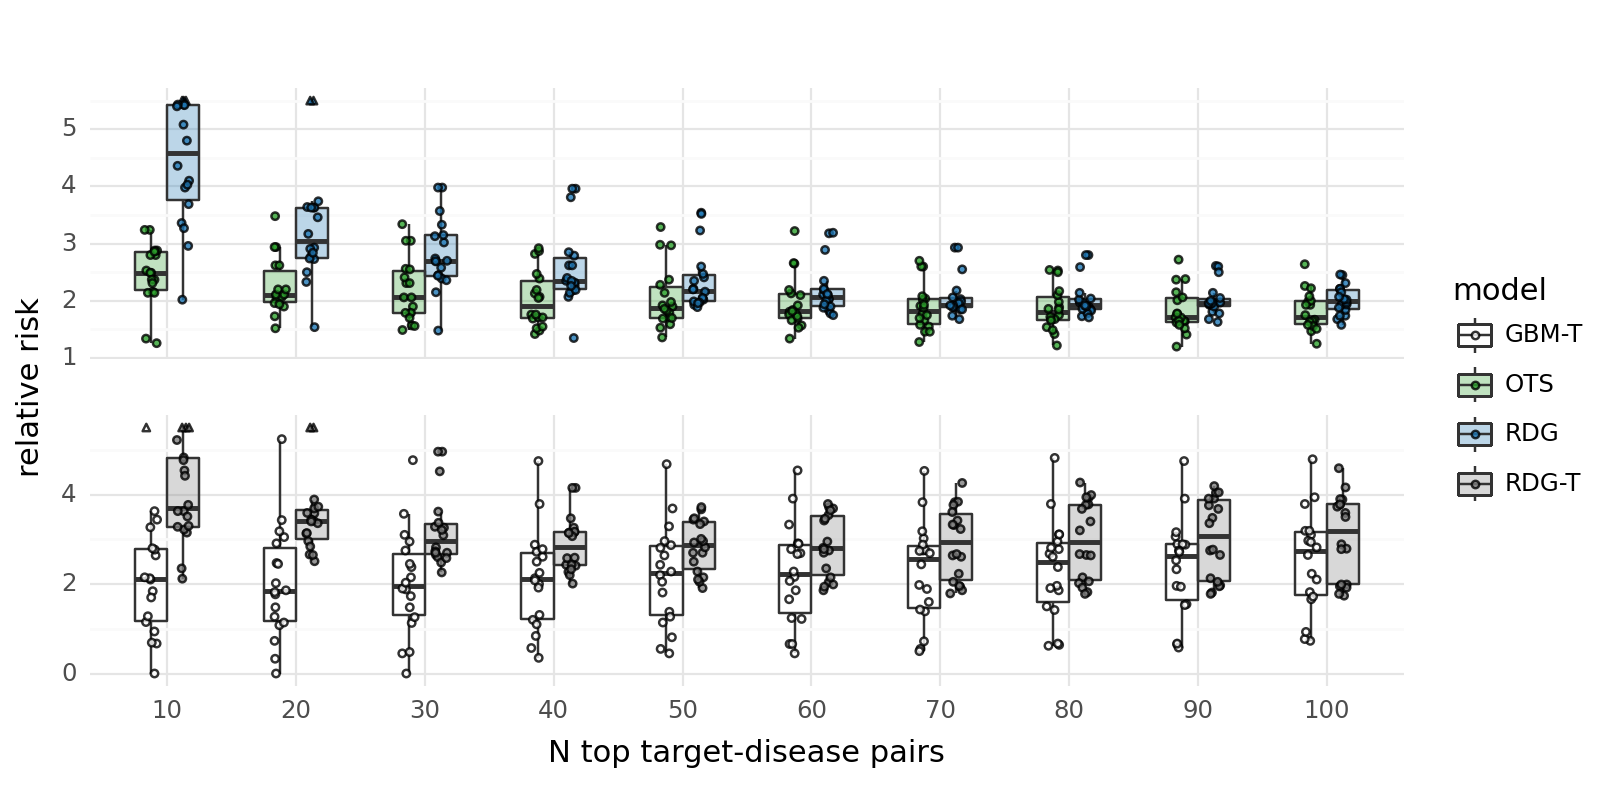

<Figure Size: (800 x 400)>

In [77]:
%%run_if $enabled
display(
    nb.display_sensitivity_relative_risk_averages(sensitivity_data)
    .assign(model_group=lambda df: df["model"].str.contains("-").map({True: "secondary", False: "primary"}))
    .pipe(lambda df: df.assign(**dict(
        clipped=df["relative_risk"] > (max_rr := 5.5),
        relative_risk_clip=df["relative_risk"].clip(0, max_rr),
    )))
    .pipe(
        lambda df: nb.save_figure("sensitivity_relative_risk.pdf", enable_result_export)(
            pn.ggplot(df, pn.aes(x="limit", y="relative_risk_clip", fill="model"))
            + pn.scale_fill_manual(values=primary_model_colors)
            + pn.geom_boxplot(alpha=0.3, width=0.5, outlier_shape="None", position=pn.position_dodge(width=0.5))
            + pn.geom_point(
                mapping=pn.aes(shape="clipped", group="model"),
                position=pn.position_jitterdodge(jitter_width=0.1, jitter_height=0, dodge_width=0.5, random_state=0), 
                size=1, alpha=0.8
            )
            + pn.facet_wrap("~model_group", ncol=1, scales="free_y", labeller=lambda v: "")
            + pn.labs(x="N top target-disease pairs", y="relative risk")
            + pn.guides(shape=None)
            + pn.theme_minimal()
            + pn.theme(figure_size=(figure_width, 4))
        )
    )
)

INFO:analysis:Saving figure to '/home/eczech/repos/clinical_advancement_paper/paper/assets/sensitivity_p_values.pdf'
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 3 in image.
/home/eczech/miniforge3/envs/caf-paper/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /home/eczech/repos/clinical_advancement_paper/paper/assets/sensitivity_p_values.pdf
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


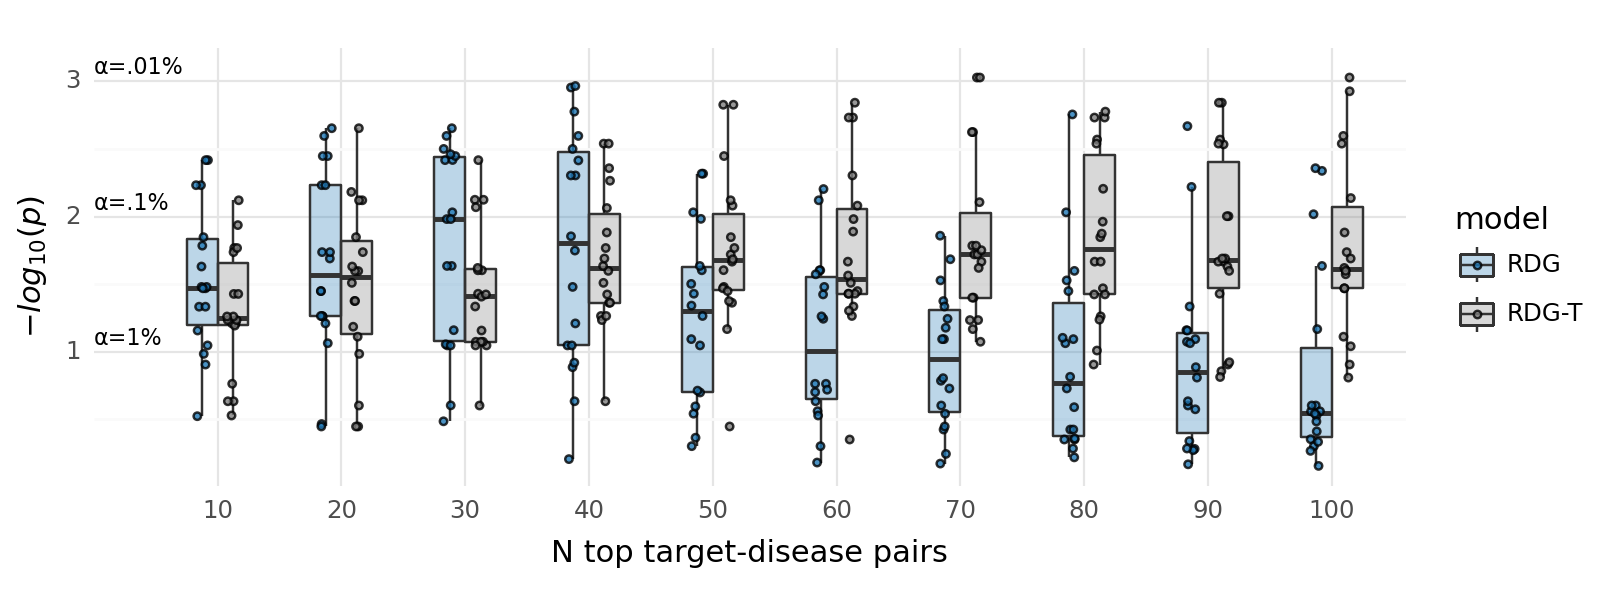

<Figure Size: (800 x 300)>

In [78]:
%%run_if $enabled
display(
    nb.display_sensitivity_p_values(sensitivity_data)
    .pipe(lambda df: df[df["model"] != "GBM-T"])
    .pipe(
        lambda df: nb.save_figure("sensitivity_p_values.pdf", enable_result_export)(
            pn.ggplot(df, pn.aes(x="limit", y="neg_log10_p_value", fill="model"))
            + pn.scale_fill_manual(values=primary_model_colors)
            + pn.geom_boxplot(alpha=0.3, width=0.5, outlier_shape="None", position=pn.position_dodge(width=0.5))
            + pn.geom_point(
                position=pn.position_jitterdodge(jitter_width=0.1, jitter_height=0, dodge_width=0.5, random_state=0), 
                size=1, alpha=0.8
            )
            + pn.annotate("text", x=0, y=1.1, label="α=1%", size=8, ha="left")
            + pn.annotate("text", x=0, y=2.1, label="α=.1%", size=8, ha="left")
            + pn.annotate("text", x=0, y=3.1, label="α=.01%", size=8, ha="left")
            + pn.labs(x="N top target-disease pairs", y="$-log_{10}(p)$")
            + pn.theme_minimal()
            + pn.theme(figure_size=(figure_width, 3))
        )
    )
)